In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from keras.preprocessing import image
import keras.backend as K
import os
import glob
import numpy as np
from skimage import io
import random

Using TensorFlow backend.


In [ ]:
from glob import glob
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.applications import Xception
from keras.utils import multi_gpu_model


In [ ]:
def limit_men():
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

In [ ]:
limit_men()


In [ ]:
path_to_train = './hdd/train_aug'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)


In [ ]:

def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id


In [ ]:
len(train_img_paths)

10897

In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa


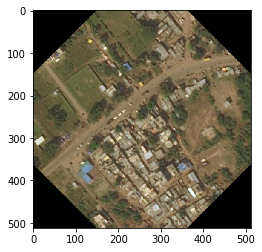

In [ ]:
rotate=iaa.Affine(rotate=(45))
image=rotate.augment_image(imread(train_img_paths[2]))
plt.imshow(image)

In [ ]:
image.shape


(512, 512, 3)

In [ ]:
def mirror_border(images, n):
    """mirrors border n border pixels on each side and corner:
        4D [num_images, image_height, image_width, num_channel]
        or 3D [num_images, image_height, image_width]
    returns:
        4D input: [num_patches, patch_size, patch_size, num_channel]
        3D input: [num_patches, patch_size, patch_size]
    """
    has_channels = (len(images.shape) == 4)
    if has_channels:
        return np.pad(images, ((0, 0), (n, n), (n, n), (0, 0)), "symmetric")
    else:
        return np.pad(images, ((0, 0), (n, n), (n, n)), "symmetric")


def rotate_imgs(imgs, angle):
    """safeguard to avoid useless rotation by 0"""
    if angle == 0:
        return imgs
    return rotate(imgs, angle=angle, axes=(1, 2), order=0)


def expand_and_rotate(imgs, angles, offset=0):
    """rotate some images by an angle, mirror image for missing part and expanding to output_size
        4D [num_images, image_height, image_width, num_channel]
        or 3D [num_images, image_height, image_width]
    angles: list of angle to rotate
    output_size: new size of image
    returns:
        4D input: [num_images * num_angles, output_size, output_size, num_channel]
        3D input: [num_images * num_angles, output_size, output_size]
    """

    has_channels = (len(imgs.shape) == 4)
    if not has_channels:
        imgs = np.expand_dims(imgs, -1)

    batch_size, height, width, num_channel = imgs.shape
    assert height == width

    output_size = height + 2 * offset
    padding = int(np.ceil(height * (np.sqrt(2) - 1) / 2)) + int(np.ceil(offset / np.sqrt(2)))

    print("Applying rotations: {} degrees... ".format(", ".join([str(a) for a in angles])))
    imgs = mirror_border(imgs, padding)
    rotated_imgs = np.zeros((batch_size * len(angles), output_size, output_size, num_channel))
    for i, angle in enumerate(angles):
        rotated_imgs[i * batch_size:(i + 1) * batch_size] = crop_imgs(rotate_imgs(imgs, angle), output_size)
    print("Done")

    if not has_channels:
        rotated_imgs = np.squeeze(rotated_imgs, -1)

    return rotated_imgs



In [ ]:
padding = int(np.ceil(512* (np.sqrt(2) - 1) / 2))
img=mirror_border(image,padding)

In [ ]:
p=np.zeros((1,512,512,3))
p[0]=image

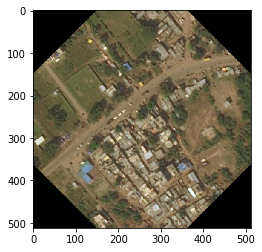

In [ ]:
plt.imshow(image)

In [ ]:
padding

107

In [ ]:
p.shape

(1, 512, 512, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


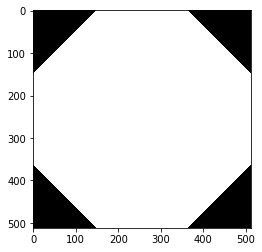

In [ ]:
p[0]=image
n=padding
np.pad(p,(0,0),(n,n),(n,n),(0,0),"symmetric")

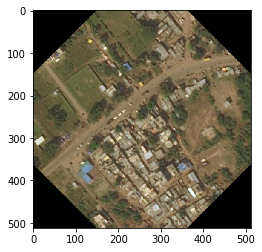

In [ ]:
plt.imshow(image)

In [ ]:
img=mirror_border(p,padding)
img.shape

(1, 726, 726, 3)

In [ ]:
len(train_img_paths)

10897

In [ ]:
i=0
for img_path in train_img_paths:
    
    # Construct the corresponding mask path
    img_id = get_img_id(img_path)
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    # Load the image and mask, and normalize it to 0-1 range 
    j = 8
    id = []
    id = ''.join(str(k) for k in random.sample(range(0,9),j))
    id=int(id)
    image=imread(img_path)
    mask=imread(mask_path)
    rotate=iaa.Affine(rotate=(90))
    image=rotate.augment_image(image)
    mask=rotate.augment_image(mask)
    io.imsave("./hdd/train_aug/%d_sat.jpg"%(id),image)
    io.imsave('./hdd/train_aug/%d_msk.png'%(id),mask)
    i=i+1
    print(i)



1
2
3
4
5
6
7
8


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60825731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9
10


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85240136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


11
12


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6185374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


13
14
15
16
17
18
19
20
21
22


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82364015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


23
24
25
26


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50634281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


27
28
29


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18543072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


30
31


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65178432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


32
33
34


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48067513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72650831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


35
36


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26175384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


37
38
39
40


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6481275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


41
42


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28046753_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


43
44


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72035618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86204715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


45
46


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56473810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


47
48
49
50
51
52


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62850413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


53
54


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41673520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


55
56
57
58


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16452783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


59
60


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35742806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36210754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


61
62
63
64
65


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6813475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


66
67
68
69
70
71


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74123568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


72
73


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30781456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63851472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


74
75
76
77


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86271054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


78
79
80


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63548021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


81
82
83
84
85
86
87
88
89
90
91
92
93
94


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31825764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


95
96


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32641785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


97
98
99
100
101
102
103


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60342817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


104
105
106
107
108
109


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81467520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


110
111
112
113
114
115
116
117
118
119


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32184560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


120
121


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50812743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


122
123
124
125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51784360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56024831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


126
127
128
129
130
131


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18370564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


132
133
134
135
136
137
138
139


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74328051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5746283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68012743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


140
141
142


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84301576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


143
144


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74201635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


145
146
147
148
149
150
151


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3487526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


152
153
154


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86210754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25170386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


155
156


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80316527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


157
158
159
160
161
162


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27530461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


163
164


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62480371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35710682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


165
166


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67281453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14236870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


167
168
169
170


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82564037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


171
172
173
174
175
176


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12734508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


177
178


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6173258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18460735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


179
180
181
182
183
184
185


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74053281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


186
187
188
189
190
191
192
193
194
195
196
197
198


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14072538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12654703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


199
200


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61028743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


201
202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28074351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


203
204


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1327564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


205
206
207
208
209


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4725316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84572301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


210
211
212
213
214
215
216
217
218
219
220
221


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76540382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


222
223
224
225
226
227


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42053786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


228
229
230
231
232
233
234
235
236
237
238
239


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57863241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


240
241
242
243
244
245
246
247
248


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87436120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


249
250
251
252
253
254


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16307854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


255
256


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18250637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


257
258
259
260
261
262
263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40768321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


264
265
266


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81036452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42075613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38740256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


267
268
269
270
271
272
273
274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36205817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


275
276
277


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47268305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


278
279
280
281
282
283
284
285
286
287
288
289
290
291


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8735142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84051367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


292
293
294
295
296
297
298
299
300
301


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3841625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


302
303
304
305
306
307


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48351627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


308
309
310
311


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30271465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65017428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


312
313
314
315


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45603718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


316
317
318
319


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38502476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


320
321


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16734205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68714250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


322
323
324
325
326
327
328
329
330


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10354286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12753048_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


331
332


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12753048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


333
334


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6243581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


335
336
337
338


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85462310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78320516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


339
340
341
342
343
344
345
346
347


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42837165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


348
349
350
351
352


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61873450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84176530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


353
354


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64281357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62371504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


355
356
357
358
359
360
361
362
363
364
365
366
367


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85267134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


368
369


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2415736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


370
371


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20365784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


372
373
374
375
376
377
378
379


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65071834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


380
381
382
383


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87142306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


384
385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67540328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64581270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


386
387
388
389


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78142356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52340168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


390
391
392


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85246703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37461028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


393
394
395


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27048531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


396
397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18436720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


398
399
400
401
402
403
404
405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42016735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


406
407
408
409


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31207458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


410
411
412
413
414
415


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13728056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8735214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


416
417
418
419


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42731806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


420
421
422
423
424


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65380271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


425
426
427
428
429
430
431
432
433
434
435
436


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14036582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


437
438
439
440
441
442
443
444


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65381472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


445
446


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68752130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8614573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


447
448
449
450
451
452
453
454


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20534871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


455
456


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80457316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


457
458
459
460


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35864270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


461
462
463
464
465
466
467
468
469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18027345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


470
471


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47281603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


472
473
474
475


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2864317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


476
477
478
479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43857062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80415672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


480
481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35147206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


482
483


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16740382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


484
485
486
487
488
489


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74680215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


490
491
492
493
494
495
496
497
498


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67238401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


499
500
501
502


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2481357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


503
504
505
506


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68721035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


507
508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73506481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


509
510


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41068537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87061254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


511
512
513
514


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80643721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


515
516
517
518


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43062781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47263180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


519
520
521
522


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63485027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12306758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


523
524
525
526
527
528
529
530
531


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45136782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


532
533
534
535
536


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36458720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74536028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


537
538
539
540
541
542


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67508214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32581046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


543
544
545


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54760813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


546
547
548
549


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15760483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40237851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


550
551


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41803675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


552
553
554


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60357124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


555
556
557
558
559
560
561
562


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80245176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23017846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


563
564
565
566
567
568
569


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18350274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


570
571


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24783056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


572
573
574
575
576
577
578
579
580


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27035648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


581
582


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40687351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


583
584
585
586


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24370861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4783156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


587
588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34587162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


589
590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5462173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74561320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


591
592
593
594
595


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8251376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


596
597
598
599
600


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31054687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


601
602
603
604
605
606
607
608
609


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48327165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


610
611


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61742358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


612
613
614
615
616
617
618
619


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32186705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


620
621
622
623


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7352486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


624
625
626
627
628
629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64305827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


630
631
632
633
634


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5678412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12365870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


635
636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24307865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57082413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


637
638
639


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28507346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


640
641
642
643


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73065214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


644
645
646
647


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46520317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30862754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


648
649


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76043218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10456273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


650
651
652
653
654
655


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67315820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86712430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


656
657


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45201873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60581743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


658
659


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34567102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


660
661


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43512760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


662
663
664
665
666
667
668
669
670
671
672


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24873056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


673
674
675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85107432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18624370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


676
677
678


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54163720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


679
680
681
682
683
684
685


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81742350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


686
687
688
689


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3187246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


690
691
692
693
694
695
696
697
698
699


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6425831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


700
701
702
703


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20534876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


704
705
706


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13685402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58760241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83502647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5241368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


723
724
725


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35710248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


726
727
728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64321085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65103274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


729
730
731
732
733
734
735


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4268137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43172658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


736
737
738
739
740
741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63170452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


742
743


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48137602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46308127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


744
745
746
747


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13460785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41830276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


748
749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74502163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15376208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84265731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


778
779
780
781


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26413708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


782
783
784
785
786
787


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35428170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


788
789


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81520743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


790
791


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41823057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


792
793
794
795


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38610742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16285430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


796
797
798
799
800
801
802
803


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31870654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


804
805


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84270316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


806
807


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65234187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


808
809


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13057624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


810
811
812
813
814
815
816
817
818
819


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24658031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41360582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


820
821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32648510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10275346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


822
823
824
825


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52638140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


826
827
828
829


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63815074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


830
831


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80463152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


832
833
834


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83057142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78524061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


835
836
837
838
839
840
841
842
843
844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6851372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36721850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


845
846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38645712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86237140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


847
848
849
850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30472685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


851
852


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8461735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27540361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


853
854
855
856
857
858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70384516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


859
860


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40215768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12807546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


861
862
863
864


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37168542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


865
866
867
868
869
870


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65214830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


871
872
873
874
875
876


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68402357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


877
878
879
880


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67328514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


881
882
883
884


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45617283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


885
886
887
888


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30687142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


889
890
891
892
893
894
895
896
897
898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10586723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


899
900
901
902
903


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26350814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


904
905


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57802461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48612570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


906
907
908
909


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58620173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45061837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


932
933
934
935


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64102537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


936
937
938
939


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70124653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


940
941
942
943
944
945
946
947


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75210468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42035671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


948
949
950


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34816027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37504218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


951
952
953
954


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78051234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


955
956
957
958
959
960


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31568702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


961
962
963
964
965
966
967


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41732680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


968
969
970
971
972
973


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23587461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78230165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


974
975
976
977
978
979
980
981
982
983
984
985


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3457168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35486270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


986
987


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81572460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


988
989
990
991


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16374508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


992
993
994
995


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51748632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


996
997
998
999


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52174680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61054782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1000
1001
1002
1003
1004
1005


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80761523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1006
1007
1008
1009
1010
1011
1012
1013
1014
1015


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12538407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1016
1017
1018
1019
1020


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17563248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2453618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1021
1022
1023


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75410268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45701328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1024
1025
1026
1027
1028
1029
1030
1031
1032
1033


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7415823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2738465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1034
1035


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68410352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1036
1037
1038
1039
1040
1041
1042
1043
1044


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50463721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1045
1046


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7634218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1047
1048
1049
1050


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47038526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1051
1052


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31876452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1053
1054
1055
1056


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51843267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1057
1058
1059
1060


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54618302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85203146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1061
1062


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48725061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1063
1064
1065
1066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43056872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10385746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1067
1068


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80521473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1069
1070


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78423501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1071
1072
1073
1074
1075
1076
1077


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21465730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1078
1079


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83106247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53082476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1080
1081
1082
1083
1084
1085


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23608571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71802346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1086
1087


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56381072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1088
1089
1090
1091


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15064782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1092
1093


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24613058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24017583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1094
1095
1096
1097
1098
1099
1100
1101


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17235608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1102
1103
1104
1105


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28173465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1106
1107


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87503621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1108
1109
1110
1111


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65718304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54021386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1112
1113
1114
1115


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10428576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2481763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1116
1117
1118
1119


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56182470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1120
1121


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58203174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1122
1123


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12058346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1124
1125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75013268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64215380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1126
1127


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47156230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72153046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1128
1129
1130
1131


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86205731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1132
1133
1134
1135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1652874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1136
1137


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7824513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71682435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1138
1139


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23108547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1140
1141
1142
1143
1144
1145


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67301524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76152038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1146
1147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30824576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1148
1149
1150
1151
1152
1153


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3241786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1154
1155
1156
1157
1158
1159
1160
1161
1162
1163


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62450718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1164
1165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3174268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1166
1167


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56301874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1168
1169
1170
1171
1172
1173
1174
1175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31045267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1176
1177


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80756124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5861324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8456213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1203
1204


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23801746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64107385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1205
1206
1207
1208
1209
1210
1211
1212


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6421873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1213
1214
1215
1216


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80652341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41572608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1217
1218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30718624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1219
1220
1221
1222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47210586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1223
1224
1225
1226


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58673210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1227
1228
1229
1230
1231
1232


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31056478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1233
1234
1235
1236


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6182473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1237
1238


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37650824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1239
1240
1241
1242
1243
1244
1245
1246


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26730451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57360184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1247
1248
1249
1250
1251
1252
1253
1254


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23801456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1255
1256


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84351260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1257
1258


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63250187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1259
1260
1261
1262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18754302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1263
1264
1265
1266


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83624071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1267
1268
1269
1270
1271
1272


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85012763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61427530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1273
1274
1275
1276
1277
1278
1279
1280
1281
1282


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13275486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1283
1284


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37015426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1285
1286


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71803462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1287
1288


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36210854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1289
1290
1291
1292


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76421805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30486175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1293
1294
1295
1296


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45208137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1297
1298


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31405768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6248735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1299
1300


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64780513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74831265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1301
1302
1303
1304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65031784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60415823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6435127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1316
1317
1318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73684201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1319
1320


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65018473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48072135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1321
1322
1323


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34261708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3852147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1324
1325
1326
1327
1328
1329


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60731548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1330
1331


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68215370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1332
1333


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87341526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65817420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1334
1335


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57160382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1336
1337
1338
1339


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54271806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1340
1341


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16204785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61283057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1342
1343


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25740168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1344
1345
1346
1347
1348
1349


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65183740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1350
1351
1352
1353
1354
1355


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53014768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71463250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1356
1357
1358
1359


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58764210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1360
1361


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60142875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1362
1363


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87413605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1364
1365
1366
1367
1368
1369


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71804526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1370
1371
1372
1373
1374
1375


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12605387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1376
1377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63145082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1378
1379
1380
1381
1382
1383


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62108357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1384
1385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5632487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1386
1387
1388
1389
1390
1391
1392
1393
1394
1395


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56187302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1396
1397
1398
1399
1400
1401
1402
1403


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35046218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1404
1405
1406
1407
1408


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56721804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41608253_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1409
1410
1411
1412
1413


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60458132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65814032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1414
1415


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56431820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1416
1417


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16534280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1418
1419
1420
1421


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60427351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1422
1423
1424
1425


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78065324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1426
1427


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74103268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86204375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1428
1429
1430
1431
1432


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16728354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81053624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1433
1434


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75164238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1435
1436


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41503287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1437
1438
1439
1440
1441
1442
1443


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7631824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1444
1445
1446
1447


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65213487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1448
1449
1450
1451
1452


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46812350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1453
1454


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76530128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1455
1456
1457
1458
1459
1460


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38027561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1461
1462
1463
1464


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34107268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1465
1466


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58416203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1467
1468
1469
1470


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58641730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1471
1472


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85143276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4358217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1473
1474


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21608753_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56274083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1475
1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73504628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1492
1493


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28643107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1494
1495
1496
1497


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40258367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1498
1499


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84260137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1500
1501
1502
1503


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64125738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1504
1505


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63204518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78042351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1506
1507
1508
1509
1510
1511
1512
1513
1514
1515


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81760254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3478265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1516
1517


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3162847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1518
1519


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2861543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62385174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1520
1521


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2165347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1522
1523
1524
1525
1526
1527
1528
1529


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84126053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1530
1531
1532
1533
1534


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5216847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1535
1536


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53871024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1537
1538
1539


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25713860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54130826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81756204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1565
1566
1567
1568
1569
1570


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2736154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1571
1572


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40716285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78241365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1573
1574
1575
1576
1577
1578


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14037685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1579
1580


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1475368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1581
1582
1583


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31802654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28150637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1584
1585
1586
1587
1588
1589
1590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43287061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1591
1592
1593
1594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36215478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1595
1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68215740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1611
1612
1613
1614
1615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64352087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17583260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37150246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1616
1617
1618
1619
1620


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2854163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40278651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1621
1622
1623
1624
1625
1626
1627
1628
1629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17364502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1630
1631
1632
1633
1634
1635


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87245163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32875046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1636
1637
1638
1639
1640
1641


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46372108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54861073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1642
1643
1644
1645
1646
1647


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74261803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1648
1649
1650
1651
1652
1653
1654


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85163702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1655
1656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3782654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1657
1658
1659
1660
1661
1662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72340865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1663
1664


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86520431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80635724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1665
1666
1667
1668
1669


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52438107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86542701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1670
1671
1672
1673


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36728510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1674
1675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15083724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1676
1677
1678
1679


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57364812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1680
1681


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51438702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84320651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1682
1683
1684
1685
1686
1687
1688
1689


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8764513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12046837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1690
1691
1692


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46831270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52178604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1693
1694


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24735018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1695
1696


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16025438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1697
1698
1699
1700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35410267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1701
1702


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37182046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1703
1704
1705
1706
1707
1708


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34607152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1709
1710
1711
1712


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14702835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1713
1714


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7541362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1715
1716
1717


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35184720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20736581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1718
1719
1720
1721
1722
1723
1724


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16238057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1725
1726


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87201465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57483621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1727
1728
1729
1730


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30514762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1731
1732


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74058631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1733
1734
1735
1736
1737
1738
1739
1740
1741
1742


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1842573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1743
1744
1745
1746
1747
1748
1749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64710582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1750
1751
1752
1753
1754


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14782650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67438105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1755
1756
1757
1758
1759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4753682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28560134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1760
1761


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3514872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1762
1763


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16875420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67348502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1764
1765
1766
1767
1768
1769


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45826317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1770
1771
1772
1773
1774
1775
1776


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42086713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1777
1778
1779
1780


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85213670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46713802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1781
1782


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31867042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86531207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1795
1796


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74138265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31408657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1797
1798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51204736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1799
1800
1801
1802
1803
1804
1805
1806
1807


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35128764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68107432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1808
1809
1810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35417602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25863471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4375628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1811
1812
1813
1814
1815
1816
1817


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25760183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15386427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1818
1819


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74062831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45307618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1820
1821
1822
1823
1824
1825
1826
1827


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36502147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24613705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52861307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1828
1829
1830
1831
1832
1833
1834
1835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46152803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1836
1837
1838
1839
1840


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30745186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1841
1842
1843


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85426071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1844
1845
1846
1847


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28163745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46531827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1848
1849


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21463078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1850
1851
1852
1853
1854
1855
1856
1857
1858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27356048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1859
1860
1861
1862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28305471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7281536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1863
1864


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81604573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1865
1866


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36182574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75801263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1867
1868
1869
1870
1871


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47601523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1872
1873
1874
1875


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2857634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10587423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1876
1877
1878
1879
1880
1881
1882
1883
1884
1885


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17536804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1886
1887
1888
1889


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21743508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1890
1891
1892
1893
1894
1895
1896
1897


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62507413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15347680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1898
1899
1900
1901
1902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41037268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84072165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1903
1904
1905


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18056273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53782104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56871043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1906
1907
1908


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10284573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67243081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50184327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1921
1922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84071236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30174658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1935
1936
1937
1938


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14652378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1939
1940


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8217635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85614370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32418670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1941
1942
1943
1944
1945
1946
1947
1948
1949


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15260783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1950
1951
1952
1953


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5134672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1954
1955
1956
1957
1958
1959


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14275083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1960
1961
1962
1963


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68015743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43861075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1964
1965


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5318724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64832057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1966
1967


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1372864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1968
1969
1970
1971
1972
1973
1974
1975


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35867014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1976
1977


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30527468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1978
1979


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48105627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1980
1981
1982
1983
1984
1985
1986
1987
1988


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15037248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1989
1990
1991
1992


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31628540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1993
1994
1995
1996


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30715824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1997
1998


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68241573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1999
2000
2001
2002


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64512730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2003
2004
2005
2006
2007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18760345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2008
2009
2010


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20716485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2011
2012
2013
2014
2015
2016


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37851024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87314065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2029
2030
2031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85604327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2032
2033


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28154760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2034
2035


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51730624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83216745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2036
2037


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84627035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2038
2039
2040


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38051647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85604712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2041
2042
2043


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17825460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84675123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2044
2045
2046
2047
2048
2049
2050


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3128746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2051
2052
2053
2054
2055
2056


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47203618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31856074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2057
2058
2059
2060


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80375421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2061
2062
2063


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34561278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2064
2065
2066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80341562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2067
2068
2069
2070


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57123840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70613824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2071
2072
2073
2074
2075
2076
2077
2078


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83702461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85634027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2079
2080
2081
2082
2083
2084
2085
2086
2087
2088


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72416508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2089
2090
2091
2092
2093
2094
2095


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50126387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86357024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36275184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2108
2109


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28765103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2110
2111


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72065138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2112
2113
2114
2115
2116
2117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67250134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2118
2119


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81762503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80761342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2120
2121


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14207658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54687321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2122
2123
2124
2125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28715364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2126
2127
2128
2129
2130
2131


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46170328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2132
2133
2134
2135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26145708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15370426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50387261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17358426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2148
2149


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52864301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2150
2151


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46125307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35742810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2152
2153


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8273651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2154
2155
2156
2157
2158
2159


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58073261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2160
2161
2162
2163
2164
2165
2166
2167


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76284510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20178654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2168
2169
2170
2171
2172
2173
2174
2175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56812307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2176
2177


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10734265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37852601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2178
2179


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27506841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2180
2181
2182
2183
2184
2185


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23187046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2186
2187
2188
2189
2190
2191
2192


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31475068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51274036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2193
2194
2195
2196
2197


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5123467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87365102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2198
2199
2200
2201
2202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65127308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2203
2204
2205
2206
2207


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83725160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2208
2209
2210
2211
2212


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70183546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2213
2214


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17240536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2215
2216


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20534176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2217
2218
2219
2220
2221
2222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72610543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37526148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2223
2224
2225
2226
2227
2228


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72831056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2229
2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87615420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2241
2242
2243
2244


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63485712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2245
2246
2247
2248
2249


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32176504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8657321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2250
2251
2252
2253
2254
2255


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8273165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2256
2257
2258
2259
2260


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68134720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57621308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2261
2262
2263
2264


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2158467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48576132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2278
2279
2280
2281
2282


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32548706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2283
2284


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38410625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2285
2286
2287
2288
2289
2290


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6731548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2291
2292
2293
2294
2295
2296
2297


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78253046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2298
2299
2300


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4631257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54630182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2301
2302
2303
2304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72453068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37285140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70652148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65217348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2316
2317
2318
2319


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25378061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2320
2321
2322
2323
2324
2325
2326
2327


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73165402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42135067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2328
2329


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58027436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2330
2331


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51623840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2332
2333


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51074362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2334
2335


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47218603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68451372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75684213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18207463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2357
2358
2359
2360
2361
2362
2363


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58362017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2364
2365
2366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28716534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2367
2368
2369
2370


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36201874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81027436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2371
2372


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36401852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47265103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2373
2374
2375
2376


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2671345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2377
2378


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67012534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2379
2380


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16387245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56874031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2393
2394
2395
2396
2397
2398
2399


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67138425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2400
2401
2402


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48516307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38721560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2417
2418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78536024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2419
2420
2421
2422


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32614578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2423
2424


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85027316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2425
2426
2427
2428


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85301746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75416823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2429
2430


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4231578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73021486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2431
2432
2433
2434
2435
2436


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51087632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63584071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2437
2438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28671540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2439
2440


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12453076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2441
2442


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74230186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37401268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2443
2444


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27410538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2445
2446
2447
2448
2449
2450
2451
2452


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72530864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82467130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2453
2454
2455
2456


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63412708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43526810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2457
2458
2459


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24683107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2460
2461


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63051842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2462
2463
2464
2465


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45726831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2466
2467
2468
2469
2470
2471


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36815702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2472
2473
2474
2475
2476
2477


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86714250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2478
2479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25137064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38512706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2480
2481
2482
2483
2484


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48370521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2485
2486


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32047651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58473612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2487
2488
2489
2490
2491


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72654831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67321540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2505
2506
2507
2508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23061574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30158762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2509
2510
2511
2512
2513
2514


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78250134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52846073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2515
2516
2517
2518
2519


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61482075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2520
2521
2522
2523


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14285306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2524
2525
2526
2527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16872035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2528
2529
2530


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84207356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2531
2532


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13826450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73580241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2533
2534
2535
2536


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7468521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2537
2538
2539
2540
2541


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35476201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16843072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2542
2543
2544
2545
2546
2547
2548
2549
2550
2551


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65241873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2552
2553


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45362807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2554
2555
2556


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68715430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76342801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2557
2558
2559
2560
2561
2562


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64327018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2563
2564
2565
2566


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12784563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2567
2568
2569
2570
2571
2572
2573
2574
2575
2576


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64702351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2577
2578


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83472165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2579
2580
2581
2582
2583
2584
2585
2586


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16502873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2587
2588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60184327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2589
2590
2591


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54261703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52817036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2592
2593
2594
2595
2596
2597
2598


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2136478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2599
2600


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80571624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2601
2602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10764538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47632180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2614
2615
2616
2617
2618
2619


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72063584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38257061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2620
2621
2622
2623


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48071256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2624
2625


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17532048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51746032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2626
2627


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71402653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2628
2629
2630
2631


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74358126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2632
2633


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83725146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2634
2635
2636
2637


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15637840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2638
2639
2640
2641
2642
2643
2644
2645
2646


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51708236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26431857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2647
2648


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72105684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2649
2650


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74358621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2651
2652
2653
2654
2655
2656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32510467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2657
2658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7638542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31475286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2659
2660
2661
2662
2663
2664


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16835027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2665
2666
2667


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57413820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78543126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8436752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2668
2669
2670
2671
2672
2673
2674
2675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41270835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28513076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2676
2677
2678
2679
2680
2681
2682
2683
2684


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45387126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2685
2686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56321480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2687
2688
2689
2690


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56840712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32841507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67580213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45280713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2702
2703
2704
2705
2706


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15723864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26081543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2707
2708
2709
2710
2711
2712


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72138045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2713
2714
2715
2716


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42168537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2717
2718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70286341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2719
2720
2721
2722
2723
2724
2725
2726
2727
2728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74051836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2729
2730
2731
2732
2733
2734


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21673045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58764120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2735
2736
2737
2738


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53041726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2739
2740
2741
2742
2743
2744
2745


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24158063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2746
2747
2748
2749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41026578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45271306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2750
2751


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75643182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3548672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2764
2765
2766


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10658243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2767
2768
2769
2770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20871345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2771
2772
2773
2774


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12467380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48571062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72350841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2790
2791
2792
2793


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68372154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2794
2795
2796
2797


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62340518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2798
2799
2800


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63025418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60831275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2801
2802
2803
2804
2805
2806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23451678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2807
2808
2809
2810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42075168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2811
2812
2813
2814


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5467382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2815
2816


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37516820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2817
2818
2819
2820
2821
2822


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56471028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15238470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2823
2824
2825
2826


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63021487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2827
2828
2829
2830


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62814305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2831
2832


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41263087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2833
2834
2835
2836
2837
2838


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21674538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2839
2840
2841

/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31546827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58642701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)



2842
2843
2844
2845
2846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74382561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2847
2848


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38241607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46213587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2849
2850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70612853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83460715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2851
2852
2853
2854


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76215084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2855
2856
2857
2858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84576310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2859
2860


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57210683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2861
2862
2863
2864
2865
2866


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25307681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2867
2868
2869
2870
2871
2872
2873
2874
2875
2876


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16280453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2877
2878
2879
2880
2881
2882
2883
2884


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20415683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2885
2886
2887
2888
2889
2890
2891
2892


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21705648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2893
2894


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14675802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2895
2896
2897
2898
2899
2900
2901
2902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64518037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2903
2904
2905
2906


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83254067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54160283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2907
2908
2909
2910


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20187345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2911
2912
2913
2914


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6582341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2915
2916
2917
2918
2919
2920


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34581267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30147586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2921
2922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87340256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46128370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2923
2924


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76438215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2925
2926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30527681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2927
2928


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51402873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2929
2930
2931


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46751320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2932
2933
2934


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15703246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2935
2936
2937
2938
2939
2940
2941


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45203187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12706538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2942
2943
2944
2945


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48315026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2946
2947
2948
2949
2950
2951


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52036714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70184536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2952
2953
2954
2955
2956


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71483506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75410362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2957
2958
2959
2960


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31408267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36054712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2961
2962
2963
2964


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14873065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41362850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2965
2966
2967
2968
2969
2970
2971
2972


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42635871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983
2984


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48723516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83027541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2985
2986


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37415082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2987
2988


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41758320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21874350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2989
2990
2991
2992


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70843215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2993
2994


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25136047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2995
2996
2997
2998


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2473658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2999
3000


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85623740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3001
3002
3003
3004
3005
3006


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58201637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3007
3008


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47318206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3009
3010


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74826153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68207154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3011
3012
3013
3014
3015
3016
3017


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6724853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62715384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87345160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23178064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3031
3032


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4861573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3033
3034
3035
3036
3037
3038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3248561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3039
3040


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84653201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3041
3042
3043
3044
3045


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3678215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87341052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3046
3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85317604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3062
3063
3064
3065


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46302817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3066
3067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67841032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3068
3069


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30618257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3070
3071
3072
3073
3074


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6428751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61570438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3075
3076


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18354762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52341678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3077
3078
3079
3080
3081
3082


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48513762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56801273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3083
3084
3085
3086
3087
3088


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84061325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25804631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3089
3090


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7241638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54316208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3091
3092


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8132754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63102584_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63102584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3093
3094


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58206431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3095
3096
3097
3098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84601537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3099
3100
3101
3102
3103


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81647302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20684753_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37621850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3116
3117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1456328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3118
3119
3120
3121
3122
3123


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31458026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3124
3125
3126
3127
3128
3129


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86573021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75402683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3130
3131


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52463071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3132
3133
3134
3135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80567142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3136
3137
3138
3139


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36041857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70842653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3140
3141
3142
3143
3144
3145


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21507648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18605472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3146
3147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57104263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15026478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3168
3169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12734586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3170
3171
3172
3173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5174832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3174
3175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38471562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18056427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3176
3177


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1273546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3178
3179


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13607458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3180
3181
3182


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27046831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54186073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3183
3184
3185
3186
3187
3188


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63278104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3189
3190


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54738061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3191
3192
3193
3194


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13046258_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13046258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23745810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3195
3196
3197
3198
3199
3200
3201
3202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13086245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65428017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3203
3204
3205
3206
3207
3208
3209
3210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13507428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3211
3212
3213
3214
3215


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3571482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3216
3217
3218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65148723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3219
3220


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23187460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75613408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3221
3222
3223
3224
3225


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48137206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1465728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3226
3227
3228
3229
3230


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62573841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58762301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3231
3232
3233


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36720458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41206537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17250836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3247
3248
3249
3250
3251
3252
3253
3254
3255
3256


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2658341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3257
3258
3259
3260
3261
3262
3263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46728351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16473208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3264
3265
3266


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37821645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3267
3268


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48137025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3269
3270
3271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74528163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3272
3273


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71386052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3274
3275


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25638170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3276
3277
3278
3279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54082136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84627031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3280
3281
3282
3283
3284
3285
3286
3287


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74601583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3288
3289
3290


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61472358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3291
3292
3293


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75023648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3294
3295


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70521836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3296
3297
3298
3299


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38657042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3300
3301


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81765304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23680417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3302
3303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18563042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3304
3305


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14308257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3306
3307
3308
3309
3310


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54872361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3311
3312


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56817234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3313
3314


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81720354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38201564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3315
3316
3317
3318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4837526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5637218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3339
3340


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25670184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3341
3342
3343
3344


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13604852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3345
3346
3347
3348
3349
3350
3351
3352


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28317456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24106573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84012763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3353
3354


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74125308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3355
3356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23807645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3357
3358
3359
3360


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52487160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3361
3362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80126547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3363
3364
3365
3366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62718304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3367
3368


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43751802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3369
3370
3371
3372


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68304125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84137502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3373
3374
3375


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60834712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3376
3377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18526703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3378
3379
3380


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84632705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3381
3382
3383
3384


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41857023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3385
3386


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64785013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3387
3388
3389
3390


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13764028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3391
3392
3393
3394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62180745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63547208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3395
3396
3397
3398


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8641732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3399
3400


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83074125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3401
3402


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25361084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3403
3404
3405
3406


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62450173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16587432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3407
3408
3409
3410


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25760843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48137562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3411
3412


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57481036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3413
3414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38071562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23617540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3432
3433
3434
3435
3436
3437
3438
3439


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67154038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35186402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3440
3441
3442
3443


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87321506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21435670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3462
3463
3464


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58061472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3465
3466
3467
3468


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46753081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3469
3470
3471
3472
3473
3474


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30864251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3475
3476
3477
3478


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51273480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3479
3480


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24587603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3481
3482
3483
3484
3485
3486
3487


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65178402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23417860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3488
3489
3490
3491
3492
3493
3494
3495
3496


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54018623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3497
3498


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8763214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3499
3500
3501
3502


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20764538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3503
3504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47063285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78614532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45138026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3529
3530
3531
3532
3533
3534


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42061387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86017234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3535
3536
3537
3538
3539
3540
3541
3542
3543
3544


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32876105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3545
3546


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28501463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15720348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3547
3548


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34186502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76183025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3549
3550


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67042138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3551
3552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45167320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38254076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3553
3554
3555
3556


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26487053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3557
3558


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24316805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3559
3560
3561
3562
3563
3564
3565
3566
3567


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43708521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3568
3569
3570


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36874205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3571
3572


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25680743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3573
3574
3575


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74583126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3576
3577


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58306214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26814703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3578
3579
3580
3581


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75128340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3582
3583
3584
3585
3586
3587


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85614072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24568103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3588
3589


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30184762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4253186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3590
3591
3592
3593


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57368204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42586130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3594
3595
3596
3597
3598


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58067143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41026375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3599
3600
3601
3602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73026815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3603
3604
3605
3606
3607
3608
3609


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46015728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3610
3611
3612
3613


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57630812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3614
3615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72581634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3616
3617


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86730214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3618
3619


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8451637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67254831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3620
3621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41276583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3622
3623


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60537182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3624
3625
3626
3627
3628
3629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17865234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13248067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3630
3631
3632
3633


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26501374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3634
3635


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41853672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3636
3637
3638
3639


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81027634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3640
3641
3642
3643
3644
3645
3646
3647


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20145368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3648
3649


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60458217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3650
3651
3652
3653
3654
3655
3656
3657


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45208317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50723816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3658
3659
3660
3661
3662
3663
3664
3665


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6351274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3666
3667
3668
3669
3670
3671


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43721560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84163027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84071256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53821076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3684
3685
3686
3687
3688
3689


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65482130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3690
3691


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85214076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3692
3693


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52830471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3694
3695
3696
3697


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86541702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3698
3699


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21845760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3700
3701
3702
3703


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60483715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3704
3705


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51406278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3706
3707
3708
3709
3710
3711


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21736485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3712
3713
3714
3715


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14578632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3716
3717
3718
3719
3720
3721


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45183702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3722
3723


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74026518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3724
3725
3726
3727
3728
3729


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80642157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3730
3731
3732
3733
3734


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67324580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3735
3736


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32084716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3737
3738


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10654783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3739
3740
3741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1673845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27865310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3742
3743
3744
3745


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65238410_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3746
3747
3748
3749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4685732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51687302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3750
3751


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76420853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3752
3753


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54617082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3754
3755


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6253187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47108632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3756
3757
3758
3759
3760
3761


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8462357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3762
3763
3764
3765
3766
3767


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17284035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3768
3769
3770
3771


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7465231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3772
3773


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20154687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3774
3775
3776
3777
3778
3779


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64528713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3780
3781


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5746138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75036218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3782
3783


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10542738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3784
3785


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70856214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3786
3787
3788
3789
3790
3791
3792
3793


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10452783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3794
3795
3796
3797
3798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67150428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3799
3800


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72403561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31850476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3801
3802
3803
3804
3805
3806
3807


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30648725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3808
3809
3810
3811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18370645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3812
3813
3814
3815


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45823607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3816
3817
3818
3819


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16083572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3820
3821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71583604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3822
3823
3824
3825
3826
3827


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62405731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3828
3829
3830
3831
3832


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36752041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3833
3834
3835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31046872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23456710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3836
3837
3838
3839
3840


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58371460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3841
3842


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20431786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3843
3844
3845
3846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32506874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3847
3848


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20157486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45270816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3849
3850
3851
3852
3853
3854
3855
3856
3857
3858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18532064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46580231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3859
3860
3861
3862
3863
3864


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26170584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85123406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3865
3866
3867
3868
3869


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28607315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3870
3871


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18462035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3872
3873
3874
3875
3876
3877
3878


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78632514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6347215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3879
3880
3881
3882
3883
3884
3885
3886
3887


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32617458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3888
3889
3890
3891
3892
3893


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48752631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3894
3895
3896
3897


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28367041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3898
3899


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43125087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3900
3901
3902
3903


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41375826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3904
3905
3906
3907
3908


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32081574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67102543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3909
3910


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1583746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62541783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78530461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3928
3929


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4286713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3930
3931
3932
3933


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5312467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3934
3935


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83147650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3936
3937


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14372658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70182435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3938
3939
3940
3941
3942
3943


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40782156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3944
3945
3946
3947


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81765043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65408137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3948
3949
3950
3951
3952
3953


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30172568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41038267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47623051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56140278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3967
3968
3969
3970
3971
3972


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18703245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3973
3974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47182603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26540137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74138205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3975
3976
3977
3978


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28417560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12736854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3979
3980
3981


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32176084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3982
3983
3984
3985
3986
3987
3988
3989
3990


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4781263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2541637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3991
3992


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20318457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3993
3994
3995
3996
3997
3998
3999
4000


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84052713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4001
4002
4003
4004
4005


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58306241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57416280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4006
4007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72165308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4008
4009


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58736024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4010
4011
4012


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53841627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24863751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4013
4014
4015


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87056143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27810354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4016
4017


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56704238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52683710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4018
4019
4020


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35610724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4021
4022


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40726531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4023
4024
4025
4026
4027


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2156734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4028
4029
4030
4031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15784260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4032
4033


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8421536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4034
4035
4036


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4315278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4037
4038
4039
4040


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45236780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4041
4042


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86521743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4043
4044


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31520768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61538074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4045
4046
4047
4048
4049


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87345610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4050
4051
4052
4053
4054
4055
4056


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7286453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68752314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4057
4058


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16403582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65721384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4059
4060


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43706185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4061
4062


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73628510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4063
4064


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24710836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4065
4066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63271045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4067
4068
4069
4070
4071
4072
4073


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15423860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4074
4075
4076
4077
4078
4079


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61534780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4080
4081
4082
4083
4084
4085


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7821653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4086
4087


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62815074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4088
4089
4090
4091


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51480267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21360548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4092
4093
4094
4095
4096
4097
4098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17842036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4099
4100
4101
4102
4103
4104


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20847136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4105
4106
4107
4108


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54712068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4109
4110
4111
4112
4113
4114
4115


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73105268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4116
4117
4118


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41306257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20431576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4119
4120
4121
4122


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74318026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42836015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4123
4124
4125
4126


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16452073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68107243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4127
4128
4129
4130
4131
4132


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52643017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4133
4134


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35421680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4135
4136


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74536802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35187460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4137
4138
4139
4140


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61740283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4141
4142
4143
4144
4145
4146
4147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25140368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27063541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4148
4149
4150
4151
4152


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57061483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4153
4154
4155
4156
4157
4158
4159


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62573180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84276013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62075314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4160
4161
4162
4163
4164
4165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18453270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37526180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24086371_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


4166
4167


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24086371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41563807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4168
4169
4170
4171
4172
4173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76845310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74386012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4174
4175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45628713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4176
4177
4178
4179


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87103246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4180
4181
4182
4183


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37810456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4184
4185
4186
4187


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2571843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4188
4189


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50748362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4190
4191
4192
4193


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72465038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4194
4195
4196
4197


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76281354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4198
4199
4200
4201


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4368271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42610735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4202
4203


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3457286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4204
4205


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18362057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4206
4207
4208
4209
4210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23741680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4211
4212
4213
4214
4215
4216
4217
4218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86741230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4219
4220
4221
4222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62384157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53104682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4223
4224
4225


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60214837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4226
4227
4228
4229
4230
4231
4232


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1826354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4233
4234
4235
4236


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28163705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4237
4238
4239
4240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15076834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28740513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4241
4242


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67152804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76034215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4243
4244
4245


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40612738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38260541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4246
4247
4248
4249
4250
4251
4252


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78431250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4253
4254
4255
4256


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12658073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4257
4258
4259
4260
4261
4262
4263
4264


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83264071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4265
4266
4267
4268
4269
4270


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60748351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51068734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4271
4272


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80413526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4273
4274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14072568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4275
4276


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84273016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4277
4278


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51208643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4279
4280


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13275068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50814367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4281
4282


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48173506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83206517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4283
4284


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48067532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4285
4286


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42175083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31084562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4287
4288
4289


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8372514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2817364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4290
4291
4292


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86204135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4293
4294
4295
4296
4297


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71830264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4298
4299
4300


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47286513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24375081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4301
4302


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18263754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4303
4304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30752164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83651470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4305
4306
4307
4308


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85674021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4309
4310
4311
4312


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37804215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13756482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37254681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6285413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4338
4339
4340
4341
4342
4343


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70426135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4344
4345
4346
4347
4348


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78601325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34506871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4349
4350


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60134528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4351
4352
4353
4354
4355
4356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8734561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81635720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4357
4358


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46820513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4359
4360
4361
4362
4363
4364
4365
4366
4367
4368


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63502184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68540721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4369
4370


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13750426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4371
4372
4373
4374


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15870624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4375
4376
4377
4378


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67480351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47851260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4379
4380
4381


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56817342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4382
4383


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2657341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4384
4385
4386
4387


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23867150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4388
4389


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70341628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63208145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4390
4391
4392
4393
4394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70234568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4395
4396


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16243780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35476180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4397
4398
4399
4400
4401


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18465037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56201483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72061345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4416
4417


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2836157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4418
4419
4420
4421
4422
4423
4424
4425


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53180624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43507618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4426
4427
4428
4429
4430
4431


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25437106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5731824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4432
4433
4434
4435


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13256874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21736845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4436
4437


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86425310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4438
4439
4440
4441
4442
4443
4444
4445
4446
4447


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57042381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4448
4449
4450
4451


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31724085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4452
4453


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73415620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4454
4455


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17634052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4456
4457
4458
4459


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14685320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4460
4461
4462
4463


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84065127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68047231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4464
4465
4466
4467
4468
4469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36410857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4470
4471
4472


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37541026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4473
4474


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47582360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56078143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4475
4476


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21467305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4477
4478
4479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8564723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21754083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65137420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4496
4497


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67382510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43572160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4498
4499


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50168234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4500
4501


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14073625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4502
4503


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84631075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4504
4505
4506
4507


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80237416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4508
4509
4510
4511
4512
4513


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63152807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38410576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75436082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4525
4526
4527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31026574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85407316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4528
4529


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48650273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4530
4531


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31078526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25837104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4532
4533
4534
4535


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38654170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4536
4537


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18740256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81724035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4538
4539


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70813642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71852043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64807125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4553
4554
4555
4556


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76352018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34012587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4557
4558
4559
4560


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73640285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4561
4562
4563
4564
4565
4566


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41267508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4567
4568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21856734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41023756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4569
4570
4571
4572
4573
4574
4575


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70128643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38065427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13258647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4590
4591


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21647380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4592
4593
4594
4595
4596
4597


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85624173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4598
4599
4600
4601
4602
4603


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71423680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4604
4605
4606
4607


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62870351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4608
4609


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72108564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63754280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21803764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4622
4623
4624
4625


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4136258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4626
4627


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43105682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4628
4629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83561204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68403752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4630
4631
4632
4633
4634
4635
4636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80621354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4637
4638


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74613285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4639
4640
4641


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57038421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16357482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4642
4643
4644


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76213048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4645
4646
4647
4648
4649
4650


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7641283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4651
4652
4653
4654
4655


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10364275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4656
4657
4658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2861475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4659


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15406873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4660
4661


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80265714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4662
4663
4664


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50436287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4665
4666
4667
4668
4669
4670
4671


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8637241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4672
4673


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65281740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21804576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4674
4675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60482715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4676
4677
4678
4679
4680


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2456817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4681
4682
4683
4684


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86032715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30745286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4685
4686
4687


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5387642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4688
4689
4690


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40763125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4691


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57132608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4692
4693
4694
4695
4696


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10638574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50467123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4697
4698
4699
4700
4701
4702
4703


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82570136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32075681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4704
4705
4706


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18370465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56271034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68247310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53768021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4721


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17456038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4722


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81236570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4723
4724
4725


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24018653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4726
4727


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67310248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4728
4729


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23106845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4730
4731
4732


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65713240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10487623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4733
4734
4735
4736
4737
4738


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28475306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4739
4740
4741
4742
4743
4744
4745
4746


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15847306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70415628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50473861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4758
4759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64301857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4760
4761
4762
4763


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41506273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71653842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57301426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4764
4765
4766
4767
4768
4769
4770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57821403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4771
4772


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25346718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4773
4774


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70468251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4775
4776


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4362817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4777
4778
4779
4780
4781


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8372415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87045621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4795
4796
4797


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43056217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78124605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12364570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4798
4799
4800
4801
4802
4803


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81436205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56482713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4804
4805
4806
4807
4808


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18027453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4809
4810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34865710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80512746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4811
4812
4813
4814
4815
4816


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41235086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4817
4818
4819
4820
4821
4822
4823
4824


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62508317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4825
4826
4827


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21748630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4828
4829
4830
4831


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64721380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4832
4833


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17506238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40563178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4834
4835
4836
4837
4838
4839
4840
4841


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53807124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40685137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4842
4843
4844
4845


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76315804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4846
4847
4848
4849
4850
4851
4852


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34816025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4853
4854
4855
4856


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87205641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24310786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4857
4858
4859
4860
4861
4862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42576381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14607258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67145320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4876
4877


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81542367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2154683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4878
4879
4880
4881


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45836170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4882
4883
4884
4885


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37605421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4886
4887
4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60734821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52083147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72830615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4899
4900
4901
4902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63872140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67403285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4903
4904
4905
4906


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43081567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4907
4908
4909
4910
4911
4912
4913


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37615042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73018264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62704351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4914
4915


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81205674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4916
4917
4918


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31786402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4919
4920


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12867043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57468012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4921
4922
4923


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28140675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4924
4925
4926
4927


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26130875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53108746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4928
4929


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16074538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4930
4931
4932
4933
4934
4935
4936
4937


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71683452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7463185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4938
4939
4940
4941
4942
4943
4944
4945


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28351704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74862315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4946
4947
4948
4949
4950
4951
4952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83645270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4953
4954
4955


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14580236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53816240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4956
4957
4958
4959


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42368701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4960
4961
4962
4963


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65870421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4964
4965
4966
4967


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21640785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4968
4969
4970
4971
4972
4973
4974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26583704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62078435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4975
4976
4977


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38620517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52840731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4978
4979
4980
4981


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36412780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4982
4983


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12506347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34701652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4984
4985
4986


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43286157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4987
4988
4989
4990
4991
4992
4993
4994
4995
4996


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53147602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27468510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4997
4998
4999
5000
5001
5002
5003


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42850167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5004
5005


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2731846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54037286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5006
5007
5008
5009
5010
5011


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68412705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5012
5013
5014
5015


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30718254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5016
5017
5018
5019


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67284350_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67284350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45601382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5020
5021
5022
5023


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53016782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5024
5025
5026
5027


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15076842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27056834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5028
5029
5030


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18256347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5031
5032
5033
5034
5035
5036
5037
5038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30746825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1456827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5039
5040
5041
5042
5043
5044
5045
5046
5047
5048


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30158427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5049
5050


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74160328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84265017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30627841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5064
5065
5066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70865132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81703564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5067
5068


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40168235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5069
5070
5071
5072
5073
5074
5075


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27536048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5076
5077


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3756824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5078
5079


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/62041573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5080
5081
5082
5083
5084
5085
5086


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7681254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51048327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83127546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31258764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5087
5088
5089
5090
5091
5092
5093
5094


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64278103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52460738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5095
5096
5097
5098
5099
5100
5101
5102


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12547368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74352601_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


5103
5104
5105
5106


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42067315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5107
5108


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2145683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5109
5110


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63210547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5111
5112
5113
5114
5115
5116


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85043672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52678014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3284175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85271304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5128
5129
5130


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14753806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5131
5132
5133
5134
5135
5136


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48062351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3187452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5137
5138
5139


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23758014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5140
5141
5142
5143
5144
5145


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78421035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56204371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5146
5147
5148


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26407135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5149
5150
5151
5152
5153


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16704358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78402315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5154
5155
5156
5157


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16423078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5158
5159
5160
5161


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58042376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45302716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18752034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5162
5163
5164
5165
5166
5167
5168


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86275304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10358264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5170
5171
5172
5173
5174


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32614075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35084612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5175
5176
5177
5178


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16287053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5179
5180


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21508463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45231068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5181
5182
5183


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14386075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5184
5185
5186


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63578412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82413065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60783125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5202
5203
5204
5205
5206


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78120436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5207
5208
5209


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43015682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5210
5211
5212
5213
5214
5215
5216
5217
5218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1352784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63270541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4528173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2465871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5239
5240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37142805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5241
5242
5243
5244
5245
5246
5247
5248
5249


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28574610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5250
5251
5252
5253


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24856730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14876532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5254
5255
5256
5257


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15820673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60145278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5258
5259
5260
5261
5262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51430267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5263
5264
5265
5266
5267


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4263185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61875043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5268
5269
5270
5271
5272
5273
5274
5275


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24705863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5276
5277
5278
5279
5280
5281


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85364720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13275480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5873214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5282
5283
5284
5285


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61734285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35746810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5286
5287
5288
5289


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18673450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18502476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5290
5291
5292
5293
5294
5295
5296


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8753462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5297
5298
5299
5300
5301
5302
5303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73658042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5304
5305
5306
5307


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20314658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78046532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5308
5309


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86753142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4362857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5310
5311
5312
5313


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26415083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73651840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10834526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46275381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24375018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5326
5327
5328
5329


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21853764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5330
5331
5332
5333


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10287635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5334
5335
5336
5337


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20561374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5338
5339
5340
5341
5342


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4587163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32417806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5343
5344
5345
5346


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52471638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5347
5348
5349
5350


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2134857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54681370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5351
5352
5353
5354
5355


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4712853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21603758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85637142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5356
5357
5358
5359
5360
5361
5362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10256874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5363
5364
5365
5366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5367841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78134056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82764310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5378
5379


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45638021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5380
5381
5382


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57034681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5383
5384


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57028316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5385
5386
5387
5388
5389
5390
5391
5392
5393
5394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73650284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5395
5396
5397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57041362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5398
5399
5400
5401
5402
5403
5404
5405
5406
5407


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47360512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17253680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5408
5409


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57014683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5410
5411
5412
5413
5414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25016834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82137654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5415
5416
5417
5418
5419


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54370162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87561420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42670315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5420
5421
5422
5423


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25718604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81652730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28653107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10728564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34875620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5436
5437
5438
5439


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26134758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5440
5441
5442
5443
5444
5445
5446


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86253047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1253867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5447
5448
5449
5450
5451
5452


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14728306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73246850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16420735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82410657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5478
5479
5480


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70418532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30547126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5481
5482
5483
5484
5485


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47158623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4825613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5486
5487
5488


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86142357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5489
5490
5491
5492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14035827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5493
5494
5495


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71084523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5496
5497
5498
5499
5500
5501


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17526304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21658704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5515
5516
5517
5518
5519
5520
5521


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45618732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14682073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23485076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84523671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5522
5523
5524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2361547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5525
5526
5527
5528


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36518720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5529
5530
5531
5532
5533


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3621547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5534
5535
5536
5537
5538


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37254816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5539
5540
5541
5542
5543
5544
5545
5546


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64827305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5547
5548
5549
5550
5551
5552
5553


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63852047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12084763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36745081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5554
5555
5556
5557
5558
5559
5560


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60458712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30482765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5561
5562
5563
5564
5565
5566


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75284163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82436017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5567
5568
5569
5570
5571


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25360841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37560248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5572
5573
5574
5575
5576
5577
5578


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12604587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5579
5580


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42651830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5581
5582
5583
5584


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24861305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5585
5586
5587


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53764108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75302148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5588
5589
5590
5591
5592
5593
5594
5595
5596


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/21083756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5597
5598
5599


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17450326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41268037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83256470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5600
5601
5602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67014238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5603
5604
5605
5606
5607
5608
5609
5610
5611
5612


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58012436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5613
5614
5615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18405732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5616
5617
5618
5619
5620
5621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71056238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5622
5623
5624
5625
5626
5627
5628


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30846271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85267340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5629
5630
5631
5632


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31067548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5633
5634
5635
5636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7513648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5637
5638
5639
5640


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46708351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46015382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75384260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5641
5642
5643
5644
5645


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27408135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5646
5647
5648
5649


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32071584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5650
5651
5652
5653
5654


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27856340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83016274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5655
5656
5657
5658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76482513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5659
5660
5661
5662
5663


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70381456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5664
5665
5666
5667
5668


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7643581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5669
5670
5671
5672
5673


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43785260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5674
5675
5676
5677
5678
5679
5680
5681
5682


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75340861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5683
5684
5685
5686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83042751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70526183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5687
5688


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16045372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15430627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5689
5690


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42710365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5691
5692


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68703425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5693
5694
5695
5696


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13470268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5697
5698
5699
5700
5701
5702


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32458107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5703
5704
5705
5706
5707


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34156782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32106785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5708
5709
5710
5711
5712
5713
5714
5715
5716


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23805471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5717
5718
5719
5720
5721
5722
5723
5724
5725


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2531476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63850127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5726
5727
5728
5729


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75608213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5730
5731
5732
5733


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71683502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82610573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3746218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13860752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1843625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5745
5746
5747
5748


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58237061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83675401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67850324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5749
5750
5751
5752
5753
5754
5755
5756


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4638715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5757
5758
5759
5760
5761
5762


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35817042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5763
5764
5765
5766
5767
5768


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83041567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5769
5770
5771
5772


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5812437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5773
5774


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53168472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5775
5776


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65824310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5777
5778


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86042375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5779
5780
5781
5782
5783
5784
5785
5786
5787
5788


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/83517624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37081245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5789
5790


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71580342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5791
5792
5793
5794
5795
5796


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75046218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5797
5798
5799


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45783210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5800
5801
5802
5803
5804
5805
5806
5807
5808
5809


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67015843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5810
5811
5812
5813


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52368017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5814
5815
5816


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37041268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5817
5818


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18620745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5819
5820
5821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73460851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75102643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5822
5823
5824
5825
5826
5827
5828
5829


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82157064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5830
5831
5832
5833


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76408253_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12608537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5834
5835
5836
5837


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34015827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2587146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5850
5851
5852
5853
5854


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1476328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5855
5856
5857
5858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7283561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/82107453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5859
5860
5861
5862
5863


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10243586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72145083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43826105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5864
5865
5866
5867
5868
5869


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25613408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18327504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64812035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86530471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5881
5882


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3426785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5883
5884
5885
5886


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47021835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63170482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5887
5888
5889
5890


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13854072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34685210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5891
5892
5893
5894
5895


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37802465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5896
5897
5898
5899
5900
5901
5902
5903
5904


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72813504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48715362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5905
5906
5907
5908
5909
5910
5911
5912
5913
5914


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7628514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54782136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5915
5916
5917
5918
5919
5920
5921


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16085423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54082176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4831625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86473021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17368054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/18026345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5944
5945
5946


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/74385206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52307184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5947
5948
5949
5950
5951
5952
5953
5954


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40837615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5673421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5955
5956
5957
5958


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65037821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5959
5960
5961
5962
5963


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34205186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25618370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5964
5965
5966
5967


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53274680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5968
5969
5970
5971
5972
5973
5974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7164532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43827160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12768304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28163754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5975
5976
5977
5978


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25783106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4167835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5993
5994


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67501842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5995
5996


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42860375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/70264183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5997
5998
5999
6000


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71350642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37821406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6001
6002
6003
6004
6005
6006


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46518720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6007
6008
6009
6010
6011


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71603582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/46821753_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6012
6013
6014
6015
6016
6017
6018


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73826415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6019
6020
6021
6022
6023
6024
6025


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65782031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6026
6027
6028
6029
6030


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54681073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6031
6032
6033
6034
6035
6036
6037
6038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37051428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1824763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6754218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6039
6040
6041
6042
6043
6044


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72086345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6045
6046
6047
6048
6049
6050
6051


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78401326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6052
6053
6054
6055


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8123647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45263718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1574238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6847153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6082
6083


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/12876350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76204583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6084
6085


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37256418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/2357614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6086
6087
6088
6089
6090
6091
6092
6093
6094
6095
6096


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41860527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6097
6098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73286401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6099


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32071485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6100
6101
6102
6103
6104
6105
6106
6107
6108


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30245678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6109
6110
6111
6112


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63108275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6113
6114
6115
6116
6117
6118
6119
6120
6121
6122


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3472816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35408167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6123
6124
6125
6126
6127
6128


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26570134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71564308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6129
6130
6131
6132
6133
6134
6135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26738401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6136
6137
6138
6139
6140
6141
6142


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40261358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6143
6144
6145
6146


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41083725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/40715362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6147
6148

/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26301584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)



6149
6150
6151
6152


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24803671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6153
6154
6155
6156


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81504637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6157
6158


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34162085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6159
6160


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64813702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6161
6162


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38657104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14307658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6163
6164


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28314076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6165
6166
6167
6168


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/14376502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61572803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6169
6170
6171
6172


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/47256803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48076521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6173
6174
6175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/71056843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6176
6177
6178


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8736124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6179
6180


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75264381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6181
6182
6183
6184
6185
6186
6187


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30451276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6188
6189
6190
6191


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63527801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53216847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80657214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84723516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6192
6193
6194
6195


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/15068327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/3846512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6196
6197
6198
6199


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8516234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6200
6201


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60724158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6202
6203
6204
6205
6206
6207
6208
6209
6210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/17568024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6211
6212
6213
6214
6215
6216
6217


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43182067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6218
6219
6220
6221


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65213874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/38657402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6222
6223
6224
6225


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42378601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6226
6227


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64072153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6228
6229
6230
6231
6232


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/36475201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28405137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7148526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/8652743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6233
6234
6235
6236


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65314072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6237
6238
6239
6240
6241
6242


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26507418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6243
6244


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51784063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42816537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6245
6246
6247
6248
6249
6250
6251
6252


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72453680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6253
6254
6255
6256
6257
6258
6259
6260


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84217065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/26154730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6261
6262
6263
6264
6265
6266
6267


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41876520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6268
6269
6270
6271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/48507362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6272
6273
6274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75204831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6275
6276
6277
6278


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7381264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37481256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6279
6280
6281
6282
6283


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76421350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6284
6285
6286
6287


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67205438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6288
6289


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68015327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6290
6291
6292
6293
6294
6295
6296


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34270581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6297
6298
6299
6300


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/73068241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37518046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6301
6302
6303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67180354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41637028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6304
6305
6306
6307
6308
6309


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/60417325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6310
6311
6312
6313
6314
6315
6316
6317
6318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7138642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6319
6320


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42705381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4258167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6321
6322
6323
6324


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65041872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61053824_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


6325
6326


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61053824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6327
6328
6329
6330
6331
6332
6333
6334
6335
6336


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81406357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25673084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6337
6338
6339
6340
6341
6342


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54317208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6343
6344
6345
6346


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65237041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6347
6348


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/75613048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/68305217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6349
6350
6351
6352


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53017846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6353
6354


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/4863271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6355
6356
6357


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/43815076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/41783620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6358
6359
6360
6361
6362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81602457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24870651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6363
6364
6365
6366
6367


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34872506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/52807146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6368
6369
6370
6371
6372
6373


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/20857361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6374
6375

/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/87451603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31054786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)



6376
6377
6378


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7824531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6379
6380
6381
6382
6383
6384
6385
6386


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37420165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6387
6388


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/85624703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6389
6390
6391
6392
6393
6394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/61702435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6395
6396
6397
6398


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/57148023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10548267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6399
6400
6401
6402
6403
6404
6405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24180375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6406
6407
6408
6409


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13704856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6410
6411


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51637804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/64710523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6412
6413
6414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45328061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/28574036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6415
6416
6417
6418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/37451802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6419
6420
6421
6422
6423
6424
6425
6426


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53028671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/54136027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6427
6428
6429
6430
6431
6432
6433
6434


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/72083654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6435
6436
6437
6438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31825740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81324560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6439
6440
6441
6442
6443
6444
6445


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34672180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6446
6447
6448


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67340518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76325841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6449
6450
6451
6452
6453
6454
6455
6456
6457


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27048163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6458
6459


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/1856437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6460
6461
6462


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/65348201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6463
6464


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5148263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24513867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6465
6466
6467
6468
6469
6470


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58021743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6471
6472


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/24365781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6473
6474
6475
6476


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/56483127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6477
6478
6479
6480
6481
6482
6483
6484
6485


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30158426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6486
6487
6488
6489


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/30215768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6490
6491
6492
6493


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6487235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6494
6495

/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/7462853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)



6496
6497
6498
6499
6500


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/34185702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6501
6502
6503
6504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/78604235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6505
6506
6507
6508
6509
6510
6511


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/50268174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6512
6513
6514
6515
6516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84735602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/35481627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6517
6518
6519
6520


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/53028176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6521
6522
6523
6524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/45718320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/67453812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10286375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6537
6538


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/51482370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6539
6540
6541
6542


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/42103675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6543
6544
6545
6546
6547
6548
6549


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32760415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/13746580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6550
6551


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/58714632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32058614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6552
6553
6554
6555
6556
6557
6558
6559


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/84531260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/80761345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6560
6561
6562
6563
6564


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/32874150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6565
6566
6567
6568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/27410358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/31586702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6569
6570
6571
6572


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/25608341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6573
6574


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/23176850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6575
6576
6577
6578


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/10684327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6579
6580
6581
6582
6583
6584
6585


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/76803512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6586
6587


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/6743821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6588
6589
6590
6591
6592
6593
6594
6595
6596


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/63780215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6597
6598
6599
6600
6601


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/5263417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6602
6603
6604
6605


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/86214530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6606
6607
6608
6609
6610
6611


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/81307645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6612
6613


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_aug/16487230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6614
6615


In [ ]:
i=0
for img_path in train_img_paths:
    
    # Construct the corresponding mask path
    img_id = get_img_id(img_path)
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    # Load the image and mask, and normalize it to 0-1 range 
    j = 8
    id = []
    id = ''.join(str(k) for k in random.sample(range(0,9),j)) 
    id=int(id)
    image=imread(img_path)
    mask=imread(mask_path)
    vflipper = iaa.Flipud(1.0) # vertically flip each input image 
    image = vflipper.augment_image(image) # vertically flip image 
    mask=vflipper.augment_image(mask)
    io.imsave("./hdd/train_new/%d_sat.jpg"%(id),image)
    io.imsave('./hdd/train_new/%d_msk.png'%(id),mask)
    i=i+1
    print(i)



1
2
3
4
5
6
7


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/675140832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61274583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8
9
10
11
12
13
14


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237410568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


15
16
17
18
19
20
21
22


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/182350476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541208736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


23
24
25
26
27
28
29
30


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843750621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/412075638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


31
32
33
34


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/146328705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/261358740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/312867054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


35
36
37
38
39
40
41
42


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/415367820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/581406723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


43
44
45
46


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463108257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136845027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281364075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


47
48
49
50
51
52
53
54


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187052346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326451807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


55
56
57
58
59
60
61


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82163547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482713605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/673250841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


62
63
64
65


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/342678501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


66
67
68
69
70
71
72
73


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/376815024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/103645782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/583420176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


74
75
76
77


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231586047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/680342571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/107856432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/543608172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


94
95
96
97
98
99
100
101
102
103
104
105


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185376042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


106
107
108
109


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/752148063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


110
111
112
113
114
115
116
117
118
119
120
121


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/201853674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207156843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


122
123
124
125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/601753284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/418362075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


126
127
128
129
130
131
132
133


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/247568031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


134
135
136
137
138
139
140
141


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432706815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/751203864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74563182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74168352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


142
143
144
145


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105426738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


146
147
148
149
150
151
152
153


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/257480613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/836542701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


154
155
156
157


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281750643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435716820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


158
159
160
161


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105786324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/801324765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


162
163
164
165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/52631748_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/470516382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463127580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


166
167
168
169
170
171
172
173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/378540612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


174
175
176
177


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/580476213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/560743182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137052486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


178
179
180
181
182
183
184
185


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/138025674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


186
187
188
189
190
191
192
193
194
195
196
197


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/830175426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/41756328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/25187364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


198
199
200
201


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326507418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153670482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


202
203
204
205
206
207
208
209


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/16248375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/864752130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


210
211
212
213
214
215
216
217
218
219
220
221


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/16458723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


222
223
224
225
226
227
228
229


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/468372105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


230
231
232
233
234
235
236
237
238
239
240
241


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/821540736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


242
243
244
245
246
247
248
249


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/683174520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


250
251
252
253
254
255
256
257


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/562371804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/16423875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


258
259
260
261


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614785032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


262
263
264
265
266
267
268
269


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/607342158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153840762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/164580723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


270
271
272
273


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426537180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


274
275
276
277


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/631058742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/612370485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687254130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


294
295
296
297
298
299
300
301


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/126750483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


302
303
304
305
306
307
308
309


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/581720463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


310
311
312
313


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/431756802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/470583162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/165347028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


314
315
316
317
318
319
320
321


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/423801657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136054728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/241856730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


322
323
324
325
326
327
328
329


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/573401826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145702683_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145702683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


330
331
332
333
334
335
336
337


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/436785102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/73128465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


338
339
340
341


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/752148603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


342
343
344
345
346
347
348
349


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/246718305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/618730452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


350
351
352
353


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/367204158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/46385721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


354
355
356
357


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/384526107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


358
359
360
361
362
363
364
365
366
367
368
369


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/106237845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/853627401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


370
371
372
373


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/37612458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


374
375
376
377
378
379
380
381


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/127648350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


382
383
384
385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/26354187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764238015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/372801654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


386
387
388
389


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/806451327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/25617438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/436085271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


390
391
392
393


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/83214567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/647123085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


394
395
396
397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724385106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


398
399
400
401
402
403
404
405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/780213546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/421807635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


406
407
408
409
410
411
412
413
414
415
416
417


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/43162587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/450813762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


418
419
420
421


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74265318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/624038751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/835460721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


438
439
440
441
442
443
444
445


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/628351047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/106482537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/561278034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


446
447
448
449
450
451
452
453


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74658213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/684507312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


454
455
456
457
458
459
460
461


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640817253_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


462
463
464
465
466
467
468
469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/427086135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/247650831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


470
471
472
473
474
475
476
477


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/672450318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/85172643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


478
479
480
481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/357821046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56371824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


482
483
484
485


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/657031248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


486
487
488
489


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610357482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


490
491
492
493
494
495
496
497


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/874026153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


498
499
500
501
502
503
504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728615304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


505
506
507
508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326045871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/856403217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


509
510
511
512


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/765083412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/78512364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


513
514
515
516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/361548072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567208314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


517
518
519
520


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/78256143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


521
522
523
524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381024576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/201857346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


525
526
527
528
529
530
531
532


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/41763285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


533
534
535
536


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/271350846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/260473518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


537
538
539
540
541
542
543
544


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157260348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/602385471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/704158263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


545
546
547
548


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/312406578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/508123746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/76218543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


549
550
551
552
553
554
555
556


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/651278430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


557
558
559
560
561
562
563
564


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/72681354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/861430527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


565
566
567
568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671524083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/457102638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


569
570
571
572
573
574
575
576
577
578
579
580


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/547263801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/318470625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


581
582
583
584
585
586
587
588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/520471863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/382406715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/750136482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


589
590
591
592


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/615047832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/248107563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/704136825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


593
594
595
596
597
598
599
600


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546173280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


601
602
603
604
605
606
607
608


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302814567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610452783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


609
610
611
612
613
614
615
616
617
618
619
620


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435082761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


621
622
623
624


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/628145370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


625
626
627
628


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185430267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


629
630
631
632


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/170546832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/654873102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


633
634
635
636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/406731285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/172360854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/163458027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


637
638
639
640
641
642
643
644


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162473508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/213506874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


645
646
647
648


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/658031247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/680431527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/462087315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


649
650
651
652
653
654
655
656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/205416378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187604523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/307615842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


657
658
659
660


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/160527438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843156027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/258706134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


661
662
663
664
665
666
667
668
669
670
671
672


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387624105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/401257836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


673
674
675
676


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/820146753_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837640512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


677
678
679
680
681
682
683
684


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/413067825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


685
686
687
688


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27345186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


689
690
691
692
693
694
695
696
697
698
699
700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/376125048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/627158403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


701
702
703
704
705
706
707
708


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/127384650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/28563417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/475032816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/371804256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381256470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


725
726
727
728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/754621038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452831067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


729
730
731
732
733
734
735
736


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231046578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732684105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


737
738
739
740
741
742
743
744


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/508264371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61532874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/356102487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


745
746
747
748


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/382740165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/156034872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/812534760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643028715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/147635820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


777
778
779
780
781
782
783
784


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/36245187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


785
786
787
788


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/428650137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267018435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


789
790
791
792


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/863502714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


793
794
795
796


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267430851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/420638517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


797
798
799
800
801
802
803
804


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/635271840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/476150832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


805
806
807
808


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481362075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278035641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


809
810
811
812
813
814
815
816
817
818
819
820


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/748156230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/251638470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/275430618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


821
822
823
824


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/283610574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/306851427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


825
826
827
828


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27563184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/618025437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


829
830
831
832
833
834
835
836


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/14523876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/251087463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


837
838
839
840
841
842
843
844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/651738204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/503762148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852143076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


845
846
847
848


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/362570814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


849
850
851
852


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250687413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/742038156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/413580726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


853
854
855
856
857
858
859
860


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/563427081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/64783215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/846513270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


861
862
863
864


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/468271530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


865
866
867
868
869
870
871
872


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/672041358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


873
874
875
876


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/538076124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732568401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


877
878
879
880
881
882
883
884


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/365187204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/274360581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/824167035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/635827104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


901
902
903
904


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643708215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/24716538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


905
906
907
908
909
910
911
912


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/876320145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152074368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


933
934
935
936


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/750648231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


937
938
939
940


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/604783512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


941
942
943
944
945
946
947
948


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/830561274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/37614825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/350862417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


949
950
951
952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/140658372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


953
954
955
956


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/81374562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


957
958
959
960


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/258043716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


961
962
963
964
965
966
967
968


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/538207614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


969
970
971
972


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/315407628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218304576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


973
974
975
976
977
978
979
980
981
982
983
984


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/256038417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/520347681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/374805261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


985
986
987
988
989
990
991
992


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/132658704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


993
994
995
996


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/673021854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


997
998
999
1000


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/703642158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/817365240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1001
1002
1003
1004


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364078125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/783406215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1017
1018
1019
1020


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/863571204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/312508467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/275136840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1021
1022
1023
1024
1025
1026
1027
1028


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426031785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1029
1030
1031
1032


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/540367218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/258036741_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340182576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724518063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/871045326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1045
1046
1047
1048
1049
1050
1051
1052


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/41567238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/346125870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1053
1054
1055
1056


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/168537402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518704326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1057
1058
1059
1060


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364270185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137682450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1061
1062
1063
1064
1065
1066
1067
1068


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/725103486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/310256874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/62174538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1069
1070
1071
1072


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718653240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1073
1074
1075
1076


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/782041635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/167435280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207481563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1077
1078
1079
1080
1081
1082
1083
1084


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/841507236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/817206345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804537126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1085
1086
1087
1088
1089
1090
1091
1092


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/657143802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862517403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/158263470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1093
1094
1095
1096
1097
1098
1099
1100


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/32857614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1101
1102
1103
1104
1105
1106
1107
1108


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681475302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/62137584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1109
1110
1111
1112


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/274081365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/480653127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1113
1114
1115
1116


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/657480132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/431620875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1117
1118
1119
1120


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586430172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/58647312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1121
1122
1123
1124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/318572604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652837041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/234765081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1125
1126
1127
1128


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/416302857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613254870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/52673148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1129
1130
1131
1132
1133
1134
1135
1136


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/584760132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/658712403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1137
1138
1139
1140


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621735480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/12534867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1141
1142
1143
1144
1145
1146
1147
1148


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/172804356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/457123680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/142508673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1149
1150
1151
1152
1153
1154
1155
1156


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/803621457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1157
1158
1159
1160
1161
1162
1163
1164


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/367150248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/78153624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1165
1166
1167
1168


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621708453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1169
1170
1171
1172
1173
1174
1175
1176


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/850162743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267481503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191
1192


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/745368102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254316807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/41725386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1205
1206
1207
1208


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56781243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1209
1210
1211
1212


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/415280376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1213
1214
1215
1216


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/403162857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/156203847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/736824015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1217
1218
1219
1220
1221
1222
1223
1224


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/178342065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341805762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1225
1226
1227
1228
1229
1230
1231
1232


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/16382457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341086725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1233
1234
1235
1236
1237
1238
1239
1240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278145306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1241
1242
1243
1244
1245
1246
1247


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/236170548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/873264015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1248
1249
1250
1251
1252
1253
1254
1255


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761204358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/375048261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1256
1257
1258
1259


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/206451378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1260
1261
1262
1263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537824106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1264
1265
1266
1267


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/726451308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1268
1269
1270
1271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/467283015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/21834765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1272
1273
1274
1275
1276
1277
1278
1279
1280
1281
1282
1283


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/762813045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621508473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1284
1285
1286
1287


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/362785104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/726431580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1288
1289
1290
1291


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/451076283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/147860352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1292
1293
1294
1295


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250184673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652834071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1296
1297
1298
1299


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/450786132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/314260785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/46825713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1300
1301
1302
1303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254601387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105647283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/147032856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/251648307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1316
1317
1318
1319


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/763520481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/83561247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/371825064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1320
1321
1322
1323


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510283476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1324
1325
1326
1327
1328
1329
1330
1331


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/348506127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/530612487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1332
1333
1334
1335


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/783064152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/475216083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761354802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1336
1337
1338
1339


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/261348507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/140327865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1340
1341
1342
1343


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/571230486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/347520861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1344
1345
1346
1347
1348
1349
1350
1351


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/860724153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1352
1353
1354
1355


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/374528160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/864120375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1356
1357
1358
1359


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/627038145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/65138742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1360
1361
1362
1363
1364
1365
1366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/106532874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1367
1368
1369
1370


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/71345286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1371
1372
1373
1374


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681032745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1375
1376
1377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/574381602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1378
1379
1380
1381
1382
1383
1384
1385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843156207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518320764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837541620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1398
1399
1400
1401
1402
1403
1404
1405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/217450836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/468310725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1406
1407
1408
1409


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/23478516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1410
1411
1412
1413


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/132675048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/765823014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1414
1415
1416
1417


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/467253081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/483061572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1418
1419
1420
1421
1422
1423
1424


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435628107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/503874126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1425
1426
1427
1428


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/865047213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/415038276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1429
1430
1431
1432


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724130865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152407368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/512684037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1433
1434
1435
1436


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/178502364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1437
1438
1439
1440
1441
1442
1443
1444


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/367154028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/107645328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1445
1446
1447
1448
1449
1450
1451
1452


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325841670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/365178024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1453
1454
1455
1456
1457
1458
1459
1460


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/785014632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1461
1462
1463
1464


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/842016573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/416238507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1465
1466
1467
1468
1469
1470
1471
1472


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/182536740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/438712056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1473
1474
1475
1476


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162503874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/704821356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/45127863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/472036815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/702415386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1493
1494
1495
1496


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/45731268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/710365248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1497
1498
1499
1500
1501
1502
1503
1504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74136582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/508241367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1505
1506
1507
1508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/568734012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1509
1510
1511
1512
1513
1514
1515
1516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152740386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/642537801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325871046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1517
1518
1519
1520


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/84275163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/526173840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302817564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1521
1522
1523
1524
1525
1526
1527
1528


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/841752063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1529
1530
1531
1532
1533
1534
1535
1536


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/342501876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/236410758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1537
1538
1539
1540


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/34761528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551
1552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/356841207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61428573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1565
1566
1567
1568
1569
1570
1571
1572


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/417386250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435267810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1573
1574
1575
1576


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435602817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1577
1578
1579
1580


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/625083471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728365410_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1581
1582
1583
1584


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/853042176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340756128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1585
1586
1587
1588
1589
1590
1591
1592


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/287564310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1593
1594
1595


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/821507364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1596
1597
1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/42653178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1612
1613
1614
1615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/21465783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/860372154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/315628704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1616
1617
1618
1619
1620
1621
1622
1623


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/840215376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/273518064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1624
1625
1626
1627
1628
1629
1630


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/76132485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1631
1632
1633
1634


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/680715423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/672834015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1635
1636
1637
1638
1639
1640
1641
1642


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678432051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/806174253_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1643
1644
1645
1646
1647
1648
1649
1650


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/384520716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1651
1652
1653
1654


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/574236810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/781635402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1655
1656
1657
1658
1659
1660
1661
1662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/274836105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/735140268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671234085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1663
1664
1665
1666
1667
1668
1669
1670


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152346807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640172358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708615324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1671
1672
1673
1674
1675
1676
1677
1678


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340612857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/173850426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1679
1680
1681
1682


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/385167402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/263841057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1683
1684
1685
1686
1687
1688
1689
1690


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250387614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/710625348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/521087463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/168207435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1691
1692
1693
1694


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687430512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/280573614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1695
1696
1697
1698
1699
1700
1701
1702


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/362450781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/57164832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1703
1704
1705
1706
1707
1708
1709
1710


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27534816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1711
1712
1713
1714


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732864105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/670543812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1715
1716
1717
1718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857302614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/760418532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1719
1720
1721
1722
1723
1724
1725
1726


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804712635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/642871350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708536241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1727
1728
1729
1730


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/342015687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852370614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452681037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1743
1744
1745
1746
1747
1748
1749
1750


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/63284157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1751
1752
1753
1754


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27361485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187243056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1755
1756
1757
1758


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/280436751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237018654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/238617045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1759
1760
1761
1762
1763
1764
1765
1766


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/823046751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/186204573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1767
1768
1769
1770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/350648217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1771
1772
1773
1774
1775
1776
1777
1778


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/430571862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/612843570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1779
1780
1781
1782


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/215684037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/683401527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/651302784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187256043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/486273510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1795
1796
1797
1798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82635741_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1799
1800
1801
1802
1803
1804
1805
1806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/812476350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/346518072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1807
1808
1809
1810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/365812407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/24761385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/657814203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1811
1812
1813
1814
1815
1816
1817
1818


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/280736154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/307548216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/18675423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/847056231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/25846713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435816702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/368142075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1831
1832
1833
1834
1835
1836
1837
1838


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/612438570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/251068734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1839
1840
1841
1842


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/860231547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1843
1844
1845
1846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/215348706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/582130476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341806275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/683247150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1859
1860
1861
1862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/524837106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/573182406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/847613502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1863
1864
1865
1866


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/523076481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671025438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1867
1868
1869
1870


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/632517048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1871
1872
1873
1874


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/412367085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218675304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541820367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1887
1888
1889
1890


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/765102348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1891
1892
1893
1894
1895
1896
1897
1898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/57234186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/654021378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1899
1900
1901
1902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/361475820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/342570186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/148037265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1903
1904
1905
1906


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/740263185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/148023567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/34675128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1907
1908
1909
1910


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/807635421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/328517046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/654230178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/684503721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/21345768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1935
1936
1937
1938
1939
1940
1941
1942


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/287435016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/328601547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/307285641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1943
1944
1945
1946
1947
1948
1949
1950


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/138256470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1951
1952
1953
1954


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/742501638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1955
1956
1957
1958


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/315086274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1959
1960
1961
1962


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284531607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/851620437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/401286573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/756130824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1963
1964
1965
1966
1967
1968
1969
1970


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/201756348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1971
1972
1973
1974
1975
1976
1977
1978


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/307214685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510364278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1979
1980
1981
1982
1983
1984
1985
1986


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/328765140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1987
1988
1989
1990
1991
1992
1993
1994


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/486723150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516073284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1995
1996
1997
1998


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/865273041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/257841630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1999
2000
2001
2002
2003
2004
2005
2006


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/260314857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2007
2008
2009
2010


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/165072834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2011
2012
2013
2014
2015
2016
2017
2018


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/148637520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/560438172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/854160237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2031
2032
2033
2034


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/186370254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/768124530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325786104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2035
2036
2037
2038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/765208431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/68317524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2039
2040
2041
2042


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/107653428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/457132860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2043
2044
2045
2046


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/801423756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2047
2048
2049
2050


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/308562471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2051
2052
2053
2054
2055
2056
2057
2058


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/762450813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/534721086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/841605372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2059
2060
2061
2062


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/714852630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2063
2064
2065
2066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/853120674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546078312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2067
2068
2069
2070


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/204586137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2071
2072
2073
2074
2075
2076
2077
2078


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/182457036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/318642075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/173028456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2091
2092
2093
2094
2095
2096
2097
2098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/46827531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2099
2100
2101
2102
2103
2104
2105
2106


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/413507862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452387106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/53746218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2107
2108
2109
2110


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/374105286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2111
2112
2113
2114
2115
2116
2117
2118


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/801654732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/413752860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/743106582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2119
2120
2121
2122


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/830764521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/53624817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2123
2124
2125
2126


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/451038267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2127
2128
2129
2130


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/320864157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2131
2132
2133
2134
2135
2136
2137
2138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/560314278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678341502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267845103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/418637205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/637102485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2151
2152
2153
2154


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/630284157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/310287456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/462130875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2155
2156
2157
2158


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/584136072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2159
2160
2161
2162
2163
2164
2165
2166


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/736024815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325701684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/416850237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/842170563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/47132685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2179
2180
2181
2182


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/54763182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2183
2184
2185
2186


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/468120573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2187
2188
2189
2190


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/734128560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/416350728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2191
2192
2193
2194
2195
2196
2197
2198


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610832475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/560147823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2199
2200
2201
2202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/713284650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2203
2204
2205
2206


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/730158426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2207
2208
2209
2210
2211
2212
2213
2214


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/850247163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/715306428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2215
2216
2217
2218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/146257038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2219
2220
2221
2222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/134026785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872605431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2223
2224
2225
2226
2227
2228
2229
2230


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458021736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/350762481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/813257406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2243
2244
2245
2246
2247
2248
2249
2250


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/51748623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/806423571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2251
2252
2253
2254
2255
2256
2257
2258


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/632047185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/86274351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2259
2260
2261
2262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/358674021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/826035741_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/315680247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2279
2280
2281
2282


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/786032145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/581702634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2283
2284
2285
2286
2287
2288
2289
2290


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/583206174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2291
2292
2293
2294
2295
2296
2297
2298


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/370184256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/750682134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2299
2300
2301
2302


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586317204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2303
2304
2305
2306


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74658321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2307
2308
2309
2310
2311
2312
2313
2314


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/642058713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/431762805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/603572418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2315
2316
2317
2318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/104378265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2319
2320
2321
2322
2323
2324
2325
2326


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/142685370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/306145872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857204163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2327
2328
2329
2330
2331
2332
2333
2334


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145702638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/827134506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2335
2336
2337
2338


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/203675814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/107456238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/87561423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/607183452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2358
2359
2360
2361
2362
2363
2364
2365


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/236075841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2366
2367
2368
2369


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518203467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2370
2371
2372


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687532041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/427683510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/175483026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2373
2374
2375
2376


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/217548036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153607428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2377
2378
2379
2380


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/835146027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157364028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/607825143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2393
2394
2395
2396
2397
2398
2399
2400


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/712503486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2401
2402
2403
2404


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/467382015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/401752368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/480376512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2417
2418
2419
2420
2421
2422
2423
2424


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/150264378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/280731645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2425
2426
2427
2428


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237654801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/38762415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/165024873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/623470815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2429
2430
2431
2432
2433
2434
2435
2436


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/410367852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/205714638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/43678152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2437
2438
2439
2440


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/376584201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/562130487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/514762038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2441
2442
2443
2444


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/540371826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2445
2446
2447
2448
2449
2450
2451
2452


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187635240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/201857643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2453
2454
2455
2456


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105248376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/150734682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/563184207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2457
2458
2459
2460


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724610385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2461
2462
2463
2464
2465
2466
2467
2468


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/273561840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2469
2470
2471
2472


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340268517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2473
2474
2475
2476
2477
2478
2479
2480


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/846532107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340258716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/243568071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2481
2482
2483
2484


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537126840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2485
2486
2487
2488


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681027534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724185630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2489
2490
2491
2492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230516748_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/814530627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2505
2506
2507
2508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/418760532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/650172438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2509
2510
2511
2512
2513
2514
2515
2516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/103562784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/527638041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2517
2518
2519
2520


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718306254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2521
2522
2523
2524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/473162058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2525
2526
2527
2528


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/18374625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/783415620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2529
2530
2531
2532


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/280536147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/316274085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/865410372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2533
2534
2535
2536
2537
2538
2539
2540


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/736481025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/31276854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/768120453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/263078415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2553
2554
2555
2556


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387061254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/825703164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2557
2558
2559
2560
2561
2562
2563
2564


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/461725380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2565
2566
2567
2568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/48652173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2569
2570
2571
2572
2573
2574
2575
2576


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/176084235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250481673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/23875416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/436182750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2589
2590
2591
2592


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/725614308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/821035764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2593
2594
2595
2596
2597
2598
2599
2600


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610438257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/258314670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2601
2602
2603
2604


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/581360427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634128705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2617
2618
2619
2620


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/524376810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/735862014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2621
2622
2623
2624


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/580362741_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/620781543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/468172350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2625
2626
2627
2628


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/246835701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/203764185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2629
2630
2631
2632
2633
2634
2635
2636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/417605238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/632148057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/146320587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185632407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2649
2650
2651
2652


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387421065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2653
2654
2655
2656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157043682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/368027451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2657
2658
2659
2660


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/274386015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2661
2662
2663
2664


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634728015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2665
2666
2667
2668


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724506381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/253614780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/785613420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2669
2670
2671
2672
2673
2674
2675
2676


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/751834602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/536714028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2677
2678
2679
2680
2681
2682
2683
2684


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145628370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/642357081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2685
2686
2687
2688
2689
2690
2691
2692


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185230746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2693
2694
2695
2696
2697
2698
2699
2700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/483716052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267018345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/823704615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2701
2702
2703
2704
2705
2706
2707


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/805176324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/503786421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2708
2709
2710
2711
2712
2713
2714


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381674520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2715
2716
2717
2718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162873450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/248560173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/247105386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2731
2732
2733
2734


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137046528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/716453802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2735
2736
2737
2738


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/760315482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2739
2740
2741
2742
2743
2744
2745
2746


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/730625481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2747
2748
2749
2750


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/53874126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426187035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/73861524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/35682174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/623780154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2763
2764
2765
2766
2767
2768
2769
2770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/471326850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2771
2772
2773
2774


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652087413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/835026174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/310826475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2791
2792
2793
2794


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/430218576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2795
2796
2797
2798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/506348217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/635187042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2799
2800
2801
2802


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/820746153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2803
2804
2805
2806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/630248157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2807
2808
2809
2810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/726380451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/536428170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2811
2812
2813
2814
2815
2816
2817
2818


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/12467583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2819
2820
2821
2822


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/830715426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/46328157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2823
2824
2825
2826


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541607382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254807361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2827
2828
2829
2830
2831
2832
2833
2834


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/742810365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2835
2836
2837
2838


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/487623051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/407318652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250487316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2839
2840
2841
2842
2843
2844
2845
2846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/357061428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/52374186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/357168204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2847
2848
2849
2850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/461207853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/367180245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2851
2852
2853
2854


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/248013675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2855
2856
2857
2858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634175280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/276305814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2859
2860
2861
2862
2863
2864
2865
2866


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/154873602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/608514237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2879
2880
2881
2882
2883
2884
2885
2886


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/175602834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2887
2888
2889
2890
2891
2892
2893
2894


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/648013275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/236751408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2895
2896
2897
2898
2899
2900
2901
2902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/203576148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2903
2904
2905
2906


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/480713265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/730518462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2907
2908
2909
2910


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/473826510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/846725310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/657320148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230857416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/673824510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/15784263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2923
2924
2925
2926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/604827153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/682305471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2927
2928
2929
2930


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463801275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/740386521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2931
2932
2933
2934


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/415286037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2935
2936
2937
2938
2939
2940
2941
2942


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831045276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/538201476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2943
2944
2945
2946


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852647103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2947
2948
2949
2950
2951
2952
2953
2954


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/805461732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250743618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518327406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2955
2956
2957
2958


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/42783156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/603214758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2959
2960
2961
2962


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/628475103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2963
2964
2965
2966


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145063278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872346501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2967
2968
2969
2970
2971
2972
2973
2974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/841263057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2975
2976
2977
2978
2979
2980
2981
2982
2983
2984
2985
2986


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231865704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381754206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/261430587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2987
2988
2989
2990


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/308145672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/87621435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/485620371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2991
2992
2993
2994


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/260471853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2995
2996
2997
2998


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671035482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724158360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2999
3000
3001
3002
3003
3004
3005
3006


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837154602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/745201836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/132487506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3007
3008
3009
3010


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/835042671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/645138270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3011
3012
3013
3014
3015
3016
3017
3018


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537160428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567032814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/812673504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/720548316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/876142053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3031
3032
3033
3034
3035
3036
3037
3038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/768421035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/320841756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3039
3040
3041
3042
3043
3044
3045
3046


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/632015784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/243150786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586217034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3063
3064
3065
3066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/413825067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27458316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3067
3068
3069
3070


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/312647850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3071
3072
3073
3074


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652784310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/817253406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/408731625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/310864275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3075
3076
3077
3078
3079
3080
3081
3082


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/103485672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857604123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3083
3084
3085
3086
3087
3088
3089
3090


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/451320786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/812476053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/403681725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/470238615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3091
3092
3093
3094


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207463815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218437065_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218437065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/430752861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3095
3096
3097
3098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/142853076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3099
3100
3101
3102
3103
3104
3105
3106


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/17432658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/530768142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3107
3108
3109
3110
3111
3112
3113
3114


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/846217350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3115
3116
3117
3118


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/532617840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3119
3120
3121
3122


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/730146852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3123
3124
3125
3126
3127
3128
3129
3130


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/274085163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/382614570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/385027461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3131
3132
3133
3134


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387260415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3135
3136
3137
3138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230681754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/703615284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3139
3140
3141
3142
3143
3144
3145
3146


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/637152804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/706284513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267531840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/403275816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157684032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3171
3172
3173
3174


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/167358420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831762540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/428760351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3175
3176
3177
3178


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/63751824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/561472803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3179
3180
3181
3182


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/513468207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267401385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3183
3184
3185
3186
3187
3188
3189
3190


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/134528670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/104765238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3191
3192
3193
3194


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/547623018_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/547623018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/54781623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3195
3196
3197
3198
3199
3200
3201
3202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/234156780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/235704681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/283075164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3203
3204
3205
3206
3207
3208
3209
3210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/53726148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3211
3212
3213
3214


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/706582314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/421836057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3215
3216
3217
3218
3219
3220
3221
3222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/67531842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/467235801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3223
3224
3225
3226


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862710345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/605421873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3227
3228
3229
3230


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643187025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/346278105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/384026517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3231
3232
3233
3234


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281674530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/807512364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257
3258


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302867145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3259
3260
3261
3262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516027843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/15647382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/213746508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3263
3264
3265
3266
3267
3268
3269
3270


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340781625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482360751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3271
3272
3273
3274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728031546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610384572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3275
3276
3277
3278
3279
3280
3281
3282


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137248065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/183745026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3283
3284
3285
3286


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250618437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135670248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3287
3288
3289
3290
3291
3292
3293
3294


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/763218054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/780635142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3295
3296
3297
3298


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/512834076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862137405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/65213478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3299
3300
3301
3302


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/430627185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/731264805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3303
3304
3305
3306
3307
3308
3309
3310


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/827136540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718435206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3311
3312
3313
3314


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136720485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/280754613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/13724856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/178625403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/810273645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3339
3340
3341
3342
3343
3344
3345
3346


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/315624708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3347
3348
3349
3350


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/350126874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/158347206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/148206573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3351
3352
3353
3354


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/507431268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708163542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3355
3356
3357
3358
3359
3360
3361
3362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/615842307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432768105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3363
3364
3365
3366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/283760451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/480567321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3367
3368
3369
3370
3371
3372
3373
3374


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27658143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/734016825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/486302571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3375
3376
3377
3378


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718605432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/531682470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3379
3380
3381
3382
3383
3384
3385
3386


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/71246385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804235716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3387
3388
3389
3390


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/602358417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3391
3392
3393
3394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/542713608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/683754012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3395
3396
3397
3398


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/24531786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/672501348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3399
3400
3401
3402


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/16748523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3403
3404
3405
3406


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/316042758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/782103456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/670582341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3407
3408
3409
3410


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/35148627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/365814072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278340651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/246153087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481623570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3439
3440
3441
3442


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/713428506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/160758432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3463
3464
3465
3466


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/704831526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3467
3468
3469
3470


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/23164875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3471
3472
3473
3474


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/506821473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3475
3476
3477
3478


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/637085142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56417328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3479
3480
3481
3482
3483
3484
3485
3486


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/23654718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/156280374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/175038624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/817630245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3499
3500
3501
3502


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/820567314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843276501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/850241673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/836514207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3531
3532
3533
3534


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/853260174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/721036584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/603875421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105673482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/807541263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3547
3548
3549
3550


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/72648351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/840156723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/327164085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3551
3552
3553
3554


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/564328710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426150738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/803627451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3555
3556
3557
3558


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831642057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3559
3560
3561
3562
3563
3564
3565
3566


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/38517624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/830426175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3567
3568
3569
3570
3571
3572
3573
3574


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/120457863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/517630842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3575
3576
3577
3578


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145863207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207613854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3579
3580
3581
3582


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/534278610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3583
3584
3585
3586


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/637805421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/628574013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/401278563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3587
3588
3589
3590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/853420176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/184760253_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3591
3592
3593
3594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/71834652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3595
3596
3597
3598


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341870625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130475682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/150483672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724168503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3611
3612
3613
3614


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458130762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/318407625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3615
3616
3617
3618


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482053716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/840651732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3619
3620
3621
3622


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/502671483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/462350178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162480357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3623
3624
3625
3626
3627
3628
3629
3630


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/165482037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/352187460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3631
3632
3633
3634


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/723140586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/584376120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3635
3636
3637
3638
3639
3640
3641
3642


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/260381547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3643
3644
3645
3646


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/754061382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/143806572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/824503167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/503246178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3659
3660
3661
3662
3663
3664
3665
3666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/814527360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3667
3668
3669
3670


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/273145860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/627418350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/365284170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/568317024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3683
3684
3685
3686
3687
3688
3689
3690


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/702856431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/675018342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3691
3692
3693
3694


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764023581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3695
3696
3697
3698


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764352108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872405613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3699
3700
3701
3702


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/601845327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/561284073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/73528461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3715
3716
3717
3718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325410687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3719
3720
3721


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/65243817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/840521763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3722
3723
3724
3725
3726
3727
3728
3729


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/431587620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3730
3731
3732
3733


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643857012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510826743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3734
3735
3736
3737


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/25481367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/604712853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3738
3739
3740
3741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/437208651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130456278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3742
3743
3744
3745
3746
3747
3748
3749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/756382410_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/618023547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804751326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3750
3751
3752
3753


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270561384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/362150478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/750312846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3754
3755
3756
3757
3758
3759
3760
3761


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302846175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3762
3763
3764
3765
3766
3767
3768
3769


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/346125708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/361507428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3770
3771
3772
3773


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/356870124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3774
3775
3776
3777
3778
3779
3780
3781


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/783062451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/57623184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/374685210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3782
3783
3784
3785


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74625831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/408372516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3786
3787
3788
3789
3790
3791
3792
3793


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/84621573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3794
3795
3796
3797


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862704315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135870426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3798
3799
3800
3801


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843561207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3802
3803
3804
3805
3806
3807
3808
3809


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/36215847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3810
3811
3812
3813


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610387245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3814
3815
3816
3817


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218053674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136275480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3818
3819
3820
3821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/205167348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3822
3823
3824
3825


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162750384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3826
3827
3828
3829
3830
3831
3832
3833


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/612805743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3834
3835
3836
3837


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/580267413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/584163720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3838
3839
3840
3841


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/851036427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/605387412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3842
3843
3844
3845


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/543620817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/632780541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3846
3847
3848
3849


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/436172508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/53217684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/16745283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3862
3863
3864
3865


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/150863724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/213605784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3866
3867
3868
3869


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/741263805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/825603147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3870
3871
3872
3873
3874
3875
3876
3877


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187653204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/830627541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510683274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3890
3891
3892
3893


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/427315680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3894
3895
3896
3897


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/514320678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/827504631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3898
3899
3900
3901
3902
3903
3904
3905


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452867013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/873021465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3906
3907
3908
3909


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/42386157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/860315724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/412386750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928
3929


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/425136087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/470851326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3930
3931
3932
3933


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/413750826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/16234857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3934
3935
3936
3937


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/617528034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/721450863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3938
3939
3940
3941
3942
3943
3944
3945


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/810432675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3946
3947
3948
3949


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/41287356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/632740185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3950
3951
3952
3953


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/253074618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652814703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/204713856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82567431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3966
3967
3968
3969
3970
3971
3972
3973


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/72346815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516370248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/160347582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3974
3975
3976
3977


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/378620415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/543608271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3978
3979
3980
3981


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105346872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/304612758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3982
3983
3984
3985
3986
3987
3988
3989


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/256374108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/372180456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/871243560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/802647531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4002
4003
4004
4005


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270134586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/167258430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157642038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4006
4007
4008
4009


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/645712083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4010
4011
4012
4013


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/670435218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/163287045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/830425761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4014
4015
4016
4017


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/317206485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/730641852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426183570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4018
4019
4020
4021


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/257034618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831054267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4022
4023
4024
4025
4026
4027
4028
4029


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/306871524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/370824165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4030
4031
4032
4033


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/486051372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/380425716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4034
4035
4036
4037
4038
4039
4040
4041


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/758230614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/216780543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4042
4043
4044
4045


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/524703618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4046
4047
4048
4049


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875263410_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4050
4051
4052
4053
4054
4055
4056
4057


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/160578423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/351680472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852347106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/532018674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4058
4059
4060
4061


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/431607528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/81647532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4062
4063
4064
4065


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/213054678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/52468731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4066
4067
4068
4069
4070
4071
4072
4073


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674132085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4074
4075
4076
4077
4078
4079
4080
4081


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728453160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4082
4083
4084
4085


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/271354086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/736028145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4086
4087
4088
4089
4090
4091
4092
4093


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/170268543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/318057264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4094
4095
4096
4097
4098
4099
4100
4101


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185427630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4102
4103
4104
4105


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/62748315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/63172548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/172358064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/73584621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/350246178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4118
4119
4120
4121


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613840275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130428576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4122
4123
4124
4125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157408326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/542018376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4126
4127
4128
4129
4130
4131
4132
4133


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/746385102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/186037542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4134
4135
4136
4137


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/165302784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/741035682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/574821360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4138
4139
4140
4141
4142
4143
4144
4145


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/785260431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/142065387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4146
4147
4148
4149
4150
4151
4152
4153


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/17625438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4154
4155
4156
4157


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185764230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/243651708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/21743658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4158
4159
4160
4161
4162
4163
4164
4165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/648125370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/206371845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/45271368_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/45271368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687320514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4166
4167
4168
4169
4170
4171
4172
4173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/360784152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761253084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510238746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4174
4175
4176
4177
4178
4179
4180
4181


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/526471308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/385420176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4182
4183
4184
4185
4186
4187
4188
4189


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708435612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/538460721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4190
4191
4192


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341670285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4193
4194
4195
4196


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/475612380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4197
4198
4199
4200


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/87145632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/84657312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/627813054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4201
4202
4203
4204
4205
4206
4207
4208


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/734685120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4209
4210
4211
4212


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/21485367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4213
4214
4215
4216
4217
4218
4219
4220


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/174263085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4221
4222
4223
4224


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/365270481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/216058374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281674503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4225
4226
4227
4228
4229
4230
4231
4232


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/523401687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761852430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4233
4234
4235
4236
4237
4238
4239
4240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364752180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546178230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/543720186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4241
4242
4243
4244


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/465108732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/786302154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586234017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4245
4246
4247
4248
4249
4250
4251
4252


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/24617385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4253
4254
4255
4256


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/413806275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4257
4258
4259
4260
4261
4262
4263
4264


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250341867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4265
4266
4267
4268
4269
4270
4271
4272


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/412385076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/352164078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/245108736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4273
4274
4275
4276


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/14367528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/64571832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4277
4278
4279
4280


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/438120657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/168270345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/658034721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4281
4282
4283
4284


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340526871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643708125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/167042853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4285
4286
4287
4288


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/714083625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/35784612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/805164237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4289
4290
4291
4292


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687014532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674253108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4293
4294
4295
4296


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/305286741_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4297
4298
4299
4300


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/35421867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/720148653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/607452138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4301
4302
4303
4304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/743806125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/142857630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4305
4306
4307
4308


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/625347810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764508312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/745381206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230854617_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/825417306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4337
4338
4339
4340
4341
4342
4343
4344


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/126745380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4345
4346
4347
4348


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/328465017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/354270168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/287405361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4349
4350
4351
4352
4353
4354
4355
4356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/750823614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/506748312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325417860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/570483621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/425607183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/735280614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4369
4370
4371
4372
4373
4374
4375


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681524307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4376
4377
4378
4379


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270854163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387261045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/358120467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4380
4381
4382
4383


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875104362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4384
4385
4386
4387


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/873065412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/517806324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4388
4389
4390
4391


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/253146807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381627504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4392
4393
4394
4395


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/418756023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152470386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4396
4397
4398
4399
4400
4401


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/127608543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4402
4403
4404
4405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/513826047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136742580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/71623584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4418
4419
4420
4421
4422
4423
4424
4425


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/374128560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/372058164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4426
4427
4428
4429
4430
4431
4432
4433


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728561034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4434
4435
4436
4437


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/584231706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/783045612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/84126357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613087245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4450
4451
4452
4453


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105627384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586702143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4454
4455
4456
4457


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764180532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640538721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4458
4459
4460
4461
4462
4463
4464
4465


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/84167253_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/405312867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4466
4467
4468


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/531482067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4469
4470
4471
4472


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613527408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/632145078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4473
4474
4475
4476


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463215087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/603285147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/375824160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/685417023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/462580137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/431082567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4497
4498
4499
4500


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/253480761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250714863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/308721645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4501
4502
4503
4504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/275063841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/627843501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/748052136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4517
4518
4519
4520
4521
4522
4523
4524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/625137804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837160524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586170243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4525
4526
4527
4528


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/13867542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/175863204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4529
4530
4531
4532


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230568147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/605287413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453180726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4533
4534
4535
4536


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135087642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340278165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/84162735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4537
4538
4539
4540


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/427653180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/274513680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4553
4554
4555
4556


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634850172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/473250618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4557
4558
4559
4560


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/624701538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4561
4562
4563
4564
4565
4566
4567
4568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/217038654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671803542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/107546283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4569
4570
4571
4572
4573
4574
4575
4576


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/645807213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/126374508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/476031528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/286734015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4593
4594
4595
4596
4597
4598
4599
4600


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/608431725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4601
4602
4603
4604


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/380175264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4605
4606
4607
4608


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/803152674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/503421768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/134605278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4609
4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/832146507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4621
4622
4623
4624


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/730264851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/346718520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4625
4626
4627
4628
4629
4630
4631
4632


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843615072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/461523078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4633
4634
4635
4636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/478362051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/271405368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4637
4638
4639
4640


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281564073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364127085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/856470321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/702413568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4653
4654
4655
4656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567038421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/564387021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4657
4658
4659
4660


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/821706453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804762351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4661
4662
4663
4664


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185023467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4665
4666
4667
4668
4669
4670
4671
4672


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/547283610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/84261573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4673
4674
4675
4676


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678125403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/723065841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4677
4678
4679
4680


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/163470258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4681
4682
4683
4684


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/864172503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/478053162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546781203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4685
4686
4687
4688
4689
4690
4691
4692


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/506418237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567084312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4693
4694
4695
4696


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/417062583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/583210647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4697
4698
4699
4700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270485361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/785314206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4701
4702
4703
4704
4705
4706
4707
4708


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/501327648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/421750386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/124035867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728503416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56783124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/756803142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4721
4722
4723
4724


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481630752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56241783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4725
4726
4727
4728
4729
4730
4731
4732


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/14276385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/751603824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/316084275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4733
4734
4735
4736
4737
4738
4739
4740


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/68173425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4741
4742
4743
4744
4745
4746
4747
4748


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/604278351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4749
4750
4751
4752
4753
4754
4755
4756


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/245873106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621483075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/416503872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4757
4758
4759
4760
4761
4762
4763
4764


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/483607512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/701582634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/746305812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4765
4766
4767
4768
4769
4770
4771
4772


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634175082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/632015748_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4773
4774
4775
4776


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/125046738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/380724165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4777
4778
4779
4780
4781
4782
4783
4784


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/720154683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/283704156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/712536084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4797
4798
4799
4800


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/265048137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/306215478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/672135480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4801
4802
4803
4804


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/183207645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4805
4806
4807
4808


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82471356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/18364572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4809
4810
4811
4812


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/406872315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4813
4814
4815
4816


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/238510647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4817
4818
4819
4820
4821
4822
4823
4824


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/845627013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4825
4826
4827
4828


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/140573682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4829
4830
4831
4832


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687425031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/641072853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/354786102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4833
4834
4835
4836
4837
4838
4839
4840


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463725180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/67218543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4841
4842
4843
4844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/756023841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4845
4846
4847
4848
4849
4850
4851
4852


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831425076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4853
4854
4855
4856


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/271453608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/327045186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4857
4858
4859
4860
4861
4862
4863
4864


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254671308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852164073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4865
4866
4867
4868
4869
4870
4871
4872
4873
4874
4875
4876


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/360842157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/438017562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/478510263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4877
4878
4879
4880


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/142078365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4881
4882
4883
4884
4885
4886
4887
4888


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/436758201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4889
4890
4891
4892
4893
4894
4895
4896
4897
4898
4899
4900


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/405236187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/134628507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/158602734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4901
4902
4903
4904


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/328047156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567821403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4905
4906
4907
4908


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/580712634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4909
4910
4911
4912


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/380612754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/723846501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/240581736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4913
4914
4915
4916


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/287150346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/740358216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4917
4918
4919
4920


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614053278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/85132764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130276845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4921
4922
4923
4924
4925
4926
4927
4928


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/637801254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/532701864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/705264138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/301287645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/238561704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4941
4942
4943
4944
4945
4946
4947
4948


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/451836027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/358760421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4949
4950
4951
4952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728564031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/734021658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4953
4954
4955
4956


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/714506832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/468105723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4957
4958
4959
4960
4961
4962
4963
4964


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/301275846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4965
4966
4967
4968


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/314758620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4969
4970
4971
4972


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/657428130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/418063752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4973
4974
4975
4976


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621543078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/23547168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4977
4978
4979
4980


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/21564783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4981
4982
4983
4984


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/720481635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281067453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230714685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/521680437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/418350726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4997
4998
4999
5000
5001
5002
5003
5004


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/685140237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872345016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5005
5006
5007
5008


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/402687351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/647152803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5009
5010
5011
5012
5013
5014
5015
5016


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/25841637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5017
5018
5019
5020


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678021345_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678021345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/12678354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/740586312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5021
5022
5023
5024


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/437520861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/83654712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5025
5026
5027
5028
5029
5030
5031
5032


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82156743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5033
5034
5035
5036
5037
5038
5039
5040


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/386752041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681752043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5041
5042
5043
5044
5045
5046
5047
5048


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207836154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/540728163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/165473802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/386175204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5061
5062
5063
5064
5065
5066
5067
5068


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137560482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/376145028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231548760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5069
5070
5071
5072
5073
5074
5075
5076


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/450281376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831657042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5077
5078
5079
5080


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/305184267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5081
5082
5083
5084
5085
5086
5087
5088


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61287354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/601324758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/26135847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/306524871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5089
5090
5091
5092
5093
5094
5095
5096


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/473562081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/460832517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5097
5098
5099
5100


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482603175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/645023817_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


5101
5102
5103
5104
5105
5106
5107
5108


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/18345627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/146782350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5109
5110
5111
5112


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/178063425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5113
5114
5115
5116


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/710284635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/54623781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5117
5118
5119
5120
5121
5122
5123
5124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/460832571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/183527064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5125
5126
5127
5128


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/368175240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5129
5130
5131
5132
5133
5134
5135
5136


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/760452318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/248350716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/315286740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5137
5138
5139
5140
5141
5142
5143
5144


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614802537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302418756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5145
5146
5147
5148


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/658023714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/573014682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5149
5150
5151
5152
5153
5154
5155
5156


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/328456170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/356810472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5157
5158
5159
5160


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/460312578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/408362517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/527368104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5161
5162
5163
5164
5165
5166
5167
5168


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613854270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837510264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5169
5170
5171
5172
5173
5174
5175
5176


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/743285610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/502341678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5177
5178
5179
5180


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/68125473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/473802615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5181
5182
5183
5184


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/65342187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/680527341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5185
5186
5187
5188


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/853207641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/456327081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804751623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5201
5202
5203
5204
5205
5206
5207
5208


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/861034572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/403825617_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/670382154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/514703286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153247068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/405138762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/873620415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5241
5242
5243
5244
5245
5246
5247
5248


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/738610524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/76423815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5249
5250
5251
5252


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325048761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5253
5254
5255
5256
5257
5258
5259
5260


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/512436078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732846015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5261
5262
5263
5264


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/741025368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/76854321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5265
5266
5267
5268


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/425680713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5269
5270
5271
5272
5273
5274
5275
5276


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/430128765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5277
5278
5279
5280


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/814362075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/258403761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/706814325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5281
5282
5283
5284


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541382706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426037158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5285
5286
5287
5288
5289
5290
5291
5292


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837620541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/71324856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5293
5294
5295
5296


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/730281645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5297
5298
5299
5300
5301
5302
5303
5304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/430126785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/104728365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5305
5306
5307
5308


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/581263047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/342168075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/360451287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5309
5310
5311
5312


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/512678340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/813245706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/645017238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/851427036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/280361547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5325
5326
5327
5328
5329
5330
5331
5332


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/450362781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5333
5334
5335
5336


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/28734516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5337
5338
5339
5340


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837624051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/467082135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5341
5342
5343
5344


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/420513786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5345
5346
5347
5348


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728461053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/42637185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5349
5350
5351
5352


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643175028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5353
5354
5355
5356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364520187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278356041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/478056213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5357
5358
5359
5360


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/58734612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5361
5362
5363
5364
5365
5366
5367
5368


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/132467085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/63174258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5369
5370
5371
5372
5373
5374
5375
5376


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82153467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/85247631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5377
5378
5379
5380
5381
5382
5383
5384


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/13546287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/647810325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5385
5386
5387
5388
5389
5390
5391
5392


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/356817042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5393
5394
5395
5396


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281047365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/547183602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/751036284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5409
5410
5411
5412


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267504381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/782435160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5413
5414
5415
5416


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/845136072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5417
5418
5419
5420


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/436081527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/478301562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/258701463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5421
5422
5423
5424


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/76234158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614837502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/18637452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/514073628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/305842716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5437
5438
5439
5440


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/871042635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5441
5442
5443
5444


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/143827650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/348051267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5445
5446
5447
5448
5449
5450
5451


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/624850317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135074628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/321756408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732180546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5480
5481
5482
5483


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/263847510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/423760851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5484
5485
5486
5487


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387605214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/178520364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5488
5489
5490
5491


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/850327461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862173540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5492
5493
5494
5495


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/410827653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5496
5497
5498
5499
5500
5501
5502
5503


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/564728013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5504
5505
5506
5507
5508
5509
5510
5511


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/746158302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5512
5513
5514
5515
5516
5517
5518
5519


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/863712540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/457180632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/731520648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/257861304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5520
5521
5522
5523
5524
5525
5526
5527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837045612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432185076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5528
5529
5530
5531


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/235641087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5532
5533
5534
5535
5536
5537
5538
5539


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/382065714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5540
5541
5542
5543
5544
5545
5546
5547


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/601825473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5548
5549
5550
5551
5552
5553
5554
5555


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136750842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837426105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137825406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5556
5557
5558
5559
5560
5561
5562
5563


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/738524061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732860451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5564
5565
5566
5567


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/870463512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230176584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5568
5569
5570
5571


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/63475281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270385416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5572
5573
5574
5575
5576
5577
5578
5579


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/562780341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/46812573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5580
5581
5582
5583
5584
5585
5586
5587


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/457310628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/260541738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5588
5589
5590
5591


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/163857204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5592
5593
5594
5595


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/180324756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728561304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5596
5597
5598
5599


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/784632105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/408623157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5600
5601
5602
5603


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/624807315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5604
5605
5606
5607
5608
5609
5610
5611


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/437582160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5612
5613
5614
5615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/423560817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5616
5617
5618
5619


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237810456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5620
5621
5622
5623
5624
5625
5626
5627


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/618350274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/54817236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5628
5629
5630
5631


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/348601275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5632
5633
5634
5635


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/43652178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5636
5637
5638
5639


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/410352786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207514638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/427305681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5640
5641
5642
5643


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/18523647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5644
5645
5646
5647
5648
5649
5650
5651


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875402136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5652
5653
5654
5655


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621453078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/615072843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5656
5657
5658
5659


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857134620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5660
5661
5662
5663


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/405782361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/327081654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/208736415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5676
5677
5678
5679
5680
5681
5682
5683


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/430165728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/741603258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5684
5685
5686
5687


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/618573240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/138705642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510743268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5688
5689
5690
5691


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/480352176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/765804123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5692
5693
5694
5695
5696
5697
5698
5699


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/186372054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5700
5701
5702
5703


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/352417860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5704
5705
5706
5707


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/108372546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340158276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/57823641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5720
5721
5722
5723
5724
5725
5726
5727


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/168375042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/703846215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5728
5729
5730
5731


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130765428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5732
5733
5734
5735


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/12476853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/382540167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5736
5737
5738
5739
5740
5741
5742
5743


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/102845736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250671348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/532748061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5744
5745
5746
5747
5748
5749
5750
5751


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/672385410_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/428603571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284367051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5752
5753
5754
5755
5756
5757
5758
5759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/316470528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5760
5761
5762
5763


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621058743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5764
5765
5766
5767


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56327841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5768
5769
5770
5771
5772
5773
5774
5775


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/375864012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/715264038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5776
5777
5778
5779


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340167825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/53267481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5780
5781
5782
5783
5784
5785
5786
5787


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/420376815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/367412805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61458372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5788
5789
5790
5791


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/378046521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5792
5793
5794
5795


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/536017824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5796
5797
5798
5799


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/317258046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/327108564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/736521480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5812
5813
5814
5815


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764183025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614037825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5816
5817
5818
5819
5820
5821
5822
5823


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/417086523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/824056731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5824
5825
5826
5827
5828
5829
5830
5831


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162037845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5832
5833
5834
5835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/321875460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/746802135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/607235481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/473185260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5852
5853
5854
5855


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681045327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5856
5857
5858
5859


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/841073526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/834620157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/26351847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5860
5861
5862
5863


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/274381065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/406183527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5864
5865
5866
5867


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/345081276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872350416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/48312765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/372140685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5880
5881
5882
5883


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586103472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/745032816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5884
5885
5886
5887


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/324807615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/140657328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5888
5889
5890
5891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340281765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5892
5893
5894
5895


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/320647581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5896
5897
5898
5899
5900
5901
5902
5903


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/513872406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678340512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678345021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/673201584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5916
5917
5918
5919
5920
5921
5922
5923


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872316450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5924
5925
5926
5927
5928
5929
5930
5931


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/127836540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/235046781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/170684352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/712543680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/86473251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5944
5945
5946
5947


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/578602413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187605234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5948
5949
5950
5951
5952
5953
5954
5955


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/423861705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/154306278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5956
5957
5958
5959


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281354760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5960
5961
5962
5963


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/536824701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/486527103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/310752486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5964
5965
5966
5967
5968
5969
5970
5971


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/376258014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/603174258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/142073856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/478506321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5972
5973
5974
5975
5976
5977
5978
5979


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/605732481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/803517246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432516087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5992
5993
5994
5995
5996
5997
5998
5999


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/320168754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364021758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162074358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6000
6001
6002
6003


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643871250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6004
6005
6006
6007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/618742305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/208751463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6008
6009
6010
6011


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/816427350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6012
6013
6014
6015
6016
6017
6018
6019


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/561738420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6020
6021
6022
6023
6024
6025
6026
6027


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/683014527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6028
6029
6030
6031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/216785043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6032
6033
6034
6035
6036
6037
6038
6039


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/328560174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875241063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/723540681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6040
6041
6042
6043


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/715346208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6044
6045
6046
6047
6048
6049
6050
6051


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/738620514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621840537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/870235614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/731840652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6068
6069
6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082
6083


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674081532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341580627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/874325610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6084
6085
6086
6087


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267035814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/201384567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6088
6089
6090
6091
6092
6093
6094
6095


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652087341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/581423760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6096
6097
6098
6099


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541072386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110
6111


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/431875260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302164758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6112
6113
6114
6115
6116
6117
6118
6119
6120
6121
6122
6123


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/374862105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/738052146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6124
6125
6126
6127
6128
6129
6130
6131


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/631758420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/502184673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6132
6133
6134
6135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74123856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6136
6137
6138
6139
6140
6141
6142
6143


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/762501348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452108367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6144
6145
6146
6147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537146208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/612547803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6148
6149
6150
6151
6152
6153
6154
6155


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/18264735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/763124850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6156
6157
6158
6159


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/642783105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/241653087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6160
6161
6162
6163


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/784650213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/213685704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/715432608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6164
6165
6166
6167


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/624308175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/578326104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6168
6169
6170
6171


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/741650382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708265431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6172
6173
6174
6175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/28135647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/712406835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6176
6177
6178
6179
6180
6181
6182
6183


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387512046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6184
6185
6186
6187


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/712053486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6188
6189
6190
6191


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/268403175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/821765304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/603718425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270861354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6192
6193
6194
6195


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/602847315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/584307621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761305824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6196
6197
6198
6199
6200
6201
6202
6203


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/204138567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6204
6205
6206
6207
6208
6209
6210
6211


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82134756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6212
6213
6214
6215


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/456208137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6216
6217
6218
6219
6220
6221
6222
6223


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/834106527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652413780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6224
6225
6226
6227


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/530648217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/18635247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6228
6229
6230
6231


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/635401872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857403612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/714826305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/327185460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6232
6233
6234
6235
6236
6237
6238
6239


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/685270314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6240
6241
6242
6243


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453672081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/48257613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6244
6245
6246
6247


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516734028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6248
6249
6250
6251


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/846213057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6252
6253
6254
6255


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/182057364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6256
6257
6258
6259
6260
6261
6262
6263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/45617328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/275064381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6264
6265
6266
6267


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278531406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6268
6269
6270
6271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837245106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/835214076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6272
6273
6274
6275
6276
6277
6278
6279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/436075281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/53721648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6280
6281
6282
6283


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/65812743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6284
6285
6286
6287


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/815204763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/702145386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74182653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541673028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6300
6301
6302
6303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153046278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/514378620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6304
6305
6306
6307


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/316520784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6308
6309
6310
6311


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/12456378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6312
6313
6314
6315
6316
6317
6318
6319


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187534026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207461538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6320
6321
6322
6323
6324
6325
6326
6327


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/150376284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/382640517_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/382640517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/840536721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/743502816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6340
6341
6342
6343


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/834501276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/87142563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6344
6345
6346
6347
6348
6349
6350
6351


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/476132508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/752106483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6352
6353
6354
6355


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634102578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452087316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6356
6357
6358
6359


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/754312680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/348670152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6360
6361
6362
6363


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267501438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/587310642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6364
6365
6366
6367


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/846320517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278654301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6368
6369
6370
6371
6372
6373
6374
6375


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/703541682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837624105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/628510437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6376
6377
6378
6379


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/380417526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6380
6381
6382
6383
6384
6385
6386
6387


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/314072568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/87453261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6388
6389
6390
6391
6392
6393
6394
6395


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/786314025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6396
6397
6398
6399


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481720563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/462758310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6400
6401
6402
6403
6404
6405
6406
6407


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/140852367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/235406781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6408
6409
6410
6411


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/814065273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/354601728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250418736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/861230754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6412
6413
6414
6415
6416
6417
6418
6419


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761830524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6420
6421
6422
6423
6424
6425
6426
6427


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/630841527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/601584732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6428
6429
6430
6431
6432
6433
6434
6435


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/805247361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6436
6437
6438
6439


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284735061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/630451278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6440
6441
6442
6443
6444
6445
6446
6447


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/123847605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6448
6449
6450
6451


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/673120458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/352748061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6452
6453
6454
6455
6456
6457
6458
6459


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/750238614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674205138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6460
6461
6462
6463


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/170324856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/457281063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/126478530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6464
6465
6466
6467
6468
6469
6470
6471


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207158436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/520146378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6472
6473
6474
6475
6476
6477
6478
6479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718650423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/502478136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6480
6481
6482
6483


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/180374526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6484
6485
6486
6487
6488
6489
6490
6491


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/730682541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6492
6493
6494
6495


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/628430517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/320467518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6496
6497
6498
6499
6500
6501
6502
6503


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/240573168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/871365240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6504
6505
6506
6507
6508
6509
6510
6511


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/123687045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6512
6513
6514
6515
6516
6517
6518
6519


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/307256481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/384702561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/437652018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6520
6521
6522
6523


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/283546701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162405783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764052831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/710235468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6540
6541
6542
6543


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130582764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6544
6545
6546
6547
6548
6549
6550
6551


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/542037861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/182650734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640851273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/156308427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6552
6553
6554
6555
6556
6557
6558
6559


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/637054182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/420861573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6560
6561
6562
6563


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516703428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6564
6565
6566
6567
6568
6569
6570
6571


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/807245631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340682157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/150384726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6572
6573
6574
6575


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/253140768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6576
6577
6578
6579


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/874306152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6580
6581
6582
6583
6584
6585
6586
6587


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732650184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/826407153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6588
6589
6590
6591
6592
6593
6594
6595


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/841257630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6596
6597
6598
6599
6600
6601
6602
6603


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/307165842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613257084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6604
6605
6606
6607
6608
6609
6610
6611


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/31642785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/16327458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/632581470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/13276548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/712650834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6624
6625
6626
6627


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/460317258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/37546182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6628
6629
6630
6631


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/420357861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/206371458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6632
6633
6634
6635


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207485316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6636
6637
6638
6639
6640
6641
6642
6643


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804675132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/287361054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6644
6645
6646
6647


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/235807641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6648
6649
6650
6651
6652
6653
6654
6655


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678120453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/832067154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/360471285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/143075682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6668
6669
6670
6671
6672
6673
6674
6675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/486205713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6676
6677
6678
6679


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/874526103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6680
6681
6682
6683


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/356280174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6684
6685
6686
6687


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/150826473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/781024365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6688
6689
6690
6691
6692
6693
6694
6695


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/824735601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/675421308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6696
6697
6698
6699


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/54183762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6700
6701
6702
6703
6704
6705
6706
6707


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567024831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/627314085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/402156837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6708
6709
6710
6711
6712
6713
6714
6715


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/417038652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157328064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6716
6717
6718
6719
6720
6721
6722
6723


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/425710638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364725018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6724
6725
6726
6727


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/476120385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/305714862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6728
6729
6730
6731
6732
6733
6734
6735


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/651870324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/13426587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6736
6737
6738
6739
6740
6741
6742
6743


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/214807563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6744
6745
6746
6747


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/147380256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862473051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6748
6749
6750
6751


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/814563207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/680712354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/12374586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6752
6753
6754
6755
6756
6757
6758
6759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/527180634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6760
6761
6762
6763


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/806425137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/508136274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6764
6765
6766
6767


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/760524318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804673512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/175064823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6768
6769
6770
6771
6772
6773
6774
6775


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/704613582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/164853072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284615703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/305642817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6800
6801
6802
6803


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/730261548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267548310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6804
6805
6806
6807
6808
6809
6810
6811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518037246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/234581670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6812
6813
6814
6815
6816
6817
6818
6819


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/735480621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/607128543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/25674831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614870325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153476028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6832
6833
6834
6835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/273504186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/564218073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6836
6837
6838
6839
6840
6841
6842
6843


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105678324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6844
6845
6846
6847


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/530874261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27641583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6848
6849
6850
6851


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761328504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6852
6853
6854
6855


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/156480732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/421508673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/740312856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6856
6857
6858
6859


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/148672530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162805473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/68137524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/520768143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6872
6873
6874
6875
6876
6877
6878
6879


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250176348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724683051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6880
6881
6882
6883


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586173024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6884
6885
6886
6887


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/812560374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6888
6889
6890
6891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281506347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/703416852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/627403518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6892
6893
6894
6895


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/203514687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/802637415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/562703841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/32856417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6908
6909
6910
6911


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/345061278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6912
6913
6914
6915


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/48621735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/236541078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6916
6917
6918
6919
6920
6921
6922
6923


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/120365784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/160752483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27534186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/174653280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/263478015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6936
6937
6938
6939
6940
6941
6942
6943


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/783061452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/706534128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6944
6945
6946
6947


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135426870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/46351728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/845162073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6964
6965
6966
6967


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843265017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6968
6969
6970
6971


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/658734021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/802364157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6972
6973
6974
6975


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426857301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/845607132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/641250738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/783042615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6988
6989
6990
6991


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27845631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/603751428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/801367542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7008
7009
7010
7011


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/103482567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7012
7013
7014
7015


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/203548671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137605482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74281635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7028
7029
7030
7031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/651720834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7032
7033
7034
7035
7036
7037
7038
7039


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/210674385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136582704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7040
7041
7042
7043
7044
7045
7046
7047


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634087125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7048
7049
7050
7051
7052
7053
7054
7055


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/72483615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7056
7057
7058
7059


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/748362150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/568201473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7060
7061
7062
7063
7064
7065
7066
7067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/416803257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7068
7069
7070
7071
7072
7073
7074
7075


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/460583172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/826051437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7076
7077
7078
7079
7080
7081
7082
7083


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567140382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7084
7085
7086
7087
7088
7089
7090
7091


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/780354126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61237584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7092
7093
7094
7095
7096
7097
7098
7099


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130658247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7100
7101
7102
7103
7104
7105
7106
7107


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381450627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7108
7109
7110
7111
7112
7113
7114
7115


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652473801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7116
7117
7118
7119
7120
7121
7122
7123


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/726341058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/13286754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/418273560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/352607418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/257806134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7136
7137
7138
7139
7140
7141
7142
7143


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510234867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7144
7145
7146
7147
7148
7149
7150
7151


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/361048257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/530461287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/826531074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7164
7165
7166
7167
7168
7169
7170
7171


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/305418627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/526840317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/163872045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/547132860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/521603487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7188
7189
7190
7191
7192
7193
7194
7195


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/436508127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/418203765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7196
7197
7198
7199


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/376458021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/24618537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7200
7201
7202
7203
7204
7205
7206
7207


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254703681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/617203845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857361240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678405213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7208
7209
7210
7211
7212
7213
7214
7215


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/513204867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/28476315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/630285741_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7216
7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/301256487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/762105843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/517280643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7236
7237
7238
7239


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/508437126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/256147380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7240
7241
7242
7243


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/624173058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/251643087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/362475108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7256
7257
7258
7259
7260
7261
7262
7263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/208376145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341560782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254617380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7264
7265
7266
7267
7268
7269
7270
7271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/653417280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426710358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/647103825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/306781452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7272
7273
7274
7275


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516834027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/475210386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7276
7277
7278
7279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/746102538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567012438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/51648237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7280
7281
7282
7283


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/873106254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/128407356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/25371648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7284
7285
7286
7287


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/178423650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/327046815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7288
7289
7290
7291


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/547806132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7292
7293
7294
7295
7296
7297
7298


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/107264583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/156730428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7299
7300
7301
7302
7303
7304
7305
7306


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/812654703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/71854362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/468012753_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/675120483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7319
7320
7321
7322
7323
7324
7325
7326


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/421387056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218365074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7327
7328
7329
7330


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137802465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/573410826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/520643718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/650438271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518724063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7343
7344
7345
7346
7347
7348
7349
7350


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/215073864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/483572016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7351
7352
7353
7354


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/268730541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130264875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/620741385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7355
7356
7357
7358
7359
7360
7361
7362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341206857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7363
7364
7365
7366
7367
7368
7369
7370


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/174586203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/407153826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7371
7372
7373
7374
7375
7376
7377
7378


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/638527014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/78432165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7379
7380
7381
7382


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/531074862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7383
7384
7385
7386


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/701283546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/43576182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/762105384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7399
7400
7401
7402


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/751086423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7403
7404
7405
7406


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/107836524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/72586413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7407
7408
7409
7410
7411
7412
7413
7414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463028175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/250671438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7415
7416
7417
7418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/318052647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7419
7420
7421
7422


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/765843021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7423
7424
7425
7426
7427
7428
7429
7430


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/723058614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/158476023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/480315672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7431
7432
7433
7434


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614372508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/124083756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270653814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7435
7436
7437
7438
7439
7440
7441
7442


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231746580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7443
7444
7445
7446
7447
7448
7449
7450


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761532480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7451
7452
7453
7454


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/28416375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/87546132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162053784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7455
7456
7457
7458
7459
7460
7461
7462


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/816073245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/28467135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7463
7464
7465
7466


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/146078253_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7467
7468
7469
7470


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/631584702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/741528063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7471
7472
7473
7474


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/465832701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/647032815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7475
7476
7477
7478
7479
7480
7481
7482


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516782403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7483
7484
7485
7486


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/604237518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/176458203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/214687350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7487
7488
7489
7490


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/605721384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7491
7492
7493
7494
7495
7496
7497
7498


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481526703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/348570126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/263708415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509
7510


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518027634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/273146085_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/273146085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7511
7512
7513
7514
7515
7516
7517
7518


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/412670583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/35187624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7519
7520
7521
7522


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/76518243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231087654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7523
7524
7525
7526


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254618307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/815237064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/784152063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7543
7544
7545
7546


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/312845706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7547
7548
7549
7550


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537824610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7551
7552
7553
7554
7555
7556
7557
7558


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/673410825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7559
7560
7561
7562


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/356074812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7563
7564
7565
7566


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761328405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/570683124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764103582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/72165483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7567
7568
7569
7570
7571
7572
7573
7574


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/268340715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/374682105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7575
7576
7577
7578
7579
7580
7581
7582


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640518372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340186275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7583
7584
7585
7586


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/403261875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/521078634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326154078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7587
7588
7589
7590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/570683142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/471580623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/348521607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621408537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7607
7608
7609
7610


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/306781542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7611
7612
7613
7614


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481563270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/568310742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/26581437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7615
7616
7617
7618
7619
7620
7621
7622


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/706385241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302864175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7623
7624
7625
7626
7627
7628
7629
7630


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/34186527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7631
7632
7633
7634
7635
7636
7637
7638


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130864572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/358724160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7639
7640
7641
7642


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/163758204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/527681430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7643
7644
7645
7646


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/816574302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537260481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7659
7660
7661
7662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/860457321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/574321680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7663
7664
7665
7666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/345871620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/741325680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/217406385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7667
7668
7669
7670


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/623408715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/147308526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872534610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/362075148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7671
7672
7673
7674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/710532864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254361870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/834120576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7675
7676
7677
7678


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/436820751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7679
7680
7681
7682
7683
7684
7685
7686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/547823601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7687
7688
7689
7690
7691
7692
7693
7694


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/571423860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/842157603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/647531082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7695
7696
7697
7698
7699
7700
7701
7702


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/347512806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7703
7704
7705
7706


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135762804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/265183740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872315604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82365471_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82365471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237186054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7719
7720
7721
7722


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/163845720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687410235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7723
7724
7725
7726
7727
7728
7729
7730


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/485367201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7731
7732
7733
7734
7735
7736
7737
7738


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/710863254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728503461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7739
7740
7741
7742
7743
7744
7745
7746


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/641352780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7747
7748
7749
7750


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/14587362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708423156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/607153824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7751
7752
7753
7754
7755
7756
7757
7758


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387640215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7759
7760
7761
7762


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/261537480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610834275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432065871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7763
7764
7765
7766


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/263870451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7767
7768
7769
7770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/682740513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/256078431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7771
7772
7773
7774
7775
7776
7777
7778


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/83726514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/785420136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7779
7780
7781
7782


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/627384510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7783
7784
7785
7786
7787
7788
7789
7790


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/450126378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7791
7792
7793
7794
7795
7796
7797
7798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/376215840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/203617458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/83145627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284760351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7799
7800
7801
7802
7803
7804
7805
7806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281604753_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7807
7808
7809
7810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185746203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7811
7812
7813
7814


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/154076283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302781645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7815
7816
7817
7818


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/865027413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/106748352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674058213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7819
7820
7821
7822
7823
7824
7825
7826


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/528307164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/583012647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7827
7828
7829
7830


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/638207451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/758302641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7831
7832
7833
7834


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621580374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7835
7836
7837
7838


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/563821047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/143562870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/378506412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7839
7840
7841
7842


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/637028145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7843
7844
7845
7846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/572481360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7847
7848
7849
7850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/342107586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/385246017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/184527036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7851
7852
7853
7854
7855
7856
7857
7858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/65724831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7859
7860
7861
7862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/58426317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/526473081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/104267385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7863
7864
7865
7866
7867
7868
7869
7870


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284706351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/261507483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/526078341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/310285476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7883
7884
7885
7886


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/476325810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/63521847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326047815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7887
7888
7889
7890
7891
7892
7893
7894


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/680734521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7895
7896
7897
7898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/786014523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7899
7900
7901
7902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153048762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7903
7904
7905
7906
7907
7908
7909
7910


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/645307281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/803471625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7911
7912
7913
7914


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/183257640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185436072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7915
7916
7917
7918
7919
7920
7921
7922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/584372601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/201856347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136407582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7923
7924
7925
7926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/168730524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/58614732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7927
7928
7929
7930
7931
7932
7933
7934


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/253864170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7935
7936
7937
7938


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/264350718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432687510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7939
7940
7941
7942
7943
7944
7945
7946


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/657402318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7947
7948
7949
7950


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/316740852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/160543782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7951
7952
7953
7954
7955
7956
7957
7958
7959
7960
7961
7962


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/472103865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7963
7964
7965
7966
7967
7968
7969
7970


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/43278165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/748026351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/34278165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/312864507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7971
7972
7973
7974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/581206743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/480563172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7975
7976
7977
7978
7979
7980
7981
7982


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/73465182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/53276418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7983
7984
7985
7986


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/71654382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/264187053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/520167483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7987
7988
7989
7990


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/645071328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/758134062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/261504783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7991
7992
7993
7994


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/824506371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/520674831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284365701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7995
7996
7997
7998
7999
8000
8001
8002


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/63275481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187023456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/514603827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157304826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8003
8004
8005
8006


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387046152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/345801762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8007
8008
8009
8010
8011
8012
8013
8014


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/680541732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/587612340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8015
8016
8017
8018
8019
8020
8021
8022


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/710348265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/706543128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/36725148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284573016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482635071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135628704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8035
8036
8037
8038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/470158263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8039
8040
8041
8042


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/607514832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8043
8044
8045
8046


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/32461875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/817360542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/208154673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/406521387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8047
8048
8049
8050
8051
8052
8053
8054


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518367240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426538071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862350147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/273051846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/820314567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8067
8068
8069
8070


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/428760315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640782513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8071
8072
8073
8074
8075
8076
8077
8078


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254837160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8079
8080
8081
8082


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/502867431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/214758306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/356042781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8095
8096
8097
8098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/713820546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8099
8100
8101
8102


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/72368541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8103
8104
8105
8106


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/352678041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/731054286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8107
8108
8109
8110
8111
8112
8113
8114


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718634520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643187052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8115
8116
8117
8118


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/407831625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/384051267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8119
8120
8121
8122


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518432067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/407351286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708521634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8123
8124
8125
8126


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/21765834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/423158670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8127
8128
8129
8130
8131
8132
8133
8134


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/470356182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8135
8136
8137
8138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/507364812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/167834520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8139
8140
8141
8142
8143
8144
8145
8146


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/378245061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8147
8148
8149
8150


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/138462570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/180365724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/637105824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463158720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8151
8152
8153
8154


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153086427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8155
8156
8157
8158
8159
8160
8161
8162


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/621038547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8163
8164
8165
8166


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/756824103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/42753168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/473850612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8167
8168
8169
8170


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/712350468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8171
8172
8173
8174


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/203716548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230684517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/81425376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8175
8176
8177
8178


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230518746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/802713465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/502147836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8191
8192
8193
8194
8195
8196
8197
8198


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728610354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/642537018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/672140538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8199
8200
8201
8202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/15864723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/714352680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8203
8204
8205
8206


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/826451730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/68537421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/106374258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/13725684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8219
8220
8221
8222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/721543068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/830745126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8235
8236
8237
8238


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/768314052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/716238045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/625107843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/512306487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8239
8240
8241
8242


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728450136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145608237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/102754863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8243
8244
8245
8246
8247
8248
8249
8250


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/241580376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/413806527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8251
8252
8253
8254


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/85241637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8255
8256
8257
8258
8259
8260
8261
8262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546817032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8263
8264
8265
8266
8267
8268
8269
8270


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/630427815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671235084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8271
8272
8273
8274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270451863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/675812430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/827506314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/651482037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8287
8288
8289
8290


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537284016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875021436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8291
8292
8293
8294
8295
8296
8297
8298


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/178532406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/450817623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8299
8300
8301
8302


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652813047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/753261408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/672804153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8303
8304
8305
8306


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/41738625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/604517238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8307
8308
8309
8310
8311
8312
8313
8314


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/678134250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/17532648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8315
8316
8317
8318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/742518306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218654370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8319
8320
8321
8322
8323
8324


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/630845127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/631408572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8325
8326
8327
8328


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/865347120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8329
8330
8331
8332


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/571206834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267583104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/462817530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/247185063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/248576013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8345
8346
8347
8348
8349
8350
8351
8352


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/24835617_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/375064812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/286541037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8353
8354
8355
8356
8357
8358
8359
8360


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/842173560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/461753820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8377
8378
8379
8380


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/187046325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567041823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8381
8382
8383
8384


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/754320861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/548127063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8385
8386
8387
8388
8389
8390
8391
8392


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/850164723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8393
8394
8395
8396


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458721360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340872561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8397
8398
8399
8400
8401
8402
8403
8404


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230716485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/503124786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8405
8406
8407
8408


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/437802156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/876201345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8409
8410
8411
8412


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687312054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237054618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8413
8414
8415
8416
8417
8418
8419
8420


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/150438672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/726341085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/184035267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8421
8422
8423
8424


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/658170423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/361850274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8425
8426
8427
8428


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/406527138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8429
8430
8431
8432
8433
8434
8435
8436


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541763028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8437
8438
8439
8440


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/485706321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/283751604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8441
8442
8443
8444
8445
8446
8447
8448


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157308264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/305462718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8449
8450
8451
8452


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/471652830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8453
8454
8455
8456


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/104257386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/328571046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8457
8458
8459
8460


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/512780436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8461
8462
8463
8464


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/175428603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/183452670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8477
8478
8479
8480


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/324687510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/206843157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152307648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8481
8482
8483
8484


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/238456701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8485
8486
8487
8488


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/871250436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463781025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/685304217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/814356702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8501
8502
8503
8504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/748205361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8505
8506
8507
8508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/615302748_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8509
8510
8511
8512


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/625037841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8513
8514
8515
8516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/542736018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254073168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8517
8518
8519
8520
8521
8522
8523
8524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/465012837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/374680152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8525
8526
8527
8528


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/285167034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/704516283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8529
8530
8531
8532


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643710258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/32417865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8533
8534
8535
8536
8537
8538
8539
8540


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326504871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/723056841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652387041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8541
8542
8543
8544


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/172605438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8545
8546
8547
8548
8549
8550
8551
8552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/86743125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586742013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/245317860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8569
8570
8571
8572


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671405238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/365708412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8573
8574
8575
8576
8577
8578
8579
8580


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/528147603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8581
8582
8583
8584
8585
8586
8587
8588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/125704863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8589
8590
8591
8592


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/410273568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207635184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8593
8594
8595
8596


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481206573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/716342058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640827135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8597
8598
8599
8600
8601
8602
8603
8604


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546210378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8605
8606
8607
8608


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/527014683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/563428701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453681702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/320714658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8609
8610
8611
8612
8613
8614
8615
8616


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61358247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/417805632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8617
8618
8619
8620
8621
8622
8623
8624


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/265738014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/15236478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8625
8626
8627
8628


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/631240857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8629
8630
8631
8632


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/67382145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/751803264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8633
8634
8635
8636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687051423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/803274165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/183760452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8637
8638
8639
8640


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/425063187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8641
8642
8643
8644


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/120865743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8645
8646
8647
8648
8649
8650
8651
8652


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481653702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674052831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8653
8654
8655
8656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/562701438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/721408563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8657
8658
8659
8660


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/384571620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674231580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8661
8662
8663
8664


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/234170586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/582137604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452681370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8665
8666
8667
8668
8669
8670
8671
8672


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/351642087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/631807425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/352081746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8673
8674
8675
8676


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/81675432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27683514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8677
8678
8679
8680


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/841052763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/362574180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8681
8682
8683
8684
8685
8686
8687
8688


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/821437605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/416275380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8689
8690
8691
8692
8693
8694
8695
8696


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640871523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8697
8698
8699
8700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105327468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/825406173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8701
8702
8703
8704
8705
8706
8707
8708


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/257804631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8709
8710
8711
8712


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278364510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8713
8714
8715
8716


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/485267103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8717
8718
8719
8720


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/103267854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325860714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8721
8722
8723
8724
8725
8726
8727
8728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/524038167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/584762103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/154870263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/85437261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/63475821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/582134760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8753
8754
8755
8756
8757
8758
8759
8760


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/670825134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8761
8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/576820134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8773
8774
8775
8776
8777
8778
8779
8780


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/305876412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/76412385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8781
8782
8783
8784


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/275816304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136427508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8785
8786
8787
8788


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687305421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8789
8790
8791
8792
8793
8794
8795
8796
8797
8798
8799
8800


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/736420815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8801
8802
8803
8804
8805
8806
8807
8808


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/673452810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8809
8810
8811
8812


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/564087123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8813
8814
8815
8816
8817
8818
8819
8820


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/751826340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8821
8822
8823
8824
8825
8826
8827
8828


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/213054768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/506471238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/28465713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8829
8830
8831
8832


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/784561032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8833
8834
8835
8836
8837
8838


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/475126380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/18342756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8839
8840
8841
8842


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/605427831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/503261784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/762810543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8843
8844
8845
8846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/573218064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8847
8848
8849
8850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/853176240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/248317065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8851
8852
8853
8854
8855
8856
8857
8858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/631275480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8859
8860
8861
8862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/524063718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8863
8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875
8876
8877
8878


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/813427056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/854072316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8879
8880
8881
8882


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162785304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671358240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8883
8884
8885
8886


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/502438716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218674530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/820764135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8887
8888
8889
8890


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/427065831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/578210643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/263857104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/83542671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8903
8904
8905
8906


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/743280156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8907
8908
8909
8910
8911
8912
8913
8914


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/175328064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610542738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8915
8916
8917
8918
8919
8920
8921
8922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/735412608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/437856120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8923
8924
8925
8926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/86437251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8927
8928
8929
8930


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857106423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/812470635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/374612508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8951
8952
8953
8954
8955
8956
8957
8958


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/72168345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8959
8960
8961
8962


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/803751246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56148723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/638105742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8963
8964
8965
8966
8967
8968
8969
8970


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/150346827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634078521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8971
8972
8973
8974
8975
8976
8977
8978


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/32758461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/148536702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/357420816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8979
8980
8981
8982


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157264308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/768243150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/507342816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8983
8984
8985
8986


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/740236518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/201784356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8987
8988
8989
8990


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364027815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/421873605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/280347516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/160832547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8991
8992
8993
8994


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/832506174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8995
8996
8997
8998
8999
9000
9001
9002


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/531260847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/635204871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9003
9004
9005
9006
9007
9008
9009
9010


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/608135724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546712038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9011
9012
9013
9014
9015
9016
9017
9018


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/874350126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9019
9020
9021
9022
9023
9024
9025
9026


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/485036712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/805417632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/832751640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/462185703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831567024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9039
9040
9041
9042


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/741603285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/85634172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068
9069
9070


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/247038156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/532481760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9071
9072
9073
9074
9075
9076
9077
9078


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/874521360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/571042638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9079
9080
9081
9082


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/752480136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/845061723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9083
9084
9085
9086
9087
9088
9089
9090


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/530721864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/602153487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9091
9092
9093
9094


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135640278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9095
9096
9097
9098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145723086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9099
9100
9101
9102
9103
9104
9105
9106


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/840721356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/745801362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9119
9120
9121
9122


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/376401825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218074635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/450176328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/864751023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9139
9140
9141
9142
9143
9144
9145
9146


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/745826103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9147
9148
9149
9150
9151
9152
9153
9154


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/602784513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/630782514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9155
9156
9157
9158
9159
9160
9161
9162


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/760142538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/243751680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302481675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/180472536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/570684231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9175
9176
9177
9178


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/46378521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9179
9180
9181
9182
9183
9184
9185
9186


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/768531024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843102576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9199
9200
9201
9202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/578301462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/14628537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9203
9204
9205
9206
9207
9208
9209
9210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/832540761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9211
9212
9213
9214


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/146087235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/385274160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/308746512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9215
9216
9217
9218
9219
9220
9221
9222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/58143627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/540768312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9223
9224
9225
9226
9227
9228
9229
9230


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74615328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/763124058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/123084756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9231
9232
9233
9234
9235
9236
9237
9238


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270483561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/605481723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9239
9240
9241
9242


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/623471850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510628374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9243
9244
9245
9246
9247
9248
9249
9250


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/503874612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9251
9252
9253
9254


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/421853760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/351284067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/864517320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9255
9256
9257
9258


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/725103648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/840715623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/706514382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9259
9260
9261
9262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/824501673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/346071285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9263
9264
9265
9266
9267
9268
9269
9270


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/652407831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231605847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9271
9272
9273
9274
9275
9276
9277
9278


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857164032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9279
9280
9281
9282


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381607542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/148623705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153824076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9283
9284
9285
9286


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/142568037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9287
9288
9289
9290


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/75384216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537824061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9291
9292
9293
9294
9295
9296
9297
9298


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/104253876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875146032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9299
9300
9301
9302


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/406215378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9303
9304
9305
9306
9307
9308
9309
9310


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/845361702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9311
9312
9313
9314


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325748061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/475368210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9315
9316
9317
9318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537028416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231458670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510624738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9319
9320
9321
9322


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510872364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/547801623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9323
9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/813507426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/64215837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9339
9340
9341
9342


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728310645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/763024185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9343
9344
9345
9346
9347
9348
9349
9350


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/217364580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/124370685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9351
9352
9353
9354
9355
9356
9357
9358


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/407583126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/658140732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9359
9360
9361
9362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/430758126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9363
9364
9365
9366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/750183264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/653708142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/513072468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9367
9368
9369
9370
9371
9372
9373
9374


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/648153207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9375
9376
9377
9378
9379
9380
9381
9382


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/371280465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9383
9384
9385
9386
9387
9388
9389
9390


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852341760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/217035486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9391
9392
9393
9394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/85671342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/325640781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458026371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9395
9396
9397
9398


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/207658143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9399
9400
9401
9402
9403
9404
9405
9406
9407
9408
9409
9410


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/501268437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/25734861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9411
9412
9413
9414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/264853071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/314026578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452738601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9415
9416
9417
9418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482076513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9419
9420
9421
9422
9423
9424
9425
9426


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/753684021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/48123567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/568732140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9427
9428
9429
9430


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613058724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74368512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/14658732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/132746850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9431
9432
9433
9434


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/834756012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/128364705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/814057236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9435
9436
9437
9438
9439
9440
9441
9442


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/817250643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732416805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9443
9444
9445
9446


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/620814735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9447
9448
9449
9450


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614758320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9451
9452
9453
9454
9455
9456
9457
9458


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831760452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/748136250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9459
9460
9461
9462


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/28417635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481075362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9463
9464
9465
9466


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/23467518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/653142870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9467
9468
9469
9470


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857236104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481632507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9471
9472
9473
9474
9475
9476
9477
9478


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381267450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/51362847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9479
9480
9481
9482


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/703812465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9483
9484
9485
9486


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/403728516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130574682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/725306481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9487
9488
9489
9490


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852716430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/854730621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9491
9492
9493
9494


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831047625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9495
9496
9497
9498
9499
9500
9501
9502


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/230456718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/307452681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9503
9504
9505
9506


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/745231680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/258134706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872506143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453102768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9519
9520
9521
9522


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/745308162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9523
9524
9525
9526


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/825734601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/542130678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9527
9528
9529
9530
9531
9532
9533
9534


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340685217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/312785460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9535
9536
9537
9538
9539
9540
9541
9542


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/421567830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761403825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9543
9544
9545
9546
9547
9548
9549
9550


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/420517368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/684512307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9551
9552
9553
9554


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/867052143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326875041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9555
9556
9557
9558


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/218630457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718354602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9571
9572
9573
9574


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/85746123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681250374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9575
9576
9577
9578


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/163408572_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


9579
9580
9581
9582
9583
9584
9585
9586


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/183052674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9587
9588
9589
9590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681503472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/628147035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/45137268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9603
9604
9605
9606
9607
9608
9609
9610


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/672531804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9611
9612
9613
9614


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/102853476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/460372518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9615
9616
9617
9618


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/384520761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/830276415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231546780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634158702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/176405283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9631
9632
9633
9634


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/75243186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/623057418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/416582703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9635
9636
9637
9638


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/57631248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9639
9640
9641
9642


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/256870413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/742305618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9643
9644
9645
9646


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453218067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/246031875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9647
9648
9649
9650
9651
9652
9653
9654


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61327845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/42835617_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9655
9656
9657
9658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/876021543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/810735624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9659
9660
9661
9662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/612405873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/204371856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9663
9664
9665
9666
9667
9668
9669
9670


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/624387150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/17584236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/731420568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9671
9672
9673
9674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/605847132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/618304257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9675
9676
9677
9678
9679
9680
9681
9682


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56823471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/472318056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9683
9684
9685
9686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/578634012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/801732456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/201654387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/318475206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/302741586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/23586417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/147580326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453206178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9711
9712
9713
9714


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/180637452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/863152470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9715
9716
9717
9718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27385461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341658702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/760342581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9719
9720
9721
9722


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/513804267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/580327164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9723
9724
9725
9726
9727
9728
9729
9730


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/35714682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/467138502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9731
9732
9733
9734


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/314572086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130564287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857312640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9747
9748
9749
9750


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/520316487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9751
9752
9753
9754


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/238640571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/485370216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9755
9756
9757
9758
9759
9760
9761
9762


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/431687052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732085614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9763
9764
9765
9766


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/615782340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9767
9768
9769
9770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/417230865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/603241875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9771
9772
9773
9774


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/172508634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/560732418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9775
9776
9777
9778
9779
9780
9781
9782


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/154230768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9783
9784
9785
9786
9787
9788
9789
9790


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/16872435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9791
9792
9793
9794
9795
9796
9797
9798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/160843752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9799
9800
9801
9802
9803
9804
9805
9806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/561840273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/348625701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9807
9808
9809
9810
9811
9812
9813
9814


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/314580672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/271650483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9815
9816
9817
9818
9819
9820
9821
9822


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458716023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/703526148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9823
9824
9825
9826


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/782356104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/62473158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9827
9828
9829
9830


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/324816507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9831
9832
9833
9834


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681423705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9835
9836
9837
9838


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/415280736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153764082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728041563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9839
9840
9841
9842
9843
9844
9845
9846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/316854207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/308461257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9847
9848
9849
9850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/756481320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708245136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152406837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9863
9864
9865
9866


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/684057132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/713480652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/280516437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/63524781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9879
9880
9881
9882


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/165820473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9883
9884
9885
9886


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426573018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9887
9888
9889
9890


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/48325716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/638412507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9891
9892
9893
9894
9895
9896
9897
9898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/802654371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/234701568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/31645827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9899
9900
9901
9902
9903
9904
9905
9906


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56834217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/38617254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/487625103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9907
9908
9909
9910
9911
9912
9913
9914


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/108273465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9915
9916
9917
9918


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837406251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/582406317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/740821365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9919
9920
9921
9922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458620731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/618457023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9923
9924
9925
9926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82341675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/12683754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/273540816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/423705816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9939
9940
9941
9942


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/714350862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9943
9944
9945
9946


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/752143806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74128536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9959
9960
9961
9962


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/642038157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9963
9964
9965
9966
9967
9968
9969
9970


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/408162735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387245061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518623470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9971
9972
9973
9974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/752031486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9975
9976
9977
9978


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/37861425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/751864023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9979
9980
9981
9982
9983
9984
9985


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/503271468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/650837241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9986
9987
9988
9989


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/703145682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9990
9991
9992
9993


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452137086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/73246815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9994
9995
9996
9997


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/651284307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/427805316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/127308564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/53467182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/56473281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/21583647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432657180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/568231074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/350241687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10034
10035
10036
10037


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/173680524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/582731046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482301675_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482301675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10038
10039
10040
10041


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/721583640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/123487065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537804216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10054
10055
10056
10057


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/105237648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482506137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10058
10059
10060
10061
10062
10063
10064
10065


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852043671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/17356284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10066
10067
10068
10069
10070
10071
10072
10073


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/605381247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/241637850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10074
10075
10076
10077
10078
10079
10080
10081


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/102358647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872104653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/602178354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/704153862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10082
10083
10084
10085
10086
10087
10088
10089


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/217056438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/704368251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/874253106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640371825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10090
10091
10092
10093


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/720813564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10094
10095
10096
10097


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/873012654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152380764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/846027351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10098
10099
10100
10101
10102
10103
10104
10105


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/513280467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10106
10107
10108
10109
10110
10111
10112
10113


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/305182467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157634802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/204167385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82435716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10138
10139
10140
10141


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281637450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/564170382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10142
10143
10144
10145
10146
10147
10148
10149


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610873542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/86274531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10150
10151
10152
10153
10154
10155
10156
10157


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152807436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10158
10159
10160
10161
10162
10163
10164
10165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/876302451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10166
10167
10168
10169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/276041835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/867421305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10170
10171
10172
10173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/245106837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/208164537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/610743258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10186
10187
10188
10189


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/781360425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/87512463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10190
10191
10192
10193


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/854301672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10194
10195
10196
10197
10198
10199
10200
10201


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/807164235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/487512063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510673284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278365410_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10214
10215
10216
10217


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/103852746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137268540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10218
10219
10220
10221
10222
10223
10224
10225


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/82513674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10226
10227
10228
10229
10230
10231
10232
10233


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674805123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724068531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10234
10235
10236
10237


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/238716504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10238
10239
10240
10241


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/734650281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/854021637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516742038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10242
10243
10244
10245


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/817320645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10246
10247
10248
10249


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/327058164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/317402685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/268314750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/314068725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10262
10263
10264
10265


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/176803425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/540217683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10266
10267
10268
10269
10270
10271
10272
10273


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567301248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10274
10275
10276
10277


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/780142536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/351780462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567048132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10294
10295
10296
10297
10298
10299
10300
10301


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281706543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674805321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10302
10303
10304
10305
10306
10307
10308
10309
10310
10311
10312
10313


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/650847312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/564872301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10314
10315
10316
10317


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237614085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804352716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10318
10319
10320
10321


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74856312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546382107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10322
10323
10324
10325


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708413562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/203417586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/685742013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10326
10327
10328
10329


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/412563708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/472153086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10330
10331
10332
10333


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278013564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10334
10335
10336
10337
10338
10339
10340
10341


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/64517328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/604572381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/57386142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10342
10343
10344
10345
10346
10347
10348
10349


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/587042613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/308712546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/312057684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10350
10351
10352
10353
10354
10355
10356
10357


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872541630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10358
10359
10360
10361


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137084652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/235761840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10362
10363
10364
10365


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/842376015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/643051782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10366
10367
10368
10369
10370
10371
10372
10373


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/751648302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510386427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/684015327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10374
10375
10376
10377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452870613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546830712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/120638457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/423850671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10390
10391
10392
10393


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/450812637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153208467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458023671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10394
10395
10396
10397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/752106384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10398
10399
10400
10401
10402
10403
10404
10405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/571684203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/530748162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/834752160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/140572683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10406
10407
10408
10409
10410
10411
10412
10413


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/708216435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10414
10415
10416
10417
10418
10419
10420
10421


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284715603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/403751862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10422
10423
10424
10425
10426
10427
10428
10429


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586372401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/783405612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10430
10431
10432
10433


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/125730684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10434
10435
10436
10437
10438
10439
10440
10441


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/106452837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/602351478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/87124365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10442
10443
10444
10445


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/371208546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10446
10447
10448
10449
10450
10451
10452
10453


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/134075628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/841276305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10454
10455
10456
10457


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875610432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61782534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/385042167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/132506847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10470
10471
10472
10473


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/742381056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10474
10475
10476
10477


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/612743085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10478
10479
10480
10481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/573680412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10482
10483
10484
10485


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130527864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10486
10487
10488
10489


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/716423058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10490
10491
10492
10493


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/815032647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/371024658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10494
10495
10496
10497


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458203167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/34216875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/130682475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10498
10499
10500
10501


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/731860254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/275138064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10502
10503
10504
10505
10506
10507
10508
10509


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671253840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/563217408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10510
10511
10512
10513


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/238560174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10514
10515
10516
10517


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761582430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10518
10519
10520
10521
10522
10523
10524
10525


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278456310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10526
10527
10528
10529
10530
10531
10532
10533


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/507162384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10534
10535
10536
10537


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/217630845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/37251846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/521407683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10538
10539
10540
10541


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/456108237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/340152867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10542
10543
10544
10545
10546
10547
10548
10549


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/705426813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453206871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/837045162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10550
10551
10552
10553


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/72813645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/13487652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10554
10555
10556
10557
10558
10559
10560
10561
10562
10563
10564
10565


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/284716530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61835274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/428315067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10566
10567
10568
10569


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/32571648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10570
10571
10572
10573


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145603278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10574
10575
10576
10577
10578
10579
10580
10581


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/823650147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10582
10583
10584
10585


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/175608234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516742380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/763205814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10586
10587
10588
10589


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/475028163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10590
10591
10592
10593
10594
10595
10596
10597
10598
10599
10600
10601


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/350274618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/510738264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10602
10603
10604
10605


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/768025341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/780436521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10606
10607
10608
10609
10610
10611
10612
10613
10614
10615
10616
10617


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/401832657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/270618345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10618
10619
10620
10621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135728046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10622
10623
10624
10625
10626
10627
10628
10629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/650782341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/45261387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10630
10631
10632
10633
10634
10635
10636
10637


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614507328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/182360574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857316240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10638
10639
10640
10641


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/375182046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/602341875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10642
10643
10644
10645
10646
10647
10648
10649


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/285103746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/367140528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10650
10651
10652
10653


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/846503712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/631504728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10654
10655
10656
10657


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516743820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/71645238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/603481572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10658
10659
10660
10661


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875204613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10662
10663
10664
10665
10666
10667
10668
10669


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/512847063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137805426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10670
10671
10672
10673


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/15824673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162084357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10674
10675
10676
10677


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/167423580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10678
10679
10680
10681
10682
10683
10684
10685


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/607328145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10686
10687
10688
10689
10690
10691
10692
10693


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/51874362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/750148632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/873520146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10694
10695
10696
10697


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/576031482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162347058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10698
10699
10700
10701


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/107426835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724836051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/572136408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/234605187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10702
10703
10704
10705


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/61742385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10706
10707
10708
10709
10710
10711
10712
10713


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/170453286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/51648732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10714
10715
10716
10717
10718
10719
10720
10721


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/740613582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10722
10723
10724
10725


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/804526137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/184520376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10726
10727
10728
10729


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/238675014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/473512086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541027863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10730
10731
10732
10733


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/271084365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10734
10735
10736
10737
10738
10739
10740
10741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/461072538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/81453267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10742
10743
10744
10745


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/236047518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10746
10747
10748
10749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/760458321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10750
10751
10752
10753
10754
10755
10756
10757


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/124635870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10758
10759
10760
10761
10762
10763
10764
10765


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278164503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/74812563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10766
10767
10768
10769
10770
10771
10772
10773


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/145026738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/637215408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/128730645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10774
10775
10776
10777


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/27186435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10778
10779
10780
10781
10782
10783
10784
10785
10786
10787
10788
10789


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764531820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453780216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10790
10791
10792
10793
10794
10795
10796
10797


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567301824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10798
10799
10800
10801


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/52143768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/812670345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10802
10803
10804
10805
10806
10807
10808
10809


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/478630125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/241073568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10810
10811
10812
10813


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/127608354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728365104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/287361045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10814
10815
10816
10817
10818
10819
10820
10821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/532640871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10822
10823
10824
10825


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/51673482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10826
10827
10828
10829
10830
10831
10832
10833


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/480315762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10834
10835
10836
10837


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/756108324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/640357218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10838
10839
10840
10841


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/407235681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/201538476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10842
10843
10844
10845


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541327806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/624085173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10846
10847
10848
10849
10850
10851
10852
10853
10854
10855
10856
10857


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/271453086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10858
10859
10860
10861
10862
10863
10864
10865
10866
10867
10868
10869
10870
10871
10872
10873


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/581342607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/521678430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/572463810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10874
10875
10876
10877


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482071653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/540821673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/534702816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10878
10879
10880
10881
10882
10883
10884
10885


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/501482736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10886
10887
10888
10889


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/285317640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10890
10891
10892
10893


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/630817245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/781236450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10894
10895
10896
10897


In [ ]:
i=0
for img_path in train_img_paths:
    
    # Construct the corresponding mask path
    img_id = get_img_id(img_path)
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    # Load the image and mask, and normalize it to 0-1 range 
    j = 10
    id = []
    id = ''.join(str(k) for k in random.sample(range(0,10),j))
    id=int(id)
    image=imread(img_path)
    mask=imread(mask_path)
    blurer = iaa.GaussianBlur(3.0)
    image = blurer.augment_image(image) # blur image by a sigma of 3.0
    mask=blurer.augment_image(mask)
    io.imsave("./hdd/train_new/%d_sat.jpg"%(id),image)
    io.imsave('./hdd/train_new/%d_msk.png'%(id),mask)
    i=i+1
    print(i)



1
2
3
4
5
6
7
8
9
10
11
12
13


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5362849170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8345269170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


14
15
16
17
18
19
20
21
22
23
24


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1975862403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


25
26
27


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/296471853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


28
29
30
31
32


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6108432579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4385126970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


33
34
35
36
37


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3749510286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5964178203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


38
39
40
41
42


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3081269754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1083942675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


43
44
45
46
47


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6502971348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2319658470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


48
49
50
51


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/723498651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8756349102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


52
53
54
55
56
57
58
59
60
61


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7054819263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3851094276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3864057219_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


62
63
64
65
66


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9340871625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


67
68
69
70
71


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/731624958_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5013948627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6834590721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


72
73
74
75
76
77
78
79
80
81


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1046957238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


82
83
84
85
86
87
88
89
90
91
92
93
94
95


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/169847235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6123478509_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


96
97
98
99
100
101
102
103
104


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2759140368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


105
106
107
108
109


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/154938672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


110
111
112
113
114
115
116
117
118
119
120
121
122
123


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2937410865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


124
125
126
127
128


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6431508927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


129
130
131
132
133


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9624150378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


134
135
136
137
138
139
140
141
142


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8536079241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4215879306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8104375629_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862713945_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


143
144
145
146


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1435789026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


147
148
149
150
151


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3804621975_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1954820673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6841579302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


152
153
154
155
156


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/769543128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


157
158
159
160
161
162
163
164


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5193824607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8957302614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1235967408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/953416872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


165
166
167
168
169
170
171
172
173
174
175
176
177


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3560914782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


178
179
180
181
182
183
184
185
186


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8549673201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


187
188
189
190
191
192
193
194
195
196
197
198
199


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9574628310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/584671239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


200
201
202
203
204


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/574329681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


205
206
207
208
209


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1675902483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


210
211
212
213
214
215
216
217
218
219
220
221
222
223


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6174903825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


224
225
226
227
228


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7312045698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


229
230
231
232
233
234
235
236
237
238
239
240
241


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1432567890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


242
243
244
245
246
247
248
249
250


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7690485213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


251
252
253
254


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3578102469_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4513682079_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


255
256
257
258
259
260
261
262
263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9052374186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


264
265
266
267
268


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7513820694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1906543827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


269
270
271
272
273


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4568137902_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


274
275
276
277
278


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9783145206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


279
280
281
282
283
284
285
286
287
288
289
290
291
292
293


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6581702943_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3905841762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


294
295
296
297
298
299
300
301
302


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5896031472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


303
304
305
306
307


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8765039142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


308
309
310
311


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5632801947_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7234809651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4635210798_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


312
313
314
315
316
317
318
319
320
321


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2150478639_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1953870462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6873290415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


322
323
324
325
326
327
328
329
330


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7598360124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1953724608_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1953724608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


331
332
333
334
335
336
337
338
339
340


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3920846571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1042938756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


341
342
343
344
345
346
347
348


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9241308567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


349
350
351
352
353


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2179306485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8931652704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2970348516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


354
355
356
357
358
359
360
361
362
363
364
365
366
367


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4862537910_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2983517064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


368
369
370
371
372


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7364015928_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


373
374
375
376
377
378
379
380


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8650213947_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


381
382
383
384
385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8023571694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7593608241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/981372546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


386
387
388
389
390


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2984510637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8045692713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3692570814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/684957312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


391
392
393
394
395


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4586137209_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


396
397
398
399
400
401
402
403
404
405
406
407
408


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3201584796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8054936217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


409
410
411
412
413
414
415
416


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3175206849_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7259136408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


417
418
419
420
421


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2715839046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5692084731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8401536792_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


439
440
441
442
443
444
445
446
447


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5149032678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


448
449
450
451
452
453
454
455
456


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6875312904_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7096154283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


457
458
459
460


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3407896512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


461
462
463
464
465
466
467
468
469
470


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4653281079_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


471
472
473
474
475
476


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9627485310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1698724503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


477
478
479
480
481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9254670183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5043789612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3761054892_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


482
483
484
485
486
487
488
489
490


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6073125894_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


491
492
493
494
495
496
497
498
499


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7901382465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


500
501
502


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6038917245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


503
504
505


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5769810432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6142539708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


506
507
508
509
510
511
512
513


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843512697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6374901582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


514
515
516
517


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5721089364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


518
519
520
521


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3570681249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


522
523
524
525
526


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3708456192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2351794806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


527
528
529
530
531


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9165803427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5920316847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


532
533
534
535
536
537
538
539
540


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/748365219_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


541
542
543
544
545


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4193506782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8460213795_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1649873025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


546
547
548
549
550


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9071486325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9416523780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


551
552
553
554


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6273805194_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


555
556
557
558
559
560
561
562
563


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5196738024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


564
565
566
567
568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3475026891_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8641390572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9315276408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4287915603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


585
586
587
588
589


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9806341275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6379051482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4723169805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


590
591
592
593
594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8361209745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4927316508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


595
596
597
598
599
600
601
602
603


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7546928031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


604
605
606
607
608
609
610
611
612


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3684052197_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


613
614
615
616
617
618
619


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9735164820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3861479520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/256749381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1980743265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


637
638
639
640
641


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/935618742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/873192456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


642
643
644
645
646
647
648
649
650


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6038452719_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9573418206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9210475386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


651
652
653
654
655
656
657


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1650732984_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/368471295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


658
659
660
661
662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/653214798_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6391820475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


663
664
665
666
667
668
669
670
671
672
673


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1276408593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


674
675
676
677
678


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5819462037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


679
680
681
682
683
684
685
686
687
688


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4756130298_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9184075623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


689
690
691
692
693
694
695
696
697
698
699
700
701


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5687134092_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


702
703
704
705


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6315287904_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1594302768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7830961452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4329801756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6308712549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2089435176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


723
724
725
726
727
728
729
730
731


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1438562790_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4316590287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


732
733
734
735


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3792401865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/287314659_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


736
737
738
739
740
741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7852109463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4593810627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


742
743
744


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1728346095_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3527184690_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4371856290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


745
746
747
748
749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4073158629_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857423196_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/986274315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


781
782
783
784
785
786
787
788
789
790


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3245016897_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6029743851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


791
792
793


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3064289175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


794
795
796
797


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8270349651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


798
799
800
801
802
803
804


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9806412735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


805
806
807
808


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8147590632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4905312768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


809
810
811
812


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5902784316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


813
814
815
816
817
818
819
820
821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2891603754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7291340685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5127846930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


822
823
824
825
826


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/938142576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


827
828
829
830
831


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9614307285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6253901487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


832
833
834
835
836
837
838
839
840
841
842
843
844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4906781523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7620598413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9681470352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2741096385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


845
846
847
848
849
850
851
852
853
854


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4687519032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843672915_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1069738254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


855
856
857
858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/492651387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3068219457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/695437281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


859
860
861
862
863
864
865
866
867
868


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1584203697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


869
870
871
872
873


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7621035948_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


874
875
876
877
878


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2064759831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2937016458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


879
880
881
882
883
884
885
886
887
888


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9371052486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8457201396_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


889
890
891
892
893
894
895
896
897
898
899
900
901


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7309218645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2814537690_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5962304718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


902
903
904
905
906
907
908
909
910
911


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5317690842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3169780254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


935
936
937
938
939
940
941
942


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4278591036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


943
944
945
946


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136524879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5906273481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5046987321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1380459267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


947
948
949
950
951
952
953
954
955


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9367210845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


956
957
958
959
960


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4719065328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


961
962
963
964
965
966
967
968


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7849325160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


969
970
971
972


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8036475192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2831790546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


973
974
975
976
977
978
979
980
981
982
983
984
985
986


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/513492876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1360594287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1265039748_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


987
988
989
990
991


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3104569287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2317806495_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2317806495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


992
993
994
995
996
997
998
999
1000
1001


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2301658974_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9820367154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1002
1003
1004
1005
1006


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2576314809_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1007
1008
1009
1010
1011
1012
1013
1014
1015


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7259183460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1016
1017
1018
1019
1020
1021
1022
1023
1024


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2485769013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1450892376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1025
1026
1027
1028
1029


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2930685714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1030
1031
1032
1033
1034


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3641258970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8137265049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1627538904_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1048
1049
1050
1051


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5046172893_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3192876054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1052
1053
1054
1055
1056
1057
1058
1059
1060


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4728653091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3987016245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1061
1062
1063
1064
1065


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4125679038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9378054612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1066
1067
1068
1069


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7380561942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3781025964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1070
1071
1072
1073


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6473159802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1074
1075
1076
1077
1078


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1063278495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4065723981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6201497583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1079
1080
1081
1082
1083


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2419065837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2519643780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7549683210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1084
1085
1086
1087
1088
1089
1090


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2403619758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9127358064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8605471293_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3275640819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1102
1103
1104
1105
1106
1107
1108
1109


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9705683241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3150297846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1110
1111
1112
1113
1114


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/491627583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8596210743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/215483796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1115
1116
1117
1118
1119
1120
1121
1122


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9053872461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/716349852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1123
1124
1125
1126


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8270349516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1798540362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5107248693_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1127
1128
1129
1130


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8902643517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3854716092_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1131
1132
1133
1134


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8926507314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5497628031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1135
1136
1137
1138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9246183075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8231570964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1139
1140
1141
1142
1143
1144
1145
1146
1147
1148


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4962103758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1149
1150
1151
1152
1153
1154
1155


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8169053472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1156
1157
1158
1159
1160
1161
1162
1163
1164


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5968721430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3154208967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1165
1166
1167
1168
1169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6209851437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1170
1171
1172
1173
1174
1175
1176
1177
1178


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3642510987_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1309267485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/971846532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2875109634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2738419605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3546081297_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1205
1206
1207
1208
1209
1210
1211
1212
1213


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/658193742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1214
1215
1216
1217
1218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6834951027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8134065927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/483791562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1219
1220
1221
1222
1223
1224
1225
1226


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3612859047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/834921567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1227
1228
1229
1230
1231
1232
1233


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8910275463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1503624897_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1234
1235
1236
1237
1238


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5370248961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254
1255
1256


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8105749326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1257
1258
1259
1260
1261
1262
1263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3094156287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1264
1265
1266
1267
1268


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6059271438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1269
1270
1271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3209415867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541963278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1272
1273
1274
1275
1276
1277
1278
1279
1280
1281


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8570429613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/891345762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1282
1283
1284
1285
1286
1287
1288
1289
1290
1291
1292
1293
1294
1295


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/651493278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9342760518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1296
1297
1298
1299
1300


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9165802473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9061483725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1850397462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1428350796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1301
1302
1303
1304
1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5942186037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6074325819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3951642780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1319
1320
1321
1322
1323


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7804569312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2950384671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8962041537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7354260918_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1324
1325
1326
1327
1328
1329
1330
1331
1332


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2307915648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8943271560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1333
1334
1335
1336
1337


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3679082415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/263197548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7189430562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1338
1339
1340
1341
1342


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9130427865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7984061235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/825491763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1343
1344
1345
1346
1347


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1635720894_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1348
1349
1350
1351
1352


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1905836247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1353
1354
1355
1356
1357


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8652473109_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8761034259_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1358
1359
1360
1361
1362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4972608315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2915840376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5731869024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1363
1364
1365
1366
1367
1368
1369
1370
1371
1372


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2365708149_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1373
1374
1375
1376
1377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1863027549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546372198_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1378
1379
1380
1381
1382
1383
1384
1385
1386


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3269701548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/291635487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397
1398
1399
1400
1401
1402
1403


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5073461982_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1404
1405
1406


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7936145028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1087524936_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1407
1408
1409
1410
1411
1412
1413
1414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4187923650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/195834762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1415
1416
1417
1418
1419


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2968013745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1420
1421
1422
1423


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1892063547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2589170463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1424
1425
1426
1427
1428


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/492365781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1340976258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1429
1430
1431
1432
1433


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7859623041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/247539681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1434
1435
1436
1437
1438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5684271930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1439
1440
1441
1442
1443
1444
1445
1446


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7412653890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1447
1448
1449
1450
1451
1452
1453
1454
1455


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9576142830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4291830675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1456
1457
1458
1459
1460
1461
1462
1463
1464
1465


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4293780615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9341075628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1466
1467
1468
1469
1470
1471
1472
1473
1474
1475


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1598240637_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1598240637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7985231406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8463750219_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4019372586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492
1493
1494
1495
1496
1497


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4931502867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9205314678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1498
1499
1500
1501
1502
1503
1504
1505
1506


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6301482795_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1827465903_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1507
1508
1509
1510
1511
1512
1513
1514
1515


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1683245970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9762351408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7682594130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8942056317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1516
1517
1518
1519
1520
1521
1522
1523
1524
1525


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/589347612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1526
1527
1528
1529
1530


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5924863170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1531
1532
1533
1534


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1925687340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6897315402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6134895072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565
1566
1567
1568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9038246571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1569
1570
1571
1572
1573


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8469012375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3470185296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1574
1575
1576
1577


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5248706391_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/926174835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1578
1579
1580
1581
1582
1583
1584
1585


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6489052137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452169873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1586
1587
1588
1589


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7634591802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1590
1591
1592
1593
1594
1595
1596
1597


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5902374186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1598
1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610
1611


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4379621508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1612
1613
1614
1615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/469218573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1616
1617
1618
1619
1620
1621
1622
1623
1624


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9604581273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1625
1626
1627
1628


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/589612374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1629
1630
1631
1632
1633
1634
1635
1636
1637


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5940162738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7045238961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1638
1639
1640
1641
1642


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1506429783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1807563249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1643
1644
1645
1646
1647
1648
1649
1650


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/746895231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1651
1652
1653
1654
1655


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2063719845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9406152783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1656
1657
1658
1659
1660
1661
1662
1663


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3728940516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8490563172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1664
1665
1666
1667
1668
1669
1670
1671
1672
1673


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8540731962_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4867293051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2389461507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1674
1675
1676
1677


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7359126840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5796321480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1678
1679
1680
1681
1682


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1096537824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1683
1684
1685
1686
1687
1688
1689
1690
1691


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8413926057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7930645218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1692
1693
1694
1695


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6809153472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6872941530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1696
1697
1698
1699
1700
1701
1702


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9628170453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1703
1704
1705
1706
1707
1708
1709
1710


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1306489275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1711
1712
1713


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2085746913_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3790465218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1714
1715
1716
1717


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7395480216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6879350421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1718
1719
1720
1721
1722
1723
1724
1725
1726


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/291583764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/574961832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/159762438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1727
1728
1729
1730
1731


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1798305264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3294608751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1208794635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1747
1748
1749
1750


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4356972810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4309718652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1751
1752
1753
1754
1755


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5437981062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8150247936_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9763108254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1756
1757
1758
1759
1760


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5634198027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9170465283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1761
1762
1763
1764
1765
1766
1767
1768
1769
1770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2754890316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1771
1772
1773
1774
1775
1776
1777
1778
1779


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9301264578_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5861497023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1780
1781
1782
1783
1784


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2963418705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1346927580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8439250176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9026718543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1798
1799
1800
1801
1802


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2597346018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1803
1804
1805
1806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9083461572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1807
1808
1809
1810
1811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3657819204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9541870326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1093467852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1812
1813
1814
1815
1816
1817
1818
1819
1820


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6039128547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7459816032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8962350714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2836190457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1821
1822
1823
1824
1825
1826
1827
1828
1829


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8250619437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1250936847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1082573649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1830
1831
1832
1833
1834
1835
1836
1837
1838


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8452673019_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4873950126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1839
1840
1841
1842
1843


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5314069872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1844
1845
1846
1847
1848


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9450876123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1849
1850
1851
1852
1853
1854
1855
1856


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2163084795_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1857
1858
1859
1860
1861
1862
1863
1864
1865


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6591073482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5068249317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1866
1867
1868
1869
1870


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2614093785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4912683570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1358072694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1871
1872
1873
1874
1875


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4953762801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1876
1877
1878
1879
1880
1881
1882
1883
1884
1885


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/163845927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1886
1887
1888
1889
1890


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3827514096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1891
1892
1893
1894
1895
1896
1897
1898
1899
1900


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5017489263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9036275814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1901
1902
1903
1904
1905


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9612734850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6405392817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6937014825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9327106854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1906
1907
1908
1909
1910


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9401752683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/398721456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1911
1912
1913
1914
1915
1916
1917
1918
1919


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4012975638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2374160985_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4397058216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6083549217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1939
1940
1941
1942
1943


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1670592843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2761083594_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/891576432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1944
1945
1946
1947
1948


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6305287914_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1906524783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1962
1963
1964
1965
1966


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5214807936_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2914673508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2710459863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2345197806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1967
1968
1969
1970
1971
1972
1973
1974
1975


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2357689401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1976
1977
1978
1979


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6389057214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1980
1981
1982
1983
1984
1985
1986
1987


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2037685914_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1988
1989
1990
1991
1992
1993
1994
1995
1996


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862134759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9341265870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1997
1998
1999
2000
2001
2002
2003
2004
2005


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1240569738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2006
2007
2008
2009
2010


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9542763801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6893514720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/563248791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4950687312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2029
2030
2031
2032
2033


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7980346215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8403579216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2034
2035
2036
2037
2038
2039
2040
2041
2042
2043


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5042819736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2044
2045
2046
2047
2048
2049
2050
2051
2052
2053


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1508469237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2054
2055
2056
2057
2058


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4015823679_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761358294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4910632578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2059
2060
2061
2062
2063


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3725840196_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2064
2065
2066
2067
2068
2069
2070
2071
2072
2073


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2961803547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3961207485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2074
2075
2076
2077
2078
2079
2080
2081
2082


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6493250187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5618924370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2083
2084
2085
2086
2087
2088
2089
2090


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/874651923_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2091
2092
2093
2094
2095
2096
2097
2098
2099


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9316085274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2100
2101
2102
2103
2104
2105
2106
2107
2108


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6179528430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7659812034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2340189756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2109
2110
2111
2112
2113
2114
2115
2116
2117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9183526407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7405618239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/872639415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5346927108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2118
2119
2120
2121
2122


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5918607423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4580972163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2123
2124
2125
2126
2127
2128
2129
2130
2131
2132


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3172568940_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2133
2134
2135
2136
2137


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9540237168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6095312487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7194350628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1789465320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2151
2152
2153
2154
2155


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4128679503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9728163504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5849317062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2170
2171
2172
2173
2174
2175
2176
2177
2178
2179


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4187620953_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5308417629_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8936042571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6795213840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/869531724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5798361402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2192
2193
2194
2195
2196
2197
2198
2199
2200


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3587049261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5769431820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/684597231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2201
2202
2203
2204
2205
2206
2207
2208
2209


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1452980367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2210
2211
2212
2213
2214


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8249517630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9724536801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2215
2216
2217
2218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9306871425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2219
2220
2221
2222
2223
2224
2225
2226


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9085637214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2227
2228
2229
2230


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4376108952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241
2242
2243
2244


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3627918540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2681354709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2245
2246
2247
2248
2249


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4798135062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2250
2251
2252
2253
2254
2255
2256
2257
2258


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3752491680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9514038267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2259
2260
2261
2262
2263
2264
2265
2266
2267


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1805397462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278
2279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4819072536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2280
2281
2282
2283


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8962143705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3857216094_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2284
2285
2286
2287
2288
2289
2290
2291


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1754689230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2292
2293
2294
2295


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8756031429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3520879146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2296
2297
2298
2299


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2085149376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/164382579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1672853094_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8790132465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9683572401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2314
2315
2316
2317
2318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4527061893_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2319
2320
2321
2322
2323
2324
2325
2326
2327


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7651804932_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5702984163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4509816723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2328
2329
2330
2331
2332


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/153798642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3859246710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732548691_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2333
2334
2335
2336
2337


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9846512073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4983516027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3780294651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2359
2360
2361
2362
2363
2364
2365
2366
2367
2368


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4987210536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1459063728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2369
2370
2371
2372
2373


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9451072863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6495873021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5049163278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2374
2375
2376
2377
2378
2379
2380
2381
2382


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4680572193_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5724601839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2396
2397
2398
2399
2400


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2684159307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5612074389_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2436197805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2419
2420
2421
2422


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8152036794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2423
2424
2425
2426
2427
2428
2429
2430


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9238647510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2195640783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4760298135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2431
2432
2433
2434
2435


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6750138924_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1489726053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8457306291_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2436
2437
2438
2439
2440


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2961074385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1465928703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4529718306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7518062349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4097183652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2455
2456
2457
2458
2459


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9684125370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381924675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2460
2461
2462
2463
2464
2465
2466
2467
2468


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3872619540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2469
2470
2471
2472


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/793651824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2473
2474
2475
2476
2477
2478
2479
2480
2481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2854790631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9541208673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4765238091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2482
2483
2484
2485
2486


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1573920684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/743829165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2487
2488
2489
2490
2491
2492
2493
2494
2495


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4923871056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2496
2497
2498
2499
2500
2501
2502
2503


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2547908613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2504
2505
2506
2507
2508
2509
2510
2511


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9564182307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2512
2513
2514
2515
2516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9127683450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1083627549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5019364278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2517
2518
2519
2520
2521
2522
2523
2524
2525
2526


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/165739284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2527
2528
2529
2530
2531


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/415763892_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2532
2533
2534
2535
2536


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/691527483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5860934271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2537
2538
2539
2540


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6302795418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8163205479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1739048256_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1739048256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5124068937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2554
2555
2556
2557
2558


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6529403178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7639580421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2559
2560
2561
2562


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4018735296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2413576089_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1204853796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2586
2587
2588
2589
2590
2591
2592
2593
2594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5186927304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4519230876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2595
2596
2597
2598
2599


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3691708524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8051467392_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2600
2601
2602
2603
2604


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8450731296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3107945628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2617
2618
2619
2620
2621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/754631928_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9068514732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2622
2623
2624
2625
2626


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4813762950_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9542378106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7049638152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4062387591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2627
2628
2629
2630
2631


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3678905412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4753862910_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2632
2633
2634
2635
2636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8103749265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7463158029_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/428973615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2487501639_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2650
2651
2652


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4258916307_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4258916307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2653
2654
2655
2656
2657


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7930184625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2658
2659
2660
2661
2662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/281694573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2663
2664
2665
2666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6420817953_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2667
2668
2669
2670
2671


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5037269418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7065412389_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2571984360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2672
2673
2674
2675
2676


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6015278439_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1870536294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2677
2678
2679
2680
2681
2682
2683
2684
2685


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2076983541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8416397025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6751384920_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4782609351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7243186950_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2704
2705
2706


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4639078251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2707
2708
2709
2710
2711
2712
2713
2714
2715


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4593287106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2716
2717
2718
2719
2720


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4085936127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9865321407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2721
2722
2723
2724
2725
2726
2727
2728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1564329780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2729
2730
2731
2732
2733
2734
2735
2736


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8794125306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1826450397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9510274836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9580467123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2749
2750
2751
2752
2753


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4209135678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5170648239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4307862159_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4973852601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5467128903_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5467128903_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2767
2768
2769
2770
2771
2772
2773
2774
2775


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9185023764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2356149807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8465210937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1695274083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2797
2798
2799
2800
2801


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8194506327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/596817423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4197680352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3421905678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2815
2816
2817
2818
2819
2820
2821
2822


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5386924071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6038471529_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2823
2824
2825
2826


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6074128359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3842716590_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2827
2828
2829
2830
2831
2832
2833
2834


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/518749236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2835
2836
2837
2838


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4267081395_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9183672450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2839
2840
2841
2842
2843
2844
2845
2846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8539170624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4231856970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8390275641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2847
2848
2849
2850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4651879230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2851
2852
2853
2854


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/134762985_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2855
2856
2857
2858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5496803712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7531420869_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2878
2879
2880
2881
2882
2883
2884


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6087241395_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2885
2886
2887
2888
2889
2890
2891
2892


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7156240839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6853174092_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2893
2894
2895
2896
2897
2898
2899
2900
2901
2902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3542791680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2903
2904
2905
2906
2907


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5870631294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3058674219_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2908
2909
2910
2911


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/823946157_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/823946157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2789461035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2912
2913
2914
2915
2916
2917
2918
2919
2920
2921


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4682791530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5093841627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6702348519_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2922
2923
2924
2925
2926
2927
2928
2929
2930
2931


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9076482513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/731268945_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2932
2933
2934


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7682945130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2935
2936
2937
2938
2939
2940
2941


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9761342580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4061385972_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9135678420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2942
2943
2944
2945
2946
2947
2948
2949
2950
2951
2952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3490856217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6149785302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7804639152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2953
2954
2955
2956
2957


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4596730812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9281375406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5980617342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2958
2959
2960
2961
2962
2963
2964
2965
2966
2967


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7594203816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7856134290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2968
2969
2970
2971


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5042789613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/391765284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8943261705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8496357201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2984
2985
2986
2987
2988
2989
2990
2991
2992


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7814269530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2993
2994
2995
2996
2997


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3568279014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5268394017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2998
2999
3000
3001
3002


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3981276540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2394618570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3003
3004
3005
3006
3007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4097263851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7961082345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2435067981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3008
3009
3010
3011
3012
3013
3014
3015
3016
3017
3018
3019
3020


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3974852601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031
3032
3033
3034


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7960814523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3035
3036
3037
3038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7510862349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9534871206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3039
3040
3041
3042
3043
3044
3045
3046
3047
3048


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/653149287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061
3062


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4173602895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4150923768_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


3063
3064
3065
3066
3067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4150923768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3068
3069
3070
3071
3072


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2873691405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3073
3074
3075
3076
3077


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4785260319_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7102893564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8456271390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8416590327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3078
3079
3080
3081
3082


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4869302157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2179630548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3083
3084
3085
3086
3087
3088
3089
3090
3091
3092


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3046871295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9407251368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9512764308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9428673105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6457812093_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3093
3094
3095
3096
3097


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6094183752_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6094183752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2798615034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1023895647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3098
3099
3100
3101
3102
3103
3104
3105
3106


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/917386452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9203461875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3107
3108
3109
3110
3111
3112
3113
3114


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5347108692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3115
3116
3117
3118
3119


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3586914207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3120
3121
3122
3123
3124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7581649230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3125
3126
3127
3128
3129
3130
3131
3132
3133


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2041568739_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6903158247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3134
3135
3136
3137
3138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7925810463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9320541678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3139
3140
3141
3142
3143
3144
3145
3146
3147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6918245307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1425368709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7132685049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/682714935_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3174
3175
3176
3177
3178


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5479618320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3418509627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3821460579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6124597830_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6124597830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3179
3180
3181
3182
3183


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8719235604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3184
3185
3186
3187
3188
3189
3190
3191
3192


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5674123809_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2190457836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3193
3194
3195
3196
3197


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2374105896_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2374105896_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9237641508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3198
3199
3200
3201


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5302674189_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7510249836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2547618093_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5049837162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8607431952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3214
3215
3216
3217


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5946823107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3218
3219
3220
3221


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6283491057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1673025489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3222
3223
3224
3225


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6198740352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7250348961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3226
3227
3228
3229
3230
3231
3232
3233
3234


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1374502986_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162378495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5321409687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8327056491_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3248
3249
3250
3251
3252
3253
3254
3255


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5648192037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3256
3257
3258
3259
3260
3261
3262
3263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5196783402_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5196783402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6982053174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2740389516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2530648719_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4569802137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3278
3279
3280
3281
3282


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1723548096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7510892364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3283
3284
3285
3286


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7408315962_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9217046385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3287
3288
3289
3290
3291
3292
3293
3294
3295


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7091562348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3296
3297
3298
3299
3300


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5201364798_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9624310857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6514079283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/687512493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3301
3302
3303
3304
3305


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4872596031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3306
3307
3308
3309
3310


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8321046597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3028975641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3311
3312
3313
3314
3315


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4265013897_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8692413075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2081647359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6017893245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3339
3340
3341
3342
3343
3344
3345
3346
3347


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4807615392_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3348
3349
3350
3351
3352


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8943276501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3065942817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4708235196_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/842913657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3353
3354
3355
3356
3357
3358
3359
3360
3361
3362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6078295143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8371609245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3363
3364
3365
3366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8195402673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4523768019_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3367
3368
3369
3370
3371
3372
3373
3374
3375


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5721360948_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5948321760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2593704861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3376
3377
3378
3379
3380


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4761208593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3381
3382
3383
3384
3385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3072194856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3386
3387
3388
3389
3390


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8736954012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9137025486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3391
3392
3393
3394
3395


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4357820961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4061273589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3396
3397
3398
3399
3400
3401
3402
3403
3404
3405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2803169574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3406
3407
3408
3409
3410


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2034187695_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4129786305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5218047936_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3411
3412
3413
3414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/587269413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6851430279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1476208953_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2178053469_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6732819450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426951387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1476382095_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3463
3464
3465
3466
3467
3468
3469
3470
3471
3472


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9203165784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3473
3474
3475
3476
3477


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3480619752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2139840675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3478
3479
3480
3481
3482
3483
3484
3485
3486
3487


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6183047259_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6183047259_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4952170638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3488
3489
3490
3491
3492
3493
3494
3495


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9376142580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6140237598_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3496
3497
3498
3499
3500
3501
3502
3503
3504
3505


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2957318406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8627304195_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5296041783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/438651297_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3531
3532
3533
3534
3535


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2739085146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8756342901_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3536
3537
3538
3539
3540
3541
3542
3543
3544
3545


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7526318409_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7381456209_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1472865390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3546
3547
3548
3549
3550


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6584023971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8365194702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3551
3552
3553
3554
3555


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614378592_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5280743961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8503416279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6924081753_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3570
3571
3572
3573
3574
3575
3576
3577
3578


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5092817643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2819705364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5643897102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3579
3580
3581
3582
3583


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2483510976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3584
3585
3586
3587
3588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1032497685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4395762108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3589
3590
3591
3592
3593


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3712089654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9832760145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3594
3595
3596
3597
3598


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/958417362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8973241506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6187952304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4759302168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4738652091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3613
3614
3615
3616
3617
3618
3619
3620
3621
3622


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2396054187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/679482351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2693508714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3527049861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3623
3624
3625
3626
3627
3628


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9347056821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3629
3630
3631
3632
3633


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8369452710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9082615347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8209465173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5438126097_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1635872049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3661
3662
3663
3664
3665


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9180736542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3666
3667
3668
3669
3670


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8219407356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2156934807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1870526394_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4021978563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3683
3684
3685
3686
3687
3688
3689
3690
3691
3692


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7683924510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4871569032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3693
3694
3695
3696
3697
3698
3699
3700
3701


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1428795630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3702
3703
3704
3705
3706


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5893601724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5490623781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3707
3708
3709
3710
3711
3712
3713
3714


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2837965401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3715
3716
3717
3718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9706185243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3719
3720
3721


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7923418065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/461238597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/283146579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/859742361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9750348261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3736
3737
3738
3739
3740


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2835901764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9034576218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3741
3742
3743
3744
3745
3746
3747
3748
3749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4839015762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6409528317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9718025436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3750
3751
3752
3753
3754
3755
3756
3757
3758
3759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9140582736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3760
3761
3762
3763
3764


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8396107254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3765
3766
3767
3768
3769


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9748036125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341659872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3770
3771
3772
3773


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/629413857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3774
3775
3776
3777
3778
3779
3780
3781
3782


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5048723619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1237490658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4713985602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5837640921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3783
3784
3785
3786
3787


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1830496527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3788
3789
3790
3791
3792
3793
3794
3795
3796
3797


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6825479310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9730816542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3798
3799
3800
3801
3802


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6817950432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3803
3804
3805
3806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1369825470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3807
3808
3809
3810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4178309256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3811
3812
3813
3814
3815


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9516384702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3401872956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3816
3817
3818
3819
3820
3821
3822
3823
3824


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6592137804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3825
3826
3827
3828
3829
3830
3831
3832
3833


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1705896324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3834
3835
3836


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3014985726_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3014985726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3837
3838
3839
3840
3841


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3461879250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1278063495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3842
3843
3844
3845
3846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/924637815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3742698501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9672180543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7958263041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3861
3862
3863
3864
3865


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7409185263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7281360945_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5936420718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4653918072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7068153924_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3895
3896
3897
3898
3899


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9170643258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5987164203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3900
3901
3902
3903
3904


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4972361085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4391826057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3905
3906
3907
3908
3909


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5317209684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4037198526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3910
3911
3912
3913
3914
3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927
3928


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8265943071_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8265943071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3469025178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3929
3930
3931
3932
3933


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1049327568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2851793460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9831567240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3934
3935
3936
3937
3938


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1709485632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3939
3940
3941
3942
3943


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3029468157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458213679_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3944
3945
3946
3947
3948


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7346281905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3949
3950
3951
3952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2068531749_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5497386021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3953
3954
3955
3956
3957
3958
3959
3960
3961
3962
3963
3964
3965
3966


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4872013965_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3967
3968
3969
3970
3971
3972
3973
3974
3975


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8176329405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3571628049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8742350169_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3976
3977
3978
3979
3980


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6947310825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/648129537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3981
3982
3983
3984


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5819460723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3985
3986
3987
3988
3989


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4853602971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4629317508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5189634702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4003
4004
4005
4006
4007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3469875021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3490758261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6527180493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4008
4009
4010
4011
4012
4013
4014
4015
4016


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2193465078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8365210794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4017
4018
4019


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8430279651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2413807956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9628350471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/689273451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3018254967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4033
4034
4035
4036


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8670953214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4037
4038
4039
4040
4041
4042
4043
4044


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9423180756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5807496123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1479630258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4045
4046
4047
4048
4049


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3084625917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4050
4051
4052
4053
4054
4055
4056


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5072941863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/275483961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7942830651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9602481573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4057
4058
4059
4060
4061


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3249067851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3972468501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4062
4063
4064
4065
4066
4067
4068
4069
4070


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9851237406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4071
4072
4073
4074
4075


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3648207951_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4076
4077
4078
4079
4080


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5637904128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4081
4082
4083
4084
4085


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6958437120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4291608537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4086
4087
4088
4089
4090


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2356940781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4091
4092
4093
4094
4095
4096
4097
4098
4099
4100


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7863059124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4101
4102
4103
4104


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2917053864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2765039481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6028347951_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7654380912_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4118
4119
4120
4121
4122
4123


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2741839056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3549017682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4124
4125
4126
4127


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9412650873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6324790851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4128
4129
4130
4131
4132
4133
4134


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6749358210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9087245316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4135
4136
4137
4138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2683175049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8301754269_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4139
4140
4141
4142
4143
4144
4145
4146
4147
4148


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5981072634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9427580361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4149
4150
4151
4152


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6398405172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4153
4154
4155
4156
4157
4158
4159
4160


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5210937468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3820541796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/786493521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4161
4162
4163
4164
4165
4166
4167
4168


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3176408925_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4719056823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/917256348_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/917256348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1893620457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4169
4170
4171
4172
4173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6049812357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7049613582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7809213456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4174
4175
4176
4177
4178
4179
4180
4181
4182


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4051986732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4183
4184
4185
4186
4187
4188
4189
4190


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7895013462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3246150897_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4191
4192
4193
4194
4195


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3521760948_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5193267048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4196
4197
4198
4199
4200


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1348560729_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3820461579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4201
4202
4203
4204
4205


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5831792640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4206
4207
4208
4209
4210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9760452138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4211
4212
4213
4214
4215
4216
4217
4218
4219


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6051274938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5129380746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4220
4221
4222
4223
4224


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8624319705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5937824106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4225
4226
4227
4228
4229
4230
4231
4232
4233


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5067843192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8730962514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4234
4235
4236
4237
4238
4239
4240
4241
4242
4243


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1982643507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4913075826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1965384702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4244
4245
4246
4247


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3279485160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6231047589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4248
4249
4250
4251
4252


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9016827543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4253
4254
4255
4256
4257


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6572143890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4258
4259
4260
4261
4262
4263
4264
4265


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7923508164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4266
4267
4268
4269


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9123574608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5428609317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8251067493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1782390564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4270
4271
4272
4273
4274
4275
4276
4277
4278
4279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9781502463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/736215498_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4280
4281
4282
4283
4284


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9278136045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3908752614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3417928605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4285
4286
4287
4288
4289


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1562347890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6287903514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4290
4291
4292
4293
4294


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5842190736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7965213804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4295
4296
4297
4298


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2807439156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4299
4300
4301
4302
4303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4913567082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7281046359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5074623189_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2458617309_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4304
4305
4306
4307
4308


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7063925814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/495723681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5387019246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8914736205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4338
4339
4340
4341
4342
4343
4344
4345
4346


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6520973481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4347
4348
4349
4350
4351


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1093264857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3960425871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4352
4353
4354
4355
4356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8205614937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7840529316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6214078395_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3974685210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4370
4371
4372
4373


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5469821730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4374
4375
4376
4377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5970286341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7934126850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2068139547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4378
4379
4380
4381
4382
4383
4384
4385
4386
4387


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5928413670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/561924378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4388
4389
4390
4391


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9806472351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/487623591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6325948071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4392
4393
4394
4395
4396
4397
4398
4399
4400


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1468759023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6592103874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/412635798_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4730891526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4417
4418
4419
4420
4421
4422
4423
4424
4425


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9680435712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4426
4427
4428
4429
4430


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/179423856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2964715083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4431
4432
4433
4434
4435
4436
4437
4438
4439


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8613059742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4440
4441
4442
4443
4444
4445
4446
4447


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4096315278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4448
4449
4450
4451


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4169523087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2891374650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6132549807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2076318459_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4715029386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4470
4471
4472
4473
4474


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8260139754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6903452178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8964753102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4475
4476
4477
4478
4479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3594867210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3850164729_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1976840325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7493156802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7301824596_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/246859731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4498
4499
4500
4501
4502


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3405612879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9162378054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4503
4504
4505
4506
4507


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6089351247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4508
4509
4510
4511
4512
4513
4514
4515
4516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3425081976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4517
4518
4519
4520
4521
4522
4523
4524
4525


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3794685120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/948723156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8965037142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4526
4527
4528
4529
4530
4531
4532
4533
4534
4535


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8647259310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6815037294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4536
4537
4538
4539
4540


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/674915832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8310245967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9674850213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2891407635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4541
4542
4543
4544
4545
4546
4547
4548
4549


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8320719654_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7503124896_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4550
4551
4552
4553
4554
4555
4556
4557
4558
4559


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8297306415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2587934016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4560
4561
4562
4563
4564
4565
4566
4567
4568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2759046138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3041786295_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3041786295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4569
4570
4571
4572
4573
4574
4575
4576
4577
4578


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9465128370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481396257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/853961274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4595
4596
4597
4598
4599


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4169085273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4600
4601
4602
4603
4604


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3496512780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4605
4606
4607
4608
4609


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4925318607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2459861370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2938501467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4624
4625
4626
4627
4628


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2406978135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4629
4630
4631
4632
4633


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6802139475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9145867320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4634
4635
4636
4637
4638


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1297605483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/139854276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4639
4640
4641
4642
4643


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4289503167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7502146398_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8425193760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4644
4645
4646
4647
4648
4649
4650
4651


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7690385421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4652
4653
4654
4655


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2371685049_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2371685049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1863970542_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1863970542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4656
4657
4658
4659
4660


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6158294730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4529680713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4661
4662
4663
4664
4665


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/738164295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4666
4667
4668
4669
4670
4671
4672
4673
4674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6049573128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2015674398_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2519673408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4675
4676
4677
4678


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2719568034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4679
4680
4681
4682
4683
4684
4685
4686
4687


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3416702958_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4257906318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2104967835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4688
4689
4690
4691
4692


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3410789562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7935264810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3814726905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4693
4694
4695
4696
4697
4698
4699
4700
4701


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5061837249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4702
4703
4704
4705
4706
4707
4708
4709
4710


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5097842136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8179230465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4711
4712
4713
4714
4715
4716
4717
4718
4719


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9138502764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9548167023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4720
4721
4722
4723
4724


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4205791386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4725
4726
4727
4728
4729


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4187936520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5892076341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3219486075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4743
4744
4745
4746


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6849250137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5679238401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4305876921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3658219470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4760
4761
4762
4763
4764


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6452971038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8375016942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2670389154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4765
4766
4767
4768
4769


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8504316729_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2098145367_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2098145367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4770
4771
4772
4773
4774


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9854763102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7961230845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4775
4776
4777
4778
4779
4780
4781
4782
4783


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1832069547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1365982407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5842960731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4797
4798
4799
4800
4801


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8542103796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1972430856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9081743256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4802
4803
4804
4805
4806
4807
4808
4809
4810
4811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/854267139_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7406539812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4812
4813
4814
4815
4816
4817
4818
4819


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3189472065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4820
4821
4822
4823
4824


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2857963140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4825
4826
4827
4828


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2901578436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4829
4830
4831
4832


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2938650147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7921054368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9865731420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4833
4834
4835
4836
4837
4838
4839
4840
4841
4842


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4378596102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7506491328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7046921835_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7046921835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4843
4844
4845
4846
4847
4848
4849
4850
4851


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9325468071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4852
4853
4854
4855


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/982653714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9541380762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4856
4857
4858
4859
4860
4861
4862
4863
4864
4865


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3072158964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9304768251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4866
4867
4868
4869
4870
4871
4872
4873
4874
4875


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5047128396_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875413926_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6301952487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4876
4877
4878
4879
4880


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8039512647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4881
4882
4883
4884
4885
4886
4887
4888


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2795481063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4889
4890
4891
4892
4893
4894
4895
4896
4897


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5137249806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2391875460_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2391875460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5764018239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2568493071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4898
4899
4900
4901
4902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4679285013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7863194205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1624908537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4916
4917
4918
4919
4920


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8361049527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6345072819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4057968213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/457318692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4921
4922
4923
4924
4925
4926
4927
4928


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8170924563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2453109687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3670459821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3604297581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4941
4942
4943
4944
4945
4946
4947
4948
4949


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7986014532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8249176350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4950
4951
4952
4953
4954


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3210859764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5628173490_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4955
4956
4957
4958
4959


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9860254317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4960
4961
4962
4963
4964


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6345027189_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9152846703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4965
4966
4967
4968
4969
4970
4971
4972
4973
4974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4875162390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7543920618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3517284069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4975
4976
4977
4978
4979


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3671495028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1529647803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4980
4981
4982
4983
4984
4985
4986
4987
4988
4989


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8930724651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6850319247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4990
4991
4992
4993
4994
4995
4996
4997
4998


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7501392468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6251348907_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4999
5000
5001
5002
5003


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9356710428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3958471026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5004
5005
5006
5007
5008
5009
5010
5011
5012
5013


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3567140982_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4370528961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5014
5015
5016
5017
5018


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/915824637_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/915824637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7563940218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5019
5020
5021
5022
5023
5024
5025
5026
5027
5028


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3187596204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5729310468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5029
5030
5031
5032
5033


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3715902864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5034
5035
5036
5037
5038
5039
5040
5041
5042


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9620487531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4560819273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5043
5044
5045
5046
5047
5048
5049
5050
5051


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1960827534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1584927603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/514836927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5065
5066
5067
5068
5069


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7562109843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9857642103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6257489301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5070
5071
5072
5073
5074


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2019583467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6257814930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6293807541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6938754210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/965487312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5089
5090
5091
5092
5093
5094
5095
5096
5097
5098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2603194758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6937851402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5099
5100
5101
5102
5103


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8671930245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9063715428_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


5104
5105
5106
5107


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7961304528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4067328159_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5108
5109
5110
5111
5112


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5803769421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4978523061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5113
5114
5115
5116
5117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7183240695_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5118
5119
5120
5121
5122
5123
5124
5125
5126


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7381496250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5127
5128
5129
5130


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1452379608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5131
5132
5133
5134
5135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1567238049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6230149587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586179432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5063714928_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9015476238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5150
5151
5152
5153
5154


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4867059312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3796402581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5155
5156
5157
5158
5159
5160
5161
5162
5163


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/128563479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/961875234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3916845207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5164
5165
5166
5167
5168
5169
5170
5171


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9572146380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8319076452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5172
5173
5174
5175
5176


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8610572943_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9726015348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5177
5178
5179
5180
5181


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8307561429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2451680937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1642853970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5182
5183
5184
5185
5186


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4186523709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8109634275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5200
5201
5202
5203
5204
5205
5206
5207


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3651240879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8451627039_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4961572083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8571629043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3748062951_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/748321956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6194857203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5248
5249
5250
5251
5252


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9417863205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5253
5254
5255
5256
5257
5258
5259


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7654892031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7628901543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5260
5261
5262
5263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3792081465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6235704918_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5264
5265
5266
5267


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3702195486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5268
5269
5270
5271
5272
5273
5274
5275


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/941632587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5276
5277
5278
5279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8517423960_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1875423690_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5280
5281
5282
5283


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5869027314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4781093265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5284
5285
5286
5287
5288
5289
5290
5291
5292


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6807425931_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5293
5294
5295
5296


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9854713026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5297
5298
5299
5300
5301
5302
5303
5304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6579042183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9215684730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3695021784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5305
5306
5307
5308
5309


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9431206785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9081254376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5310
5311
5312
5313


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8649312507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7415029836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2637059418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4965870312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4021957863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5326
5327
5328
5329


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4328971056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5330
5331
5332
5333
5334
5335
5336


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3217894065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5337
5338
5339


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6150387924_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5340
5341
5342
5343


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3709162845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3820475196_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5344
5345
5346
5347


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6715920384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5348
5349
5350
5351


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3254791806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4753019682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5352
5353
5354
5355
5356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7516984023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/697843215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4761903825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5357
5358
5359
5360


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8516409732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5361
5362
5363
5364
5365
5366
5367
5368
5369


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8297601534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5370
5371
5372
5373
5374
5375
5376
5377
5378
5379


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3528610497_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5380
5381
5382
5383
5384


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5130268794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5385
5386
5387
5388
5389
5390
5391
5392
5393


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4528706139_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9154063728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1327506489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8904265731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7908362451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5408
5409
5410
5411
5412


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3147658092_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4136257890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5413
5414
5415
5416
5417
5418
5419
5420
5421


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4930862571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1473698025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/359461287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8952416307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5422
5423
5424
5425
5426


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7953482016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/712894635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5427
5428
5429
5430
5431
5432
5433
5434


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9453867012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1935640278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5435
5436
5437
5438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5382469017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5439
5440
5441
5442
5443
5444
5445
5446
5447
5448


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/813546972_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/561234789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/839627451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5480
5481
5482
5483
5484


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8624130597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8056439721_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8056439721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5485
5486
5487
5488
5489


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7192048635_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2176849530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3658742910_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5504
5505
5506
5507
5508
5509
5510
5511


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8043279651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4601782539_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8164702395_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6275804319_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5523
5524
5525
5526
5527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1856032794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/683957241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5528
5529
5530
5531
5532


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4685917302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5533
5534
5535
5536
5537
5538
5539
5540


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5983472610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5541
5542
5543
5544
5545
5546
5547
5548
5549


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5697134820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5550
5551
5552
5553


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6102387549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2930748651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6180742593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5554
5555
5556
5557
5558
5559
5560
5561
5562


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1856307429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5563
5564
5565
5566
5567


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3079524618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5271963480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5568
5569
5570
5571


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4920153678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1932785064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5572
5573
5574
5575
5576
5577
5578
5579
5580


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/638172549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5581
5582
5583
5584


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6041395278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8263079451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5964380172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2938740651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9781035246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5597
5598
5599
5600


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3458702196_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2360185947_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136287495_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


5601
5602
5603
5604


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/136287495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5605
5606
5607
5608
5609
5610
5611
5612


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7152043698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5613
5614
5615
5616


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/376512498_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5617
5618
5619
5620
5621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7531284096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5622
5623
5624
5625
5626
5627
5628
5629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6473528109_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2415093786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5630
5631
5632
5633


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6239105847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5634
5635
5636
5637
5638
5639
5640
5641
5642


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4208579316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9786102354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5261083974_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5643
5644
5645
5646
5647
5648
5649
5650
5651
5652


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3519482760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1028493657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5653
5654
5655
5656
5657


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7305298614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5658
5659
5660
5661
5662
5663
5664
5665
5666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8502361974_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8975314602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5667
5668
5669
5670
5671
5672
5673
5674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7304865129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5675
5676
5677
5678
5679
5680
5681
5682
5683
5684


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6152874930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/832961475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7091832645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5685
5686
5687
5688
5689


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9862103475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5624319078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5690
5691
5692
5693
5694


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4385607219_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5695
5696
5697
5698
5699


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6983704521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5700
5701
5702
5703
5704


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/794853261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5705
5706
5707
5708
5709


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/986237514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8914536207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5710
5711
5712
5713
5714
5715
5716
5717
5718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9467250138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5719
5720
5721
5722
5723
5724
5725
5726
5727


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9760832451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/967531824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5728
5729
5730
5731
5732
5733
5734
5735
5736
5737


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8724503961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2706193584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5738
5739
5740
5741
5742
5743
5744
5745
5746
5747


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7158934206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5204837691_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5748
5749
5750
5751
5752


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/382194567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6281359407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5753
5754
5755
5756
5757


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8079152643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5758
5759
5760
5761
5762


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7380219564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5763
5764
5765
5766
5767
5768
5769
5770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8421567903_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5771
5772
5773


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5783261409_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8512937064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8635190427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5774
5775
5776
5777
5778


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2974058631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5779
5780
5781
5782
5783
5784
5785
5786
5787


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4795061382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5710489362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1543976802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6420817593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5788
5789
5790
5791
5792
5793
5794
5795
5796
5797


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8514203769_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4836027951_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4310589672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4063279518_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4063279518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5813
5814
5815
5816
5817


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8324650971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8570694132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4192738650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2893140765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1854762930_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1854762930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5850
5851
5852
5853
5854


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4917632058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5855
5856
5857
5858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2357918064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3761902458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5491837260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5859
5860
5861
5862
5863
5864
5865
5866
5867
5868


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2064835917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5869
5870
5871
5872
5873


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7832601594_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5874
5875
5876
5877
5878


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1934680752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6948523701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/168437952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7962381045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5892
5893
5894
5895


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1594203786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5896
5897
5898
5899
5900
5901
5902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2459168037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1273689045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4589210376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3501648729_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5917
5918
5919
5920
5921


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8371940526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4723956180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6137850942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5936
5937
5938
5939
5940
5941
5942
5943
5944


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/546987123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7960213584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1594806237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3451209678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9681527043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5959
5960
5961
5962


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6124873590_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4591862730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5963
5964
5965
5966
5967
5968
5969
5970
5971
5972


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2763145809_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7439520186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7510328694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5973
5974
5975
5976
5977
5978
5979
5980
5981


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8709264153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3019824765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7841629350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5995
5996
5997
5998
5999


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5163927480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4087695321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3957620184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2160573984_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6000
6001
6002
6003
6004
6005
6006
6007
6008


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5904836721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9680214735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6009
6010
6011
6012


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9318526704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6013
6014
6015
6016
6017
6018
6019
6020


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3920674851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6021
6022
6023
6024


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8631209574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6025
6026
6027
6028
6029
6030
6031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1962048375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6032
6033
6034
6035
6036
6037
6038
6039
6040


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2094138576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8270396541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6132897504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6041
6042
6043
6044
6045


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3829517406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4651720389_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/324671895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6070
6071
6072
6073
6074
6075
6076
6077
6078
6079
6080
6081


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9648350712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6915428703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2683710954_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2631580497_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6082
6083
6084
6085
6086
6087
6088
6089
6090
6091


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4253781096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6092
6093
6094
6095


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5749182036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2430981765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107
6108
6109


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8036752194_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8217395604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6110
6111
6112
6113
6114
6115
6116
6117
6118
6119


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4385916027_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6732509148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6120
6121
6122
6123
6124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9074132658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6125
6126
6127
6128
6129


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4057136289_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2367401895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6130
6131
6132
6133
6134
6135
6136
6137


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4728160395_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6138
6139
6140
6141
6142
6143
6144
6145
6146


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5071236498_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7853619420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6782143950_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6147
6148
6149
6150


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6401372859_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6151
6152
6153
6154
6155


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8237941560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9025164738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6156
6157
6158
6159
6160


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1794685230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3964781520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6161
6162
6163
6164
6165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5469308127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/231674589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3915678240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6166
6167
6168
6169
6170


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9527360418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2475091638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2593810746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6171
6172
6173
6174
6175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8293176504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6835420197_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6176
6177
6178
6179
6180


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8920516347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7862430519_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3982401567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2768943105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8379402516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7951428630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6194
6195
6196
6197


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8641057923_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4930165782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2103469578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6198
6199
6200
6201
6202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1243806759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6203
6204
6205
6206
6207
6208
6209
6210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8137265904_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6211
6212
6213
6214
6215
6216
6217
6218
6219


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3489510627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6220
6221
6222
6223
6224


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5612938407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4719508623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6225
6226
6227
6228
6229


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4890675123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9482715630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6230
6231
6232
6233
6234


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3140827659_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5037186249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3928041657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6235
6236
6237
6238
6239
6240
6241
6242
6243


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463871925_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4870615932_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6244
6245
6246
6247


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2753610498_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6248
6249
6250
6251
6252


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9435067821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/516792483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6253
6254
6255
6256
6257
6258
6259
6260
6261


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7123409568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7453612089_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6262
6263
6264
6265
6266


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/816372549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6267
6268
6269
6270
6271
6272
6273
6274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5132807469_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6275
6276
6277
6278
6279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/896542137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9152847360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8150274639_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6280
6281
6282
6283
6284
6285
6286
6287
6288


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1796582034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6289
6290
6291
6292


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6518709243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6293
6294
6295
6296
6297


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1568430279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8750146392_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6298
6299
6300
6301
6302
6303
6304
6305
6306


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8193652704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1253796840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6307
6308
6309
6310


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2970685314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5860137249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1386725904_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6324
6325
6326
6327
6328


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2780943165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3640129875_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3640129875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6329
6330
6331
6332
6333
6334
6335
6336


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7132560948_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4259618370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6337
6338
6339
6340
6341
6342
6343
6344
6345


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2153468097_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/156479832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6346
6347
6348
6349
6350
6351
6352
6353
6354
6355


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3648571920_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/184297536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6356
6357
6358
6359


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2401657839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1236789450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3241506879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6360
6361
6362
6363
6364


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3178695204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3156987042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1528409736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6365
6366
6367
6368
6369
6370
6371
6372


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9428561037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6373
6374
6375
6376
6377
6378
6379
6380
6381


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1857394026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6382
6383
6384
6385
6386
6387
6388
6389
6390
6391


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3102498576_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3102498576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6392
6393
6394
6395
6396


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1930567824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7518624903_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6397
6398
6399
6400
6401


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2637518094_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6402
6403
6404
6405
6406


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9726814530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8901574632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6407
6408
6409
6410
6411


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2486053791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9236107458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9052143876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6412
6413
6414
6415
6416
6417
6418
6419
6420
6421


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3791508624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6422
6423
6424
6425
6426


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1509286374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5097631824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6427
6428
6429
6430
6431
6432
6433
6434
6435


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/567918324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6436
6437
6438
6439
6440


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5943128076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6441
6442
6443
6444
6445


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/934521786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7804652391_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6446
6447
6448
6449
6450
6451
6452
6453
6454
6455


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8463750192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6456
6457
6458
6459
6460


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8975130642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6284175930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6461
6462
6463
6464
6465


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/189637254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4103852967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9108625437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6466
6467
6468
6469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3916450287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7413295680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6470
6471
6472
6473
6474
6475
6476
6477


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5348106972_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2391857046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6478
6479
6480
6481
6482
6483
6484
6485
6486


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/216984735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6487
6488
6489
6490


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8356721094_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6275908314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6491
6492
6493
6494
6495
6496
6497
6498
6499
6500


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8463750291_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9732105468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9658127304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6515
6516
6517
6518
6519


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2314567098_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5149632708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6520
6521
6522
6523
6524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8659107342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/283756491_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9417283650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/371682945_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6538
6539
6540
6541
6542


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2071986453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6543
6544
6545
6546
6547
6548
6549
6550
6551


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3804692715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8479062135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9163204785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6552
6553
6554
6555
6556
6557
6558
6559
6560


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/526918743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7401835296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6561
6562
6563
6564
6565


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1935642807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6566
6567
6568
6569
6570
6571
6572
6573
6574


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8249513760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6379510482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6575
6576
6577
6578
6579


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2043169587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6580
6581
6582
6583
6584
6585
6586
6587
6588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4053762891_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6589
6590
6591
6592
6593
6594
6595
6596
6597


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3751290468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6598
6599
6600
6601


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4168305279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8079124563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4631579208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6616
6617
6618
6619
6620
6621
6622
6623
6624


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2410685397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8079152463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8356214709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6625
6626
6627
6628
6629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7628095143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1327804965_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6630
6631
6632
6633
6634


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8367420951_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5109237468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6635
6636
6637
6638
6639
6640
6641
6642
6643
6644


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3507198264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/127539846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6143827095_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6659
6660
6661
6662
6663
6664
6665
6666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2140738659_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9681054723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5740839162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6667
6668
6669
6670
6671
6672
6673
6674
6675
6676


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426138957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6677
6678
6679
6680
6681


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6390824157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6682
6683
6684
6685
6686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3756890241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4021985367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6687
6688
6689
6690
6691


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2914805367_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2914805367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6692
6693
6694
6695
6696


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8953267401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4578921603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1069382754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8051376429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6711
6712
6713
6714
6715


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5380412976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6195034872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6716
6717
6718
6719
6720
6721
6722
6723
6724


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1985234706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/236471985_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6725
6726
6727
6728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5740193268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1950247836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6729
6730
6731
6732
6733
6734
6735
6736
6737
6738


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7049381265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6739
6740
6741
6742
6743


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2739154086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6744
6745
6746
6747


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2346079815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5923084716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6748
6749
6750
6751
6752


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/172849356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1896430725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4319682057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6753
6754
6755
6756
6757


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3840965712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6758
6759
6760
6761
6762


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5742086931_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8591264073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6763
6764
6765
6766
6767


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5314728069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8613094572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8521046937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6768
6769
6770
6771
6772


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4612509783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7842360159_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/287614593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2340195786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6800
6801
6802
6803


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6325471908_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8476092315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6804
6805
6806
6807
6808
6809
6810
6811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7268193450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7325681409_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6812
6813
6814
6815
6816
6817
6818
6819
6820
6821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2140385679_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1304769852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8527019364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6822
6823
6824
6825
6826
6827
6828
6829
6830


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/974513286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5137489602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7124390685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3865721940_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6845
6846
6847
6848
6849
6850
6851
6852
6853
6854


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/871342956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6855
6856
6857
6858
6859


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2874953601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/895763214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3457201986_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4687512039_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7250416983_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7938042156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6874
6875
6876
6877
6878


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5209687143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4935081726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6879
6880
6881
6882
6883


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2391870465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9203476851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6884
6885
6886
6887
6888
6889
6890
6891
6892
6893


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9035271684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1238504697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6395874210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5829417360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6894
6895
6896
6897
6898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3520416987_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6899
6900
6901
6902
6903
6904
6905
6906
6907


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2763048591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4307821695_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6908
6909
6910
6911
6912


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8162347590_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8217945603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6913
6914
6915
6916
6917


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7635198402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6918
6919
6920
6921
6922
6923
6924
6925
6926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1634095278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6927
6928
6929
6930
6931
6932
6933
6934
6935


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7450612839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7164032589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6936
6937
6938
6939
6940
6941
6942
6943
6944


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8613794502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6340528719_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1360984527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3257849016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6967
6968
6969
6970


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4150683927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3460917825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6971
6972
6973
6974
6975
6976
6977
6978
6979


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4125978036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/796235814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6980
6981
6982
6983
6984
6985
6986
6987


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7186254093_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6988
6989
6990
6991


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5170634829_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6471032859_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3016945872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7012
7013
7014
7015
7016


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4159628370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5247819306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7017
7018
7019
7020
7021
7022
7023
7024
7025
7026


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8107953426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7027
7028
7029
7030


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2109845736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7031
7032
7033
7034
7035
7036
7037
7038
7039
7040


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6345917802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7041
7042
7043
7044
7045


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5248701693_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7124950368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8071359624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6729315804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7059
7060
7061
7062
7063


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7629483105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7064
7065
7066
7067
7068


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8512643790_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7069
7070
7071
7072
7073
7074
7075
7076
7077


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9765023148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4831695072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7078
7079
7080
7081
7082
7083
7084
7085


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6508317924_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2360847591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7101
7102
7103
7104
7105


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9403762815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7106
7107
7108
7109
7110
7111
7112
7113
7114
7115


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5746201839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7116
7117
7118
7119
7120
7121
7122
7123
7124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9038516742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6389027514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7125
7126
7127
7128
7129
7130
7131
7132
7133


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1085634279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3906812745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2730169458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3086417592_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5098643172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7169
7170
7171
7172
7173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/923857416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8420136795_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4195620378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2174893056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7191
7192
7193
7194
7195
7196
7197
7198
7199


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1687950342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6479132850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/793842165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7200
7201
7202
7203
7204


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8173462590_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7205
7206
7207
7208
7209


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1960534287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4231705968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7210
7211
7212
7213
7214
7215
7216
7217
7218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8176243059_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4512906873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229
7230
7231
7232
7233
7234
7235


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3825017694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5340926817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7542619803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7236
7237
7238
7239
7240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1798264350_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1798264350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1265970834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7241
7242
7243
7244
7245


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1064825793_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7246
7247
7248
7249
7250
7251
7252
7253
7254
7255


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9602458173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8403912567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7256
7257
7258
7259
7260
7261
7262
7263
7264


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3620854719_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6095372184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7265
7266
7267
7268
7269


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6912304578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3201487596_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7546028193_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/429371586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7270
7271
7272
7273
7274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9854621073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7275
7276
7277
7278
7279
7280


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4972308561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7912803654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7281
7282
7283


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4283507916_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5610329784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/247518639_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7284
7285
7286
7287


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5340689721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2853017964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5817304692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7288
7289
7290
7291


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7463512890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7292
7293
7294
7295
7296
7297
7298
7299


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2679803541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6415209738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7300
7301
7302
7303
7304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1389457620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/639285714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8521749360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7120495638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7322
7323
7324
7325
7326


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4170259638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1067235948_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7327
7328
7329
7330
7331


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2453710698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4359826017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2054831976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7347
7348
7349
7350
7351


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6431952807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1267495830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7352
7353
7354
7355
7356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2940765831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6081793425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2108659743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7357
7358
7359
7360
7361
7362
7363
7364
7365


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6237850914_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7366
7367
7368
7369
7370


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9026783514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1064382759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7371
7372
7373
7374
7375
7376
7377
7378
7379


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4596283017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7380
7381
7382
7383
7384


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9527481630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2470983516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8913025467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3576248091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7397
7398
7399
7400


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3651829047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7401
7402
7403
7404
7405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3928560147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4219607358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7406
7407
7408
7409
7410
7411
7412
7413
7414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4160738529_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8965310274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7415
7416
7417
7418
7419
7420
7421
7422
7423


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6157049238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7424
7425
7426
7427
7428
7429
7430
7431
7432


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1735809642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2917845063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5341269780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8519740623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7433
7434
7435
7436
7437


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7159862430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5603971428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7438
7439
7440
7441
7442


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6374215908_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7443
7444
7445
7446
7447
7448
7449
7450
7451


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3502819467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1790568234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7452
7453
7454
7455
7456


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1509487632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4210586793_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7457
7458
7459
7460
7461


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1624938507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6503827941_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7462
7463
7464
7465


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1496087325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7466
7467
7468
7469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5691740823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3691245708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1976248053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7470
7471
7472
7473
7474


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/576189432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7475
7476
7477
7478
7479
7480
7481
7482


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2957406183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7483
7484
7485
7486
7487
7488
7489
7490
7491


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2045183697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4793156028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2743105968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7492
7493
7494
7495
7496


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7650148239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1985736402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5290183674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7497
7498
7499
7500
7501
7502
7503
7504
7505
7506
7507
7508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8520679314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7621398405_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7621398405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7509
7510
7511
7512
7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3092876514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8970415263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7524
7525
7526
7527
7528


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5642173980_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7865239104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7555
7556
7557
7558
7559


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1684759032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5930246817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5291706483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7560
7561
7562
7563
7564


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2578960431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9051632748_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8461275903_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7016324895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/972561843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7578
7579
7580
7581
7582


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6874925301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7691582340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2049537861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7583
7584
7585
7586
7587
7588
7589
7590
7591
7592


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9756821430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4597683021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8769154230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8641705923_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7606
7607
7608
7609
7610
7611
7612
7613
7614
7615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1594803672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1352790486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7616
7617
7618
7619
7620
7621
7622


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2564308719_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9827431605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1689425730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8570962143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7642
7643
7644
7645


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5397084621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3564829107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7646
7647
7648
7649


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/298457316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7650
7651
7652
7653
7654


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5809743126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8056943712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7655
7656
7657
7658
7659
7660
7661
7662
7663
7664


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/826371459_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5704623981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8193607245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5762843190_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7665
7666
7667
7668
7669


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3018764295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/461389275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8391672405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9302856714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7670
7671
7672
7673
7674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6014832597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4265803791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7860432951_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/123875964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7675
7676
7677
7678
7679
7680
7681
7682
7683
7684


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9281573460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7685
7686
7687
7688
7689
7690
7691
7692


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8675304129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1582407963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2065914738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7693
7694
7695
7696
7697
7698
7699
7700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5081263479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7701
7702
7703
7704


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3926840715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2946158073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7705
7706
7707


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4612739058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326175894_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326175894_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9614302857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7720
7721
7722
7723
7724


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2538174069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5178036429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7725
7726
7727
7728
7729


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7140692583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7098342561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3094827165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4763098125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7401386952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3452869071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7753
7754
7755
7756
7757
7758
7759
7760
7761


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/673512489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7762
7763
7764
7765
7766


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4639820175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3980154267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613258794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7767
7768
7769
7770
7771
7772
7773
7774


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6193258704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3642590817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7775
7776
7777
7778


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426981573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5703691482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7779
7780
7781
7782
7783
7784
7785
7786
7787
7788
7789


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8571690423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7790
7791
7792
7793
7794
7795
7796
7797
7798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5149637028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5049682713_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5049682713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2831406759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7799
7800
7801
7802
7803
7804
7805
7806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5942017638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7807
7808
7809
7810
7811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6415927308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7812
7813
7814
7815


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6237415098_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1392065487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7816
7817
7818
7819
7820


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9035768241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9687025341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7821
7822
7823
7824
7825
7826
7827
7828
7829
7830


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8690372541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8103527649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9625147308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7831
7832
7833
7834
7835
7836
7837


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6831492570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8573641920_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2935618470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6075219438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7838
7839
7840
7841
7842
7843
7844
7845
7846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6735982410_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7847
7848
7849
7850
7851


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2634519087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7852
7853
7854
7855


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8190732645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/961237845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7856
7857
7858
7859
7860
7861
7862
7863
7864


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9842130657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2743590681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7865
7866
7867
7868
7869
7870
7871


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5194280376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1738920465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7872
7873
7874
7875
7876
7877
7878
7879


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6023149578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7880
7881
7882
7883
7884


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8129056437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/219857634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7885
7886
7887
7888
7889
7890
7891
7892
7893


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2973641805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7894
7895
7896
7897
7898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8523146097_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3258649107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3401857926_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/813465972_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/813465972_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7913
7914
7915
7916
7917


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6953708421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7096182453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7918
7919
7920
7921
7922
7923
7924
7925
7926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1608354972_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8517963024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7927
7928
7929
7930


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5418293760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6407582913_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7931
7932
7933
7934
7935
7936
7937
7938
7939
7940
7941
7942
7943


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1046937825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8260153794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7944
7945
7946
7947
7948
7949
7950
7951


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7259680413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1852067394_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7952
7953
7954
7955
7956
7957
7958
7959
7960


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4319865702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7961
7962
7963
7964
7965
7966
7967
7968
7969


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/978534261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3907428615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1352089476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7970
7971
7972
7973
7974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5720648319_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7518360294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7975
7976
7977
7978
7979
7980
7981
7982
7983
7984


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1604572389_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2534790618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7985
7986
7987
7988
7989


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9240168357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1325048796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5614328709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9408156273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7990
7991
7992
7993
7994


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4912837065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/928513476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7995
7996
7997
7998
7999
8000
8001
8002
8003
8004


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/673429851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9385621407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4569072381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4132806597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7601832495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7128546039_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8018
8019
8020
8021
8022


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1476082539_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4790183256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4567928310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9856074312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2507143986_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8035
8036
8037
8038
8039
8040
8041


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4285196703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8042
8043
8044
8045
8046


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5962018374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5893461072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1968352074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8047
8048
8049
8050
8051
8052
8053
8054
8055
8056


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5317890246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/623594871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6790354218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5378126904_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8068
8069
8070
8071
8072


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6139285074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1754638902_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8073
8074
8075
8076
8077
8078
8079
8080
8081


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162873594_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8082
8083
8084
8085
8086


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2691058734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2547869013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8087
8088
8089
8090
8091
8092
8093
8094
8095


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/916374852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8096
8097
8098
8099


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6289734510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8100
8101
8102
8103


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5678423109_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8643205791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8104
8105
8106
8107
8108


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9463850172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1249386057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8109
8110
8111
8112
8113
8114
8115
8116
8117
8118


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364795821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1978603245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8119
8120
8121
8122
8123


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6897235140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5239687104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8124
8125
8126
8127
8128


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7401563298_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2048631597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8129
8130
8131
8132
8133
8134
8135
8136
8137


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/639147825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8138
8139
8140
8141
8142


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/964521837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453619728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8143
8144
8145
8146
8147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4392586710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8148
8149
8150
8151
8152


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2103457968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/986371245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6245193870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8120395746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8153
8154
8155
8156
8157
8158
8159
8160
8161
8162


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9058341672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8163
8164
8165
8166
8167
8168
8169
8170
8171


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2498513076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9703652814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3574908216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8172
8173
8174
8175
8176


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1758436029_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3971064528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3602584197_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8315692047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9605243178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1253978460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8190
8191
8192
8193
8194
8195
8196
8197
8198
8199


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4756930182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9572684013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1725483690_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8200
8201
8202
8203
8204


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5907486231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6314520789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7319604285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8941056732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4698107325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8218
8219
8220
8221
8222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8915437260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8210394756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8236
8237
8238
8239
8240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3781906542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7946023185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5619342087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8241
8242
8243
8244
8245


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4086192537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9570162384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9628430751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8246
8247
8248
8249


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6537821409_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9865427310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8250
8251
8252
8253


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7159643280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3275901468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8266
8267
8268
8269
8270


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7031682945_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7461293508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8271
8272
8273
8274
8275


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/587264319_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6234750819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/753162498_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/456781932_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8289
8290
8291
8292
8293


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9208643571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5829761043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8294
8295
8296
8297
8298


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6049835721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7104683925_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7695423081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8299
8300
8301
8302
8303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3871052649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8304
8305
8306
8307
8308


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2357914086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2346807519_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8309
8310
8311
8312
8313


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6159320478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6354281907_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8314
8315
8316
8317
8318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1048965732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2854160397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8319
8320
8321
8322
8323
8324
8325
8326
8327
8328


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1983576402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2976381405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8329
8330
8331
8332
8333


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7816450239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1250763849_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8563407192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8348
8349
8350
8351
8352


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6790815432_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6704958213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613587429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8353
8354
8355
8356
8357


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5614023879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3096812754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8376
8377
8378
8379
8380


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6489730521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8381
8382
8383
8384
8385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6902384157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8386
8387
8388
8389
8390
8391
8392
8393
8394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5826917403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/257831964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8395
8396
8397
8398
8399


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8132694570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/654729318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8400
8401
8402
8403
8404
8405
8406
8407
8408


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3874562901_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5740621389_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8409
8410
8411
8412
8413
8414
8415
8416
8417
8418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5849263701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3014657892_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8419
8420
8421
8422
8423


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5629318407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8743295610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8424
8425
8426
8427
8428


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1285470396_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5621349708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8442
8443
8444
8445
8446


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9704156283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6984312057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8447
8448
8449
8450
8451
8452
8453
8454
8455


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4379652180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8612309745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8456
8457
8458
8459
8460


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9741236850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4759206183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4726395810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8475
8476
8477
8478
8479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8014729653_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8014729653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7501698423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7593018246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8480
8481
8482
8483
8484


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/157869342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8485
8486
8487
8488
8489


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9671480325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9251364870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/869243571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8490
8491
8492
8493
8494
8495
8496
8497
8498
8499


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1304928756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8500
8501
8502
8503
8504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2134670589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8505
8506
8507
8508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/357814692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5123804976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8509
8510
8511
8512
8513
8514
8515
8516
8517
8518


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8792431560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8942651073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8519
8520
8521
8522
8523


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/139428675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5028673941_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5832467910_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8524
8525
8526
8527
8528


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9150478236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7826394510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8529
8530
8531
8532
8533
8534
8535
8536
8537


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5897012643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8538
8539
8540
8541
8542


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/854391267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9310865724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8543
8544
8545
8546
8547
8548
8549
8550
8551


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6740915238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2457639018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8214390765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2046198357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8570
8571
8572
8573
8574


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2378065941_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8575
8576
8577
8578
8579


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9761458230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8580
8581
8582
8583
8584
8585
8586
8587
8588
8589


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4293167850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8590
8591
8592
8593
8594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4517329806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8595
8596
8597
8598
8599


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3820549716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/569821473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4295681307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8600
8601
8602
8603
8604


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5640928371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7968143502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8605
8606
8607
8608
8609


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8952146370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4196538072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7643502981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8610
8611
8612
8613
8614
8615
8616
8617
8618
8619


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6293014875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2397068541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8620
8621
8622
8623
8624
8625
8626
8627


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3564781290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5814903267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7518940326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4596308172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8640
8641
8642
8643


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/452913678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/875463921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8644
8645
8646
8647
8648
8649
8650
8651
8652


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1485263709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5192437086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8653
8654
8655
8656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9638471502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2701536984_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/925634781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8657
8658
8659
8660
8661
8662
8663
8664
8665


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4671823509_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1450876392_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8666
8667
8668
8669


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387251649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8739426051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8670
8671
8672
8673
8674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4158679320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3964150827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8675
8676
8677
8678
8679


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3189547602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2175349680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5602871943_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8680
8681
8682
8683
8684
8685
8686
8687
8688
8689


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2456791308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8690
8691
8692
8693
8694
8695
8696
8697
8698
8699


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4903862157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8034579162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8700
8701
8702
8703
8704
8705
8706
8707
8708
8709


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1548079632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3581940672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8710
8711
8712
8713


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8935216470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2047813956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8714
8715
8716
8717
8718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1643057829_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/734261895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4356801972_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1243689705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7053426981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8732
8733
8734
8735
8736
8737
8738
8739
8740
8741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6428579013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1982073546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9506713482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759
8760
8761


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8214397056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8762
8763
8764
8765
8766
8767
8768
8769
8770
8771
8772
8773


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1673409285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8774
8775
8776
8777
8778
8779
8780
8781
8782


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5813624079_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5813624079_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8783
8784
8785
8786
8787


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6479085312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8788
8789
8790
8791
8792


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/789532146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8793
8794
8795
8796
8797
8798
8799
8800
8801


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8640539721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8802
8803
8804
8805
8806
8807
8808
8809


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3946107528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/729381654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8810
8811
8812
8813
8814
8815
8816
8817
8818
8819
8820
8821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8720694315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8822
8823
8824
8825
8826
8827
8828
8829
8830


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/975824316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4285039716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5981263074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8831
8832
8833
8834
8835
8836
8837
8838
8839


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4582703916_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7851394620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4780125369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8840
8841
8842
8843
8844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3867094512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2348605179_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8845
8846
8847
8848
8849


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2413809567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8850
8851
8852
8853
8854
8855
8856
8857
8858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7514893026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8859
8860
8861
8862
8863


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6108432957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8864
8865
8866
8867
8868
8869
8870
8871
8872
8873
8874
8875


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4371902658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4268195730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5697210834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8876
8877
8878
8879
8880
8881
8882
8883
8884
8885
8886
8887
8888
8889


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1945763820_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1945763820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1368275049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1389056427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5036182947_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_

8890
8891
8892
8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1834062795_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8904
8905
8906
8907


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3805621749_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8908
8909
8910
8911
8912
8913
8914
8915
8916


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4307529186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8917
8918
8919
8920
8921


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/264185973_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8922
8923
8924
8925
8926
8927
8928
8929
8930


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6498315270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9584723016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9532647108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8931
8932
8933
8934
8935
8936
8937
8938
8939
8940
8941
8942
8943
8944
8945
8946
8947
8948
8949
8950
8951
8952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3597218406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8953
8954
8955


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2890437156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8956
8957
8958
8959
8960
8961
8962
8963
8964


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/731968254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4786532910_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2518764093_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8965
8966
8967
8968
8969


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7648301925_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2817469305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8970
8971
8972
8973
8974
8975
8976
8977
8978


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7901652384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1785620349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8979
8980
8981
8982


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6093572481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3041726958_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9640537821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8983
8984
8985
8986
8987


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3174056982_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6120345978_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8988
8989
8990
8991


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/234957618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6147352089_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8992
8993
8994
8995
8996
8997
8998
8999
9000
9001
9002
9003


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7643928015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9004
9005
9006
9007
9008
9009
9010
9011
9012


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1748362905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5407263819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9013
9014
9015
9016


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5986214370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9017
9018
9019
9020
9021
9022
9023
9024
9025
9026


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3192067548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3162854970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039
9040


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5169372480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8746520319_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1835209467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7293801564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9041
9042
9043
9044
9045
9046
9047
9048
9049
9050


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8149736025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4758061239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9051
9052
9053
9054
9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066
9067
9068


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6107938254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9069
9070
9071
9072
9073
9074
9075
9076
9077
9078


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3206751489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5079142683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9079
9080
9081
9082


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6750912483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1463890572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9083
9084
9085
9086
9087


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6941358072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8072165934_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9088
9089
9090
9091
9092
9093
9094
9095
9096
9097


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9523081476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9098
9099
9100
9101
9102


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2356408971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9103
9104
9105
9106
9107


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4185072369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9108
9109
9110
9111
9112
9113
9114
9115


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/735186429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9116
9117
9118
9119
9120
9121
9122
9123
9124
9125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3925407186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1605942738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4967153280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4270835961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3804591672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4532901768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9157
9158
9159
9160
9161
9162
9163
9164
9165
9166


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5012478693_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3062578149_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9167
9168
9169
9170
9171
9172
9173
9174
9175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6097145328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2965108743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9587324016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5802714396_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9175624830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1503967842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9201
9202
9203
9204
9205
9206
9207
9208


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8204657193_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9209
9210
9211
9212
9213


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8209763154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9534718026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9214
9215
9216
9217
9218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8927063541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5192674083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9219
9220
9221
9222
9223


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3978026451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2485917603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9224
9225
9226
9227
9228
9229
9230
9231
9232


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9507321846_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9507321846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5703962481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7512048936_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9233
9234
9235
9236
9237


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8492765013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8751943062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9238
9239
9240
9241
9242
9243
9244
9245
9246


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1324608957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4671039825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9247
9248
9249
9250


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5432097186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9251
9252
9253
9254
9255


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6537492081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5462130798_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1908365247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9256
9257
9258
9259
9260


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1230658479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4352978160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9560347812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9261
9262
9263
9264


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1937658240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9265
9266
9267
9268
9269
9270
9271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6839725401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3754810926_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8157023496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9272
9273
9274
9275
9276
9277
9278
9279
9280


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4815037629_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9281
9282
9283
9284
9285


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6804719325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7681935042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1245376809_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5364270819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9286
9287
9288
9289
9290
9291
9292
9293
9294


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8031964572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9295
9296
9297
9298
9299


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7159806324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9406721583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9300
9301
9302
9303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/582167493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9304
9305
9306
9307
9308
9309
9310
9311


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3571290846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9312
9313
9314
9315
9316


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1807546329_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1478925306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9317
9318
9319
9320
9321


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9342617805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8970453162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3902816754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9322
9323
9324
9325


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/857169324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4276983105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6214950378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9339
9340
9341
9342
9343


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5671902834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4783912560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9344
9345
9346
9347
9348
9349
9350
9351
9352


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4817029635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6193580724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9353
9354
9355
9356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1924306578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1073982645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9357
9358
9359
9360
9361


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9370281654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9362
9363
9364
9365
9366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6192843750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6031287459_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5946320817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9367
9368
9369
9370
9371
9372
9373
9374
9375


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9081476235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9376
9377
9378
9379
9380
9381
9382
9383


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6781954023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9384
9385
9386
9387


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/924573681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1873524609_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9388
9389
9390
9391
9392
9393
9394
9395
9396


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9265041378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9397
9398
9399
9400


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/214798635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9401
9402
9403
9404
9405
9406
9407
9408
9409
9410
9411
9412
9413
9414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2490658731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6524108937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2071349568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9415
9416
9417
9418
9419


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8059371246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/975416238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9420
9421
9422
9423
9424
9425
9426
9427
9428
9429


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5326874109_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2487361509_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2105893476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9430
9431
9432
9433
9434


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3182095746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2460851379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7146285039_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8654937102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9435
9436
9437
9438
9439


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4612078359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9440
9441
9442
9443
9444


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8297345016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3870564291_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9445
9446
9447
9448
9449


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7823564091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4375690182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9450
9451
9452
9453
9454
9455
9456
9457
9458
9459


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5784621039_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5108632794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9460
9461
9462
9463
9464


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4928073561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3048715296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1389542076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9465
9466
9467
9468
9469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9648523017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9470
9471
9472
9473
9474
9475
9476
9477
9478


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9042751386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4618023957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9479
9480
9481
9482


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9653217804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9483
9484
9485
9486
9487


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8573029416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8137590624_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8137590624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4138629057_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4138629057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_

9488
9489
9490
9491
9492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2740916853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8039251674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9493
9494
9495
9496
9497
9498
9499
9500
9501
9502


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2679541083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7310652984_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9503
9504
9505
9506
9507


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4239516780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/683294751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1357429608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/549783612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9519
9520
9521
9522


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6429738501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9523
9524
9525
9526
9527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/916583427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9402785631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9528
9529
9530
9531


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1857204693_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8391456027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9532
9533
9534
9535
9536
9537
9538
9539
9540


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5284973061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9541
9542
9543


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8235069714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9544
9545
9546
9547


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/378215469_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8106592473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9548
9549
9550
9551
9552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2401897536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2710856349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2954318607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9568
9569
9570
9571
9572
9573
9574
9575


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5289610347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8957316420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2540637198_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


9576
9577
9578
9579
9580
9581
9582
9583
9584
9585


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5879143620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9586
9587
9588
9589
9590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2671540398_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6289715034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2350846179_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9604
9605
9606
9607
9608
9609
9610
9611


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7962148503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9612
9613
9614
9615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9385612470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2760154893_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9616
9617
9618
9619
9620


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5182637409_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2341675098_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7426103985_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5879231604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4123065978_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1072463985_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9633
9634
9635
9636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3947508126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9637
9638
9639
9640
9641
9642
9643
9644


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6529417830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9645
9646
9647
9648
9649


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3502641789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1572698403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/869541372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9650
9651
9652
9653
9654


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6018592374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7983456021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8106923754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9655
9656
9657
9658
9659


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2580641397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/793458216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9660
9661
9662
9663
9664
9665
9666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9461785023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9667
9668
9669
9670
9671


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9386524170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2035847619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5619048732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3142680759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9672
9673
9674
9675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/983651274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9676
9677
9678
9679


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7180652493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7390514682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9680
9681
9682
9683
9684
9685


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3798510246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1903784652_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1903784652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5673924801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2360978514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9701
9702
9703
9704
9705
9706
9707
9708


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1438907265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2067589413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9027546318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9709
9710
9711
9712
9713
9714
9715
9716
9717


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4798132650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7914608235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/512498673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9718
9719
9720
9721
9722


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2471950863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8014392657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6320749185_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6320749185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9723
9724
9725


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1978436052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3629850471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9726
9727
9728
9729
9730
9731
9732


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8903146257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9733
9734
9735
9736
9737


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9520814637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1926084573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9738
9739
9740
9741
9742
9743
9744
9745


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7069851324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9746
9747
9748
9749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4378521690_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9750
9751
9752
9753
9754
9755
9756
9757


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/968135724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9758
9759
9760
9761
9762
9763
9764
9765
9766
9767


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3849671502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9768
9769
9770
9771
9772


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1457068932_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9773
9774
9775
9776
9777


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5871046239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8013276945_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5914372608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3690485217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2046738159_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6317489052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9807
9808
9809
9810
9811
9812
9813
9814
9815
9816


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3925481607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7280194653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9817
9818
9819
9820
9821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6971023548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3968042715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9822
9823
9824
9825


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3589201467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7605289134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6407589132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9826
9827
9828
9829
9830
9831
9832
9833
9834
9835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3124657980_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9836
9837
9838
9839
9840


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5269301847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1548970632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1825734960_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9841
9842
9843
9844
9845


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2506837941_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7258136904_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858
9859
9860
9861
9862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8175643029_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9863
9864
9865


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6740152983_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/694513278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9548273061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7486053129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9881
9882
9883
9884


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2046935871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9885
9886
9887
9888
9889
9890
9891
9892


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7618534902_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3507684129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9893
9894
9895
9896
9897
9898
9899
9900
9901
9902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1437520869_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7239046581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4136078952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9903
9904
9905
9906
9907
9908
9909
9910
9911
9912


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8762954013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1248306957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7391564280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9913
9914
9915
9916
9917


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8269754013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9051273648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9918
9919
9920
9921
9922
9923
9924
9925


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1586937240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6750294318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7501648239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3920846517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7564192038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/752348169_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9940
9941
9942
9943
9944


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6125094378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9945
9946
9947
9948
9949
9950
9951
9952
9953


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/412965783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9954
9955
9956
9957
9958


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1059362847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9959
9960
9961
9962
9963


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4792016853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9964
9965
9966
9967
9968


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3697140528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/693574182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9584327061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9969
9970
9971
9972
9973


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2618540397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9974
9975
9976
9977
9978
9979
9980
9981
9982


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/649135872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3695872140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9983
9984
9985
9986
9987


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3954018762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7325041986_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9307214865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9988
9989
9990
9991


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5237184069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6541097283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9992
9993
9994
9995
9996


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1045369287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3046129785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7206341895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7650498132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4725306891_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6734590182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10023
10024
10025
10026
10027
10028
10029
10030
10031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1976543082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7164052938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5318476092_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10032
10033
10034
10035
10036


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6987241350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/456387291_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/456387291_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8531076294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3495610287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3596207481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10056
10057
10058
10059
10060
10061
10062
10063
10064
10065


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1580647932_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10066
10067
10068
10069
10070
10071
10072
10073
10074


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9372456018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7523418690_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10075
10076
10077
10078


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9376824510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3982416750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6751049382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4290581673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10079
10080
10081
10082
10083
10084
10085
10086
10087


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8517439206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3105962847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7429651083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10088
10089
10090


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8169450273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7319508624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10091
10092
10093
10094
10095
10096
10097


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7290645831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7268134059_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2719384056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10098
10099
10100
10101
10102


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1627954830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8391240756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10103
10104
10105
10106
10107
10108
10109
10110
10111
10112


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5943218607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1768405923_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2069345718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4207856139_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10140
10141
10142
10143


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5849173026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2867501943_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10144
10145
10146
10147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2469073581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9530486271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5896721403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10160
10161
10162
10163


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7012395684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10164
10165
10166


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1204736958_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10167
10168
10169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7342689510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4072516938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463197852_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/463197852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/257316984_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6928350417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2175963804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/138526479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10203
10204
10205
10206
10207
10208
10209
10210
10211


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2159740836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5743920681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10212
10213
10214
10215
10216
10217
10218
10219
10220
10221


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/823417956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/168734295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10222
10223
10224
10225


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8392504716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10226
10227
10228
10229
10230
10231
10232
10233


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4632981057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6089257431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10234
10235
10236
10237
10238


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8046532179_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10239
10240
10241
10242
10243


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5783602419_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4890726531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1602849375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2098371546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10244
10245
10246
10247
10248
10249
10250
10251
10252
10253


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4573689201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6204519873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10254
10255
10256
10257
10258
10259
10260
10261
10262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3278091645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7983012546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10263
10264
10265
10266
10267


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5486293170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10268
10269
10270
10271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6543281709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8325947106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10272
10273
10274
10275
10276
10277
10278
10279
10280
10281


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6124507398_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6514728930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10294
10295
10296
10297
10298
10299
10300
10301
10302


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3421857069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10303
10304
10305
10306
10307
10308
10309
10310
10311
10312


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2453196708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7368012549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2654139087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10313
10314
10315
10316
10317


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2107486359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9862571340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2745193608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10318
10319
10320
10321
10322
10323
10324
10325
10326
10327


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7402198563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2160875349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10328
10329
10330
10331
10332


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4683257901_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2415076839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7568149032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10333
10334
10335
10336
10337
10338
10339
10340
10341


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6280914375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5863179204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5039627841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10342
10343
10344
10345
10346
10347
10348
10349
10350


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1638295407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3714960852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4395801726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10351
10352
10353
10354
10355


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3170986524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10356
10357
10358
10359
10360
10361
10362
10363
10364


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5238671490_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10365
10366
10367
10368
10369
10370
10371
10372


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/159438276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8165942703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4653071829_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10373
10374
10375
10376
10377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2790634158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7920831465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2194805673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10392
10393
10394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/562491738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/346152789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2016385749_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10395
10396
10397
10398
10399
10400
10401
10402
10403
10404


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5370892614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5167493082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1679043285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5634821970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1657394028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10419
10420
10421
10422
10423
10424
10425
10426
10427
10428


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5246807139_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2491607835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8192350674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5024186397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7436980512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4285316790_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10442
10443
10444
10445
10446


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5039712684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10447
10448
10449
10450
10451
10452
10453
10454
10455


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7365910284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2048653971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7693182504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7894502613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5140637928_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5732961084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6893054127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10470
10471
10472
10473
10474
10475
10476


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8460915237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10477
10478
10479
10480
10481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5713046298_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1983405627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/149657823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6295437810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10497
10498
10499
10500
10501


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3257819046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1059368247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8139245760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8573240619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10502
10503
10504
10505
10506


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5924630871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/627943185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4698135270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10507
10508
10509
10510
10511
10512
10513
10514
10515


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3654807291_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10516
10517
10518
10519
10520
10521
10522
10523


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9360257841_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9360257841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4937512806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10524
10525
10526
10527
10528
10529
10530
10531
10532
10533


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7132489560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10534
10535
10536
10537
10538


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8532416970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6518024379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6952408731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10539
10540
10541
10542
10543


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6190735824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1650497328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10544
10545
10546
10547
10548
10549
10550
10551
10552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7140589326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7890246153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9602847531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10553
10554
10555
10556
10557


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5043216978_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10558
10559
10560
10561
10562
10563
10564
10565
10566


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3087412596_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9705146328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10567
10568
10569
10570
10571


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5873962401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10572
10573
10574
10575
10576


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2948307651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10577
10578
10579
10580
10581
10582
10583
10584


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6981450327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9821704365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2915407836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10585
10586
10587
10588
10589


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7930256814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10590
10591
10592
10593
10594
10595
10596
10597
10598
10599
10600
10601
10602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1956438027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614738592_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10603
10604
10605
10606
10607


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5903287641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9702358614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10608
10609
10610
10611
10612
10613
10614
10615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3605917824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5901862743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4739652081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10616
10617
10618
10619
10620
10621
10622
10623
10624
10625
10626
10627
10628
10629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3674095128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10630
10631
10632
10633
10634
10635
10636
10637
10638


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6920354187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7832509461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5760149823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10639
10640
10641
10642
10643


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5982071634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3587094612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10644
10645
10646
10647


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6274983105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9120865743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10648
10649
10650
10651
10652
10653
10654
10655
10656
10657


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/185426793_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2635197804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1802396745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10658
10659
10660
10661
10662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4821593076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3281956047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10663
10664
10665
10666
10667
10668
10669
10670
10671
10672


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3468250179_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10673
10674
10675
10676
10677


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3697520814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10678
10679
10680
10681
10682
10683
10684
10685
10686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2681759304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10687
10688
10689
10690
10691
10692
10693
10694
10695


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1846937250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4126057938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8546903721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10696
10697
10698
10699
10700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6435892701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9042371856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5069473182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7859130624_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7859130624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10701
10702
10703
10704


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4130976582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5127906384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10716
10717
10718
10719


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/265197384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10720
10721
10722
10723
10724
10725
10726
10727
10728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1682059743_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/563794812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10729
10730
10731
10732


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6390241875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7854290631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10733
10734
10735
10736
10737
10738
10739
10740
10741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2150376849_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/196752834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10742
10743
10744
10745


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6453780192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10746
10747
10748
10749
10750
10751
10752
10753
10754
10755
10756
10757
10758


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8239567104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10759
10760
10761
10762
10763
10764
10765
10766
10767


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/819276534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1270984365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10768
10769
10770
10771
10772
10773
10774
10775
10776


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2945178306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432975168_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432975168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1659723480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1567093284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10777
10778
10779
10780
10781
10782
10783
10784
10785
10786
10787
10788
10789


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1943875026_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1943875026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10790
10791
10792
10793
10794
10795
10796
10797
10798
10799
10800
10801
10802


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9783205164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2318794056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10803
10804
10805
10806
10807
10808
10809


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5184790632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10810
10811
10812
10813


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2049316578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482635791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10814
10815
10816
10817


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3475096281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7081593462_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7081593462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10818
10819
10820
10821
10822
10823
10824
10825


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8436920571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10826
10827
10828
10829
10830
10831
10832
10833
10834
10835
10836


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1093752468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1635079842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10837
10838
10839
10840
10841


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1743859260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2309865471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7149630285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10842
10843
10844
10845
10846
10847
10848
10849
10850
10851
10852
10853
10854
10855
10856
10857
10858
10859
10860


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/581362749_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10861
10862
10863
10864
10865
10866
10867
10868
10869
10870
10871
10872
10873


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6954701238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5603174928_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3214876059_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10874
10875
10876
10877
10878


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1258407936_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4561978302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8359204617_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10879
10880
10881
10882
10883
10884
10885
10886
10887


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4528106793_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8107243956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10888
10889
10890
10891
10892
10893
10894
10895
10896
10897


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8397510462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/184523976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


In [ ]:
i=0
for img_path in train_img_paths:
    
    # Construct the corresponding mask path
    img_id = get_img_id(img_path)
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
    # Load the image and mask, and normalize it to 0-1 range 
    j = 7
    id = []
    id = ''.join(str(k) for k in random.sample(range(0,10),j))  
    id=int(id)
    image=imread(img_path)
    mask=imread(mask_path)
    perspective = iaa.PerspectiveTransform(scale=(0.075) )
    image = perspective.augment_image(image) 
    mask=perspective.augment_image(mask)
    io.imsave("./hdd/train_new/%d_sat.jpg"%(id),image)
    io.imsave('./hdd/train_new/%d_msk.png'%(id),mask)
    i=i+1
    print(i)


1
2
3
4
5
6


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1376952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1785963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7
8
9
10
11
12
13
14


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/864379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


15
16
17


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9543261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3261098_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


18
19
20
21
22
23
24
25


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1574286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3825410_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


26
27
28
29
30
31
32


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6378091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7634189_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


33
34


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8976035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5379046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


35
36
37
38
39
40
41
42


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4260975_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7435062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


43
44
45
46


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7594081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7901438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3015472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


47
48
49
50
51
52
53
54


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8251734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7261598_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


55
56
57
58


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7102863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4719658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8429760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


59
60
61
62
63
64
65
66


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7365249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


67
68
69
70


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1972680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4650978_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


71
72
73


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/932561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


74
75
76
77


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3057614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4569107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2763508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/362754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


94
95
96
97
98
99
100
101
102
103
104


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6409728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


105
106
107
108


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5418672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


109
110
111
112
113
114
115
116
117
118
119
120


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4356298_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1462857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


121
122
123
124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5270134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5143870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


125
126
127
128
129
130
131
132


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6281097_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


133
134
135
136
137
138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8043215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4923867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9870514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/753486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


139
140
141
142


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1039287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5948130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


143
144
145
146
147
148
149
150
151
152
153
154


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1978420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3402769_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


155
156


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6135497_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6312708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


157
158
159
160
161
162


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5931627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


163
164
165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2471805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6301482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5076843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9021756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


166
167
168
169
170
171
172
173
174
175
176


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4215963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5037946_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


177
178
179
180
181
182


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9237150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


183
184
185
186


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9062815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


187
188
189
190
191
192
193
194
195
196


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4508621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5647031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2473085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


197
198
199
200
201
202
203
204


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6518973_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/936852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


205
206
207
208
209
210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3420518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1073629_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


211
212
213
214
215
216
217
218
219
220
221
222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3672840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


223
224
225
226


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5468791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3804952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


227
228
229
230
231
232
233
234
235
236
237
238
239
240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9156723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


241
242
243
244
245
246
247
248
249
250


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8961275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


251
252
253
254
255
256
257


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7128935_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/215348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


258
259
260
261


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1749086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7418293_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


262
263
264
265
266
267
268
269


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4205869_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6750291_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6430782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


270
271
272
273


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3598246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


274
275
276
277


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3417205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5106937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9674830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


294
295
296
297


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7321659_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


298
299
300
301


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2543817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


302
303
304
305
306
307
308


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1504786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


309
310
311


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/389542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/382164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


312
313
314


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8076312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


315
316
317


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2189450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3104768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5790426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


318
319
320
321


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6390742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


322
323
324
325
326
327
328
329
330
331


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9680721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4790136_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4790136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/984762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


332
333
334
335


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3740251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2705638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


336
337
338
339


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7546329_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


340
341
342
343
344
345
346
347


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7160389_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1763842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


348
349
350
351
352
353
354
355


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1857026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4217839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


356
357
358
359


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4592076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


360
361
362
363
364
365
366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4783096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


367
368
369


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5268149_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


370
371
372
373
374
375
376
377
378
379
380
381


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9234750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


382
383
384
385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9012853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8713246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3692184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


386
387
388
389


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4876102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4326185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9463852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


390
391
392
393


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8264073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9612057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


394
395
396
397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6718295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


398
399
400
401
402
403
404
405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2937165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1649527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


406
407
408
409
410
411
412
413


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3068175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


414
415
416
417


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5694287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/375286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


418
419
420
421


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9862430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1346892_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1256948_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


438
439
440
441
442
443
444
445


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5704681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1734285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6594823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


446
447
448
449
450
451
452
453


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6075493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5968130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


454
455
456
457
458
459
460
461


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3572486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


462
463
464
465
466
467
468
469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8706541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


470
471
472
473
474
475
476


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4769508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


477
478
479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2786495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3826594_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


480
481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6421589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7680523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


482
483
484
485
486
487
488


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3816527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/671352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


489
490
491
492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3590127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


493
494
495
496
497
498
499
500


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8153290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


501
502
503
504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9013457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6098734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


505
506
507
508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5243609_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2180397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


509
510
511
512


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1428653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6491827_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


513
514
515
516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9835610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7605913_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


517
518
519
520


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3627894_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


521
522
523
524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8320796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2107693_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


525
526
527
528
529
530
531
532


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9450762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9328470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


533
534
535
536


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8412976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6581390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


537
538
539
540
541
542
543
544


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7605942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1307649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6954371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


545
546
547
548


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8604957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4691237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


549
550
551
552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2693457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6245370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


553
554
555
556
557
558
559
560
561
562


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9407836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7320451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


563
564
565
566
567
568
569
570


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/247369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3807916_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


571
572
573
574
575
576
577
578
579
580
581
582
583


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2093748_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3687049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


584
585
586
587


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2869453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6714289_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9028173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


588
589
590
591


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4012735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/341879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6527893_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


592
593
594
595
596
597
598
599
600
601
602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7895230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


603
604
605
606
607
608
609
610
611
612
613


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5278943_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


614
615
616
617
618
619
620
621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4387956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


622
623
624
625


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8493206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


626
627
628
629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2174963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


630
631
632
633
634
635
636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9817625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3790518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


637
638
639
640


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6954172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9061852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


641
642
643


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/743619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3617052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


644
645
646
647
648
649


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5297684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6217934_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5294836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


650
651
652
653
654
655
656
657


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5870234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1026897_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1564870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


658
659
660
661


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3215609_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/835296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


662
663
664
665


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6390274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


666
667
668
669
670
671


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6835274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


672
673
674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8479312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


675
676
677


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9548061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


678
679
680
681
682
683
684


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8724651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


685
686
687
688


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8034167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


689
690
691
692
693
694
695
696
697
698
699
700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9748123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7183946_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


701
702
703
704
705
706
707
708


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3625087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5317406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3127485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6489712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9347120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


725
726
727
728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7582013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5041763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


729
730
731
732
733
734
735
736


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1829670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6314027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


737
738
739
740
741
742
743
744


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9425761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8596130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9371458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


745
746
747
748


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1675832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7968351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9521637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


749
750
751
752


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6328019_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


753
754
755
756
757
758


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2607591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


759
760
761
762
763
764


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5721698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


765
766
767
768
769
770
771
772
773
774
775
776


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1786549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7594183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


777
778
779
780
781
782
783
784


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5718403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6791048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


785
786
787


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/589724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6340952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


788
789
790
791


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4189706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


792
793
794
795
796
797
798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2973860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/648359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


799
800
801
802
803
804


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5169238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


805
806
807


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3165042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/417293_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


808
809
810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3861295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


811
812
813
814
815
816
817
818
819
820


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4518732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1087926_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


821
822
823
824


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3196745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9652807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


825
826
827
828
829
830
831


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6840973_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4861579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


832
833
834
835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7238195_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5732849_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9150872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


836
837
838
839
840
841
842
843


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3014578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6589720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4327869_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


844
845
846
847


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


848
849
850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8697012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/143692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7486310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


851
852
853
854
855
856
857
858
859
860
861


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6253874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9653102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2816590_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


862
863
864
865


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3812059_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3915876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


866
867
868
869
870
871
872


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6529437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


873
874
875
876
877
878
879


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1570346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9352406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


880
881
882
883


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7518096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


884
885
886
887


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8450369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8209153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


888
889
890
891
892
893
894
895
896
897


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6709538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3842675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


898
899
900
901


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7241095_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


902
903
904
905
906
907


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1678350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2358174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


908
909
910
911


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/735619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


912
913
914
915


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4693085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3620479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


934
935
936
937


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9648127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


938
939


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1726834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


940
941
942
943
944
945
946


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9762430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1735280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5473602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


947
948
949
950


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4209781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


951
952
953
954
955
956


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9862713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


957
958
959
960
961
962


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8569273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1490627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


963
964
965


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5149620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


966
967
968
969
970
971
972
973


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3954027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9540361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


974
975
976
977
978
979
980
981


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5324709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3084756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


982
983
984
985


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8721459_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7691825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1780325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


986
987
988
989
990
991
992
993


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/521938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


994
995
996


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4287365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5826391_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


997
998
999
1000


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3294765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3506482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1001
1002
1003
1004


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6097453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6847529_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1892453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1016
1017
1018
1019
1020
1021
1022
1023


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1086347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6918435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5291034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1024
1025
1026
1027


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8107549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4963582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1028
1029
1030
1031
1032
1033
1034
1035


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5796032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/759438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1052846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7931052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9361470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1048
1049
1050
1051


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2651473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3925168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1052
1053
1054
1055
1056
1057
1058
1059


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2367591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/849721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1060
1061
1062
1063


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9516238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6185290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1064
1065
1066
1067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/391842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9354102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/654872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1068
1069
1070
1071


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7265849_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1072
1073
1074
1075
1076
1077
1078
1079


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8037962_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8125479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7950341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1080
1081
1082
1083


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5462198_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5306182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1084
1085
1086
1087
1088
1089
1090
1091


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5489762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2154873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1642853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8625347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1092
1093
1094
1095
1096
1097
1098
1099


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4917608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5708231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1100
1101
1102
1103
1104
1105
1106
1107


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3916480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8904217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1108
1109
1110
1111


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9528061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8927154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1112
1113
1114
1115


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/175864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/269481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1116
1117
1118
1119


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7602315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1297864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1120
1121
1122
1123


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6720391_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541962_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/174853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1124
1125
1126
1127


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6492810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2713598_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1058967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1128
1129
1130
1131
1132
1133
1134
1135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2840915_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1136
1137


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9310584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6532708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1138
1139


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/683927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1140
1141


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7083519_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1142
1143
1144
1145
1146
1147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7961584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9067583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1148
1149
1150
1151
1152
1153
1154
1155


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4607259_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1156
1157
1158
1159
1160
1161
1162
1163


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8679251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1164
1165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6974183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1166
1167
1168
1169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6549380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1170
1171
1172
1173
1174
1175
1176
1177


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/326197_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/895147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1178
1179
1180
1181
1182
1183
1184
1185
1186
1187
1188
1189
1190
1191


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1095268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1192
1193
1194
1195
1196
1197
1198
1199
1200
1201


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1038456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6548279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1202
1203
1204
1205


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6497038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5843297_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1206
1207
1208
1209
1210
1211
1212
1213


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8146935_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1214
1215
1216
1217


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5412709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1324759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3251847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1218
1219
1220
1221
1222
1223
1224
1225


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1475923_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6325489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1226
1227
1228
1229
1230
1231
1232
1233


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8607912_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1498723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1234
1235
1236
1237


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8702513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2479635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1238
1239
1240
1241


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2634579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1242
1243
1244
1245
1246
1247
1248
1249


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/843971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2736159_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1250
1251
1252
1253


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2540167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4615378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1254
1255
1256
1257
1258
1259
1260
1261
1262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4987062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1263
1264
1265


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9582374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1266
1267
1268
1269
1270
1271
1272
1273


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/489572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/372619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9760435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1274
1275
1276
1277
1278
1279
1280
1281
1282
1283
1284


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/721583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1285
1286
1287
1288


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2795683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3751806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1289
1290
1291
1292
1293


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/514692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1294
1295
1296


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7142390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3095417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1984362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1297
1298
1299
1300


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4210385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5926813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1301
1302
1303
1304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5843209_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1305
1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5071294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8361905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8109724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1318
1319
1320
1321


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6274908_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4657321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1078652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1322
1323
1324
1325


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9638452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1326
1327
1328
1329


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3094782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5769801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1330
1331
1332
1333


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5043976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2539406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2470186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1334
1335
1336
1337
1338
1339
1340
1341


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4596082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9362715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1342
1343
1344
1345


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1307269_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3479251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1346
1347
1348
1349


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3682741_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1350
1351
1352
1353


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7134065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5813042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1354
1355
1356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6517294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1357
1358
1359
1360
1361
1362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8260791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/514872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9203871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1363
1364
1365
1366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2408917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1367
1368
1369


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6784935_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1370
1371
1372
1373
1374
1375
1376


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3490875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5682413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1377
1378
1379
1380
1381
1382
1383
1384
1385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7109865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8392715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1386
1387
1388
1389
1390
1391
1392
1393
1394
1395
1396
1397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5091374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1398
1399
1400
1401
1402
1403


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8269057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1404
1405
1406


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3059678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2659317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1407
1408
1409
1410
1411
1412
1413
1414


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8617394_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5709623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1415
1416
1417
1418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6794310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1419
1420
1421
1422


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/613258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4390825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1423
1424
1425
1426


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9340812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6931504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1427
1428
1429
1430
1431
1432
1433
1434


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2175964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9417350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/682739_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1435
1436
1437
1438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5638479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/127958_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1439
1440
1441
1442
1443
1444


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5912437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8410236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1445
1446
1447
1448
1449
1450
1451


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2438910_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1452
1453
1454


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/657249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1455
1456
1457
1458
1459
1460
1461
1462
1463
1464


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/538627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8265107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1465
1466
1467
1468
1469
1470
1471


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4123658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4617539_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1472
1473
1474
1475


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5143697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7956402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4853976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1476
1477
1478
1479
1480
1481
1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3128754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5068129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1493
1494
1495
1496


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5906287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2790135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1497
1498
1499
1500
1501
1502


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7563489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1503
1504
1505


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3701526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2941376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1506
1507
1508
1509
1510
1511
1512
1513
1514
1515
1516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9127305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1803259_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6975832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1517
1518
1519


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4618372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8523619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2416873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1520
1521
1522
1523
1524
1525
1526
1527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9076321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6284051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1528
1529
1530
1531
1532
1533
1534
1535


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9435062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/894273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1536
1537
1538
1539


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4836902_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
1551


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5237018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564
1565


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9361280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1566
1567
1568
1569


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7918623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1452837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1570
1571
1572
1573


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9017582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1574
1575
1576
1577


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2438190_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5460192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1578
1579
1580
1581
1582
1583
1584
1585


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1954730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1586
1587
1588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6423187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1589
1590
1591


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6849027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1592
1593
1594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1475068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1595
1596
1597
1598
1599
1600
1601
1602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1574603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1603
1604
1605
1606
1607
1608
1609


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9605387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1610
1611
1612
1613
1614
1615


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7419832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6274805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1616
1617
1618
1619
1620
1621
1622


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2971084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5803672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1623
1624
1625
1626


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8564923_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1627
1628
1629
1630


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/359716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2814073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1631
1632
1633
1634


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/839574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6315497_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1635
1636
1637
1638
1639
1640


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4926801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3680591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1641
1642
1643
1644
1645
1646
1647


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9376540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1648
1649
1650
1651


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7468153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5293104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1652
1653
1654
1655
1656
1657
1658
1659


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8453290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1660
1661
1662
1663


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7806143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4827605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9605437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1664
1665
1666
1667
1668
1669
1670
1671


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4237890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2341670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/125368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1672
1673
1674
1675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1825397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5693012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1676
1677
1678


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6293518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1679
1680


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/591476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1681
1682
1683
1684
1685
1686
1687
1688
1689
1690


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8049153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/283469_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6702815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7041953_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1691
1692
1693
1694


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3089712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7926308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1695
1696
1697
1698
1699
1700
1701
1702


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4086513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4217503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1703
1704
1705
1706
1707
1708
1709
1710


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/172943_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1711
1712
1713
1714


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4857102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9417658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8312465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1715
1716
1717
1718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5061943_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6731052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1719
1720
1721
1722
1723
1724
1725


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/471589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8635290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1726
1727
1728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3842019_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9681257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1729
1730
1731
1732
1733


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7208956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1528794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6724039_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1745
1746
1747
1748
1749
1750
1751
1752


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1798546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1753
1754
1755
1756


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9214068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3527146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1757
1758
1759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/315694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4173608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6951723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1760
1761
1762
1763
1764
1765
1766


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7120836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3674589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1767
1768
1769
1770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4259317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2809456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1771
1772
1773
1774
1775
1776
1777
1778


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4381279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4830761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1779
1780
1781
1782


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9812376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8423165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4916083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3209716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8263750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1797
1798
1799
1800


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/347592_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1801
1802
1803
1804
1805
1806
1807
1808


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6508149_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1809
1810
1811
1812


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4062735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8751423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5837691_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1813
1814
1815
1816


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1498360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3170529_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9041658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3791485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/536987_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7506492_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2345610_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1829
1830
1831
1832
1833
1834
1835
1836


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9153726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8251046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1837
1838
1839
1840
1841
1842
1843
1844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4128306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1845
1846
1847


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7186059_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9452317_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1848
1849
1850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453689_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1851
1852


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9431560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1853
1854
1855
1856


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9716285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7396850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1857
1858
1859
1860
1861
1862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8654732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8571429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1863
1864
1865
1866


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5693172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4823071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1867
1868
1869
1870


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5418729_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1457069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1871
1872
1873
1874


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2746135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5876034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6128375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1887
1888
1889
1890


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7013564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1891
1892
1893
1894
1895
1896
1897


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6194852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1898
1899
1900
1901


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9406583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9671583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4069238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1902
1903
1904
1905


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9074516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9486710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5379840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1906
1907
1908
1909


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5143826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7283495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4178365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8640573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1923
1924
1925


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5419867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1926
1927
1928


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8304169_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1929
1930
1931
1932
1933
1934
1935
1936


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2506891_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3640728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1937
1938
1939
1940


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1329568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8237465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9027658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1941
1942
1943
1944


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2547810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1945
1946
1947
1948


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8310742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1949
1950
1951
1952
1953
1954
1955


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2314095_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1956
1957
1958
1959


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3549016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5471603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1960
1961
1962
1963


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5902731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9234871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7835621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5376214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1964
1965
1966
1967


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4102379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1968
1969
1970
1971
1972
1973
1974
1975


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9786534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1745830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1976
1977
1978
1979


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4986351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1980
1981
1982
1983
1984
1985
1986
1987


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9423051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1988
1989
1990
1991
1992
1993
1994
1995


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2760438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1789256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


1996
1997
1998
1999
2000
2001
2002
2003


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9571604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4810526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2004
2005
2006
2007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5307946_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2008
2009
2010
2011


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4930567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1890276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2023
2024
2025
2026
2027
2028
2029
2030


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5029836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/958273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2031
2032
2033


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7815903_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2034
2035
2036


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9523740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1709352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5194082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2037
2038
2039
2040


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8693401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3246759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2041
2042
2043


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1594602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3561982_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/219534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2044
2045
2046
2047
2048
2049
2050
2051


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6432709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3724810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2052
2053
2054
2055


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2658047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3487621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6127085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2056
2057
2058
2059


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3562807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5694823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2060
2061
2062
2063
2064
2065
2066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7960458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2067
2068
2069


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/349685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3256104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2070
2071
2072
2073
2074
2075
2076
2077


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5069327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2078
2079
2080
2081


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7936401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3298460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2082
2083
2084
2085
2086
2087
2088
2089


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4238906_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2090
2091
2092
2093
2094
2095


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3075168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1286034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2157096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7064592_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7916843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2107
2108
2109
2110


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3641927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2111
2112
2113
2114
2115
2116
2117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/829465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5461238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2118
2119
2120


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1602945_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6850491_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1243750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2121
2122
2123
2124
2125
2126


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1235406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3910428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2127
2128
2129
2130


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6582347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2131
2132
2133
2134
2135
2136
2137


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3574912_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4708591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6370819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8624710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1358460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2150
2151
2152
2153


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5391840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3826450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2935487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4186079_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2154
2155
2156
2157


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5423109_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7564812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3724065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1247963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2170
2171
2172
2173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/471395_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2567180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2174
2175
2176
2177


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9180436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8294670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6489702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2178
2179
2180
2181
2182
2183
2184
2185


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5649017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2186
2187
2188
2189
2190
2191
2192
2193


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4927063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9478023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2194
2195
2196
2197


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1927053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9125083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2198
2199
2200
2201


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4671890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2202
2203
2204
2205


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4960328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2206
2207
2208
2209
2210
2211
2212
2213


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8173025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2849075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2214
2215
2216
2217


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9826075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2218
2219
2220
2221
2222
2223
2224
2225


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5987340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9286451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2563071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2226
2227
2228
2229


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2467903_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2230
2231
2232
2233
2234
2235
2236
2237
2238
2239
2240
2241


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5480976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1498560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2242
2243
2244
2245
2246
2247
2248
2249


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3065291_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7431562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2250
2251
2252
2253
2254
2255
2256


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5683029_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3027654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3709154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2257
2258
2259


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/635978_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2260
2261
2262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1068542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5423981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2263
2264
2265
2266
2267
2268
2269
2270
2271
2272
2273
2274
2275
2276
2277
2278


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9821346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2279
2280
2281
2282


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5894213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4728605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6824759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2283
2284
2285
2286
2287
2288
2289


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6290147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8140276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2290
2291
2292
2293
2294
2295
2296
2297


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5419823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2657130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4965287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2298
2299
2300
2301


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7653890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2302
2303
2304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8256041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7805219_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4016927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3017864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2317
2318
2319
2320


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/732968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2321
2322
2323
2324
2325
2326
2327


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5086372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/748915_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3268175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2328
2329
2330
2331


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6594127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5314607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2332
2333
2334
2335


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4325187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/867423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8574160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4570831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2355
2356
2357
2358
2359
2360
2361
2362


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5392870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/685493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8406915_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2363
2364
2365
2366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5289640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3059624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2367
2368
2369
2370


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/487921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2965830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8076324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3682794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2371
2372
2373
2374
2375
2376
2377
2378


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/358169_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6547813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9125386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2394
2395
2396
2397
2398
2399
2400
2401


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7629415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2402
2403
2404
2405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5306841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2406
2407
2408
2409


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/396584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2410
2411
2412
2413
2414
2415
2416
2417


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9143278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4038692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2418
2419
2420
2421


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2596781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5147230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2422
2423
2424
2425
2426
2427
2428


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7612385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4893012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8954173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1820564_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2429
2430
2431
2432
2433
2434
2435


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9852037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5403291_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2436
2437
2438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2593401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2439
2440


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9407658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8407236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2441
2442
2443


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5243981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3081657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2444
2445
2446
2447
2448
2449
2450
2451
2452


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9320148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9768154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2453
2454
2455
2456


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9738415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2457
2458
2459


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5703821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8230149_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2460
2461
2462


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2193678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2463
2464
2465


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3964058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2466
2467
2468
2469
2470
2471
2472
2473


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3412987_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2474
2475
2476
2477
2478
2479
2480


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4295810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2571934_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5147239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2481
2482
2483
2484


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1270458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2485
2486
2487
2488


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3126879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2107689_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2489
2490
2491
2492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2907354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3270651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2505
2506
2507
2508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8306921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8475609_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2509
2510
2511
2512
2513
2514
2515


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8579014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1425379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2516
2517
2518
2519


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3964015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2520
2521
2522
2523


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2470596_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2524
2525
2526
2527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7502341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2528
2529
2530
2531
2532
2533
2534
2535


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2904853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2349518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6973841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2536
2537
2538
2539


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1028576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3698012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/892417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/192865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2552
2553
2554
2555
2556
2557
2558
2559


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9728534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7908631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2560
2561
2562
2563


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8321497_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/817953_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2564
2565
2566
2567


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3958640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5746829_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2580
2581
2582
2583
2584
2585
2586
2587


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2350816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2784305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2588
2589
2590
2591


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1367549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9570164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2592
2593
2594
2595
2596
2597
2598
2599


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6801347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/315468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2600
2601
2602
2603


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7064259_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6329185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2615
2616
2617
2618
2619
2620
2621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1738654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3706458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2622
2623
2624
2625


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6871492_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5723160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3905862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2626
2627
2628
2629


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2968410_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7593602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2630
2631
2632
2633


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4089723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9658017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6923415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2846175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/936582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2646
2647
2648
2649
2650
2651
2652
2653


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7231945_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2654
2655
2656
2657


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4765982_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7183429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2658
2659
2660


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7149836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2661
2662
2663


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6978452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2664
2665
2666
2667


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7823641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6218307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1087235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2668
2669
2670
2671


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3287096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2672
2673
2674
2675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3478960_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1036425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2676
2677
2678
2679


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6907125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2680
2681
2682
2683
2684
2685
2686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9075216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3061478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2687
2688
2689
2690
2691
2692


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6071832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2693
2694
2695


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6197852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2696
2697
2698
2699
2700
2701
2702


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5764321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8195673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7869041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2703
2704
2705
2706


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2153964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2707
2708
2709
2710
2711


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2079538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2712
2713
2714
2715
2716
2717


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614859_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2718
2719


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5970146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2720
2721
2722


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5630894_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2723
2724
2725
2726
2727
2728
2729
2730


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7803695_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2731
2732
2733
2734


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8719203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4912837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2735
2736
2737
2738


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7140852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2739
2740
2741
2742
2743
2744
2745
2746


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8162739_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2747
2748
2749
2750


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1950467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5170368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8641239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2751
2752
2753
2754
2755
2756
2757


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5307298_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2758
2759
2760
2761
2762
2763
2764
2765


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2915637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2413687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2766
2767
2768
2769
2770
2771
2772


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/537916_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2773
2774
2775
2776


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9035724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9751083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5096482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2789
2790
2791
2792
2793
2794
2795
2796


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5472086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/137246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2797
2798
2799
2800


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5409873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5962078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2801
2802
2803
2804


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6740513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2805
2806
2807


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1570648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2808
2809
2810
2811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8795213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8095127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2812
2813
2814
2815
2816
2817
2818
2819


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/369417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2820
2821
2822
2823


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7901834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3291547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2824
2825
2826
2827


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6940175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7209384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2828
2829
2830
2831
2832
2833
2834
2835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7849620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2836
2837
2838
2839


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8962174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/768239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2840
2841
2842
2843
2844
2845
2846
2847


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4203786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/935678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4306175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2848
2849
2850
2851


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4965213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2941683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6031284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2852
2853
2854
2855


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5219483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1574803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2856
2857
2858
2859


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3967041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9637148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5128047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2880
2881
2882
2883


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4251308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2884
2885
2886
2887
2888
2889
2890
2891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4139078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3107459_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6734219_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2904
2905


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4871596_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8372941_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2906
2907
2908
2909
2910
2911


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3742901_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2912
2913
2914


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6035942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2915
2916
2917
2918
2919
2920


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3652108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8763429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4371085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2921
2922
2923
2924


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4267931_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2051967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2925
2926
2927
2928


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9536028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9316540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2929
2930
2931
2932


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4689073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2933
2934
2935
2936


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1369850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9405172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2937
2938
2939
2940
2941
2942


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3198527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2438196_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2943
2944
2945


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4138206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2946
2947
2948
2949
2950
2951
2952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7234816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7209568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7316508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2953
2954
2955
2956


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3765084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2957
2958
2959


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4137658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9465120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2960
2961
2962
2963
2964
2965


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4281973_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2547361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2966
2967
2968
2969
2970
2971
2972
2973
2974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7298163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2975
2976
2977


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8065147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2978
2979
2980
2981
2982
2983
2984


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7648109_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3019472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2985
2986
2987


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6219405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8724356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2988
2989
2990
2991


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5829310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3150647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2992
2993
2994
2995


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6851309_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6231408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


2996
2997
2998
2999


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3578406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9157846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3000
3001
3002
3003
3004
3005
3006
3007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5108643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4927856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7481052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3008
3009
3010
3011


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/159463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5348169_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3279501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3012
3013
3014
3015
3016
3017
3018


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1920465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8705293_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5276319_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3019
3020
3021
3022
3023
3024
3025
3026


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5417263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387419_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3027
3028
3029
3030


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9543860_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8172496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3031
3032
3033
3034
3035
3036
3037
3038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3129487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7192345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3039
3040
3041
3042
3043
3044
3045
3046


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3752419_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3047
3048
3049
3050
3051
3052
3053
3054
3055
3056
3057
3058
3059
3060
3061


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7831542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3062
3063
3064
3065


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/753148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4907562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3066
3067
3068
3069


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/372649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2689713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3070
3071
3072
3073


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9376125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1826543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5493168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6934150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3074
3075
3076
3077
3078
3079
3080
3081
3082
3083
3084
3085


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4875361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3190864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3086
3087
3088
3089


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1273405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/952437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4183659_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2574981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3090
3091
3092


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/735641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8539472_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8539472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8453692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3093
3094
3095
3096
3097
3098
3099
3100


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7891350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3101
3102
3103
3104


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2670438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5416987_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3105
3106
3107


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9108362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3108
3109
3110
3111
3112
3113
3114


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/173964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3115
3116
3117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7965081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3118
3119
3120
3121
3122


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5479306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3123
3124
3125
3126
3127
3128
3129


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9302178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6049257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3468971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3130
3131
3132
3133
3134
3135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3027961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8935462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3136
3137
3138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8476913_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4870593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3139
3140
3141
3142


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8234091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3143
3144
3145
3146


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9263415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8396417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4298537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2630954_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2167938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7826915_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3170
3171
3172
3173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6978024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4719563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3174
3175
3176


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8971523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8701269_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3177
3178
3179


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1085697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3180
3181
3182


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9364871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2093418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3183
3184
3185
3186
3187
3188
3189
3190


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9472301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9235641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9768504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3191
3192
3193
3194


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3029467_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3029467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1260438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3195
3196
3197
3198
3199
3200
3201
3202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8763402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1648709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/139652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3203
3204
3205
3206
3207
3208
3209
3210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9536017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3211
3212
3213
3214


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7508239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9687340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3215
3216
3217
3218
3219
3220
3221
3222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5923014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4765093_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3223
3224
3225
3226


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3820571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6491852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7216354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3227
3228
3229
3230


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7513694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/634297_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5402916_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3231
3232
3233
3234


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6217834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1047658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5670129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6870243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3258
3259
3260
3261
3262
3263
3264
3265


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7108345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8062739_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9286735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3266
3267
3268
3269


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5627348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3270
3271
3272
3273


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6924150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8412953_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3274
3275
3276


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4213089_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3277
3278
3279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/781926_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8941726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3280
3281
3282
3283
3284
3285
3286
3287
3288


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/521739_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3289
3290


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6235789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3291
3292
3293


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4357062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2765839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3294
3295
3296
3297
3298
3299
3300


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4987201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3502746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/357418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1568049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3301
3302
3303
3304
3305
3306
3307


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9051267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3308
3309
3310
3311


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6907825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7286093_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3312
3313
3314
3315


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8952064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4578960_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1923085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4236078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3201856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3340
3341
3342
3343
3344
3345
3346


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3490278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3347
3348
3349
3350


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4580392_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1928570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3351
3352
3353


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1809735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/862357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3354
3355
3356
3357
3358
3359
3360
3361


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1592768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/793182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8531704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3362
3363
3364
3365


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/274986_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/251347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3366
3367
3368
3369
3370
3371
3372
3373


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2145609_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1287309_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/427931_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3374
3375
3376
3377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4039568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3378
3379
3380


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3145678_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3381
3382
3383
3384
3385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8723194_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9518072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3386
3387
3388
3389


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3759468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3390
3391
3392
3393
3394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3968527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2014957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3395
3396
3397
3398


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2018745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8235046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8749612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3399
3400
3401
3402


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5248369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8904562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3403
3404
3405
3406


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/482735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2069781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8429657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3407
3408
3409
3410


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1620438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/174659_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3729184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3411
3412
3413
3414
3415
3416
3417
3418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/249586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7056498_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3432
3433
3434
3435
3436
3437
3438
3439


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8395210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5864723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1742965_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3440
3441
3442
3443


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2314057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9023547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3464
3465
3466
3467


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3517209_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3468
3469
3470
3471


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3510947_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3472
3473
3474
3475


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9605234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2174853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3476
3477
3478
3479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3218750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3861792_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/914658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3480
3481
3482
3483
3484
3485
3486
3487


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1298563_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1673452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7026841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3488
3489
3490
3491
3492
3493
3494
3495
3496
3497


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9804756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8056134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3498
3499
3500
3501
3502
3503
3504
3505


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6825047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2648197_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5796201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7290813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3567984_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3529
3530
3531
3532
3533
3534
3535


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3512496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1094856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3536
3537
3538
3539
3540
3541
3542
3543


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4093715_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2604593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3544
3545
3546


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1890526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9754128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6827539_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8236710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3547
3548
3549
3550
3551
3552
3553
3554


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2508634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1603257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6237485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3555
3556
3557
3558


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9308574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3559
3560
3561
3562
3563
3564
3565


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4526038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5196782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3566
3567
3568
3569
3570
3571
3572


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2893761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3573
3574
3575
3576


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3485601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1530289_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2604835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3577
3578
3579
3580
3581
3582
3583
3584


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9472018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3585
3586


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1720465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3954187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3587
3588
3589
3590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7304529_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7812604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3591
3592
3593
3594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2760938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6092537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3595
3596
3597
3598


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6480791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/184372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4159278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8476531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3611
3612
3613
3614


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3965128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5874069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3615
3616
3617
3618


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2053496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1058642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3619
3620
3621
3622


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6523014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7254163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2059473_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3623
3624
3625
3626
3627
3628
3629
3630


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8356720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1938402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3631
3632
3633
3634


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6985273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4273510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4532910_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4981365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3649
3650
3651
3652
3653
3654
3655
3656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5492638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/517934_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3657
3658
3659
3660
3661
3662
3663
3664


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/548627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4320819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9543761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3665
3666
3667
3668
3669
3670
3671


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/743258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/639457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3672
3673
3674
3675
3676
3677
3678
3679
3680
3681


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/829641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3682
3683
3684
3685


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5130692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1653740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3686
3687
3688
3689


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6320189_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6471982_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3690
3691
3692


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6243905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8195346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3693
3694
3695
3696
3697
3698
3699
3700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9275846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3701
3702
3703
3704


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6251389_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9205781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3705
3706
3707
3708
3709
3710
3711


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/968542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4163852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3712
3713
3714
3715
3716
3717
3718


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5134789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3719
3720
3721
3722


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1427683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5082917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6753429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6352081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3734
3735
3736
3737


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5482630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3062957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3738
3739
3740
3741
3742
3743
3744


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5063421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6420573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3745
3746
3747
3748
3749
3750
3751
3752


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8351940_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2481539_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3753
3754
3755
3756


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5364817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9380142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9641203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3757
3758
3759
3760
3761
3762


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3765480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2673840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3763
3764
3765
3766
3767
3768
3769


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5894062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3942051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3770
3771
3772
3773


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3125964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3774
3775
3776
3777
3778
3779
3780
3781


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/316742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4578312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/427513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3782
3783
3784
3785


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3298174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1846572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8759236_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2705143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3797
3798
3799
3800


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1698720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4965270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3801
3802
3803
3804


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3240859_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3805
3806
3807
3808


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1657482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3809
3810
3811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4623897_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3812
3813
3814
3815
3816
3817


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1674820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1907526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3818
3819
3820
3821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3057612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3822
3823
3824
3825


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9658371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3826
3827
3828
3829
3830
3831
3832


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4182730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4091578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3833
3834
3835
3836


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8123609_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3682740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3837
3838
3839
3840


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/398761_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3841
3842
3843
3844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8246905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/298756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3845
3846
3847
3848


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4082537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2069147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3415082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8349216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3860
3861
3862
3863
3864
3865
3866
3867


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6591023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5746029_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3868
3869
3870
3871


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5948760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3872
3873
3874
3875
3876
3877
3878
3879


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7056843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2397081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3880
3881
3882
3883
3884
3885
3886
3887
3888


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/769382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3889
3890
3891
3892
3893
3894


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4185709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3895
3896
3897


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6480527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5493682_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3898
3899
3900
3901
3902
3903


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5379041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3904
3905
3906


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5623810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7538960_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3907
3908
3909


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1697043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7632150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3910
3911
3912
3913
3914
3915
3916
3917


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4631807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3918
3919


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7308419_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3920
3921
3922
3923
3924
3925
3926
3927


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2849135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3928
3929
3930


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1245379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3931
3932


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/631598_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4762315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3933
3934
3935
3936
3937
3938
3939


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5120396_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3940
3941
3942


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7804396_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3943
3944
3945
3946
3947
3948


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7640532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/913862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3949
3950
3951
3952
3953
3954
3955


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4709851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7968243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9327508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3956
3957
3958
3959
3960
3961
3962
3963
3964
3965


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9341576_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3966
3967
3968
3969
3970
3971
3972
3973


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2936158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2589307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1468905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3974
3975
3976
3977
3978
3979
3980
3981


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5309247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1937025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2916357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3982
3983
3984
3985
3986
3987
3988
3989


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2173450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1873690_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1235968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8506192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4001
4002
4003
4004


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/625413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/367592_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/147859_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4005
4006
4007
4008


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5279346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5739028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4009
4010
4011
4012


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/347652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1098246_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7150469_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3674901_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4013
4014
4015
4016


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9051248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9183254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4017
4018
4019
4020


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9256107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9280457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4021
4022
4023
4024
4025
4026
4027
4028


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4193570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4029
4030
4031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8253160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2057361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9763824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4032
4033
4034
4035


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/951273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4036
4037
4038
4039
4040
4041
4042


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3015987_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6349120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5846019_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4043
4044
4045
4046
4047
4048
4049


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8132954_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4050
4051
4052


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4710358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4053
4054
4055
4056


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7013652_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/963571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9476081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/691348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4057
4058
4059


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4720638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9026358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4060
4061
4062
4063
4064
4065
4066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7869351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9463802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4067
4068
4069
4070
4071
4072
4073
4074


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3984657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4075
4076
4077
4078
4079
4080


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8621049_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3250796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4081
4082
4083
4084
4085
4086


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5380497_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8047532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4087
4088
4089
4090
4091


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4657812_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3728901_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4092
4093
4094
4095
4096
4097
4098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1073248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6917258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4099
4100
4101
4102


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1874269_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7905124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4103
4104
4105
4106
4107
4108
4109
4110


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9123875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4111
4112
4113
4114
4115
4116
4117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1895346_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7654823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4118
4119
4120
4121
4122
4123
4124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8437605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5316279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4125
4126
4127
4128


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1546078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8325961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4129
4130
4131


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4085692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4730162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4132
4133
4134
4135
4136
4137
4138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4709153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8914372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4827513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4139
4140
4141
4142
4143
4144
4145
4146


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5314089_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2734051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4147
4148
4149
4150


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3049281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4151
4152
4153
4154
4155
4156
4157
4158


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/962847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8109356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8942357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4159
4160
4161
4162
4163
4164
4165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3041976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1352968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6804312_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6804312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4166
4167
4168


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9240736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4169
4170
4171
4172


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4980271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3927016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1743082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4173
4174
4175
4176
4177
4178
4179
4180


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4827056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6057948_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4181
4182
4183
4184
4185
4186
4187
4188


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1359028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/168537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4189
4190
4191
4192


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/361427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4193
4194
4195
4196


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4197
4198
4199
4200


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2984375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5086794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2140397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4201
4202
4203
4204
4205
4206
4207
4208


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5427361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4209
4210
4211
4212


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2835061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4213
4214
4215
4216
4217
4218
4219
4220


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6234895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4221
4222
4223
4224


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2786093_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7209518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4523719_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4225
4226
4227


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2794083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4228
4229
4230


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1587402_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/819732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4231
4232
4233
4234
4235
4236
4237
4238


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8162407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4239
4240
4241


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7903261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5619273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4242
4243
4244


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5879612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1978523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5928603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4245
4246
4247
4248


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8350914_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4249
4250
4251


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/174359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4252
4253
4254
4255
4256
4257
4258


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5462108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4259
4260
4261
4262
4263
4264
4265
4266


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9368012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4267
4268
4269
4270


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1428976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2074851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7823190_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4271
4272
4273
4274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5420716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4275
4276
4277


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3865270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6123490_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4278
4279
4280
4281


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7123698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5163978_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7351269_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4282
4283
4284
4285


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9758204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7206834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2901648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4286
4287
4288
4289


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5687324_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1489250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6245078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4290
4291
4292
4293
4294
4295
4296
4297


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1576320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4298
4299
4300
4301


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5647391_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2601479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7950143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4302
4303
4304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8730265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4305
4306
4307
4308
4309
4310
4311


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8325497_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/456719_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4368750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7439850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9347501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4336
4337
4338
4339
4340
4341
4342
4343


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9085174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4344
4345
4346
4347
4348
4349
4350
4351


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7904825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4350968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4619502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4352
4353
4354
4355


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6497105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2609518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4356
4357
4358


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5314867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/195864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9681072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7401389_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/254137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4372
4373
4374
4375


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9641875_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4376
4377
4378


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3209184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4950712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7803295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4379
4380
4381


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2064158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4382
4383
4384
4385
4386
4387


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7803691_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2107968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4388
4389
4390
4391


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3876421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4978526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4392
4393
4394
4395
4396
4397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4672835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/859371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4398
4399
4400
4401


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1345286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3680974_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9085631_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4417
4418
4419


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7569213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4420
4421
4422
4423
4424
4425
4426


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7523194_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2639517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4427
4428
4429
4430
4431
4432
4433


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9347825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/267483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4434
4435
4436
4437


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2147360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3450186_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5490381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4438
4439
4440
4441
4442
4443
4444
4445
4446
4447


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8376021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4448
4449
4450
4451
4452


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3985470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/936174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4453
4454
4455
4456


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1273849_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8146352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4457
4458
4459
4460
4461
4462
4463
4464


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5602437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3956018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4465
4466
4467
4468


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3205497_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7158642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4469
4470
4471
4472
4473
4474
4475
4476


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5042879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/749528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1690273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4477
4478
4479
4480


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6781390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4481
4482
4483
4484
4485
4486
4487


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4017368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4488
4489
4490
4491
4492
4493
4494
4495


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1265798_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/385176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3542819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4496
4497
4498
4499


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4973506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3975280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1754926_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4500
4501
4502
4503


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7053128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/562387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4504
4505
4506
4507


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9832671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/235816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4508
4509
4510
4511
4512
4513
4514
4515


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5761039_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4516
4517
4518
4519
4520
4521
4522
4523


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2798163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4093785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7489520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4524
4525
4526
4527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8019763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1958327_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4528
4529
4530
4531


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/892614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5832194_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5912403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4532
4533
4534
4535


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6024791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2814730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1752803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4536
4537
4538
4539
4540
4541


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5967301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8720591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2836579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4553
4554
4555
4556
4557
4558
4559


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1936750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2463857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4560
4561
4562
4563
4564
4565
4566
4567
4568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4129065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4569
4570
4571
4572


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4256097_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4256097_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4573
4574
4575


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4916273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4728095_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/761349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1564207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4590
4591
4592
4593
4594
4595
4596
4597
4598
4599


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8974126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4600
4601


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8209367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5671842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4602
4603
4604
4605
4606
4607
4608
4609


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4895672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1684397_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9467135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4610
4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5938276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4623
4624
4625
4626


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/815269_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4627
4628
4629
4630


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1634890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4570261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4631
4632
4633
4634
4635
4636
4637


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7920468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6894315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4638
4639
4640
4641


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4783965_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2598463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4642
4643
4644


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2853714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4645
4646
4647
4648
4649
4650
4651


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5837401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4652
4653
4654


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5016973_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4655
4656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7834602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4657
4658
4659


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5409738_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9082571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4660
4661
4662
4663
4664
4665
4666
4667


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7856429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4668
4669
4670


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7269083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/348627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4671
4672
4673
4674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8532469_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1603492_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3619825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5687012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4686
4687
4688


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5038296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4689
4690
4691


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1389620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1869072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4692
4693
4694
4695


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/987641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6193870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4696
4697
4698
4699
4700
4701
4702


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6789342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4703
4704
4705
4706
4707
4708
4709


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2150649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6215893_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4710
4711
4712
4713


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2379561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4714
4715
4716


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3476019_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4717
4718
4719


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6492718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4923681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7230496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4720
4721
4722
4723
4724
4725
4726


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1754362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2548017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4727
4728
4729
4730


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6137859_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/179254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9217530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/453127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4742
4743
4744
4745
4746
4747


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3594170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6095487_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8597621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4931075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4760
4761
4762
4763


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8679235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9024685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3578902_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4764
4765
4766
4767


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3590218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6349087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4768
4769
4770
4771


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7163905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3410895_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3410895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4772
4773
4774
4775


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3145296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8601457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4776
4777
4778
4779
4780
4781
4782
4783


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5384179_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9578046_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4795
4796
4797


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9580742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1085476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7154369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4798
4799
4800
4801


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/539826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9805472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4802
4803
4804
4805
4806
4807
4808


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1756390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1472056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4809
4810
4811


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8467025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4812
4813
4814
4815
4816
4817


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6852701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8497531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4818
4819
4820
4821
4822
4823
4824
4825
4826


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5870641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4827
4828
4829


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2385496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4830
4831
4832
4833


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5098471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5718069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1804672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4834
4835
4836
4837
4838
4839
4840
4841


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3724519_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6015938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3704862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4842
4843
4844
4845


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4302867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4846
4847
4848
4849


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4832150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4850
4851
4852
4853
4854
4855
4856


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7950136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6109527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5027689_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4857
4858
4859
4860
4861
4862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2956304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4863
4864
4865


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2705146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4866
4867
4868
4869


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7509462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4870
4871
4872
4873
4874
4875


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6520734_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6725094_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4876
4877
4878


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5471208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4879
4880
4881


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9163084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4882
4883
4884
4885
4886
4887


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1763485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4888
4889
4890
4891
4892
4893
4894
4895
4896
4897
4898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8029367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/814352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2476380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4899
4900
4901
4902


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5496703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3804765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4903
4904
4905
4906


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5912684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4907
4908
4909
4910
4911
4912
4913
4914


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4231579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7852496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4915
4916
4917


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3016942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6241580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4918
4919


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/241598_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3562197_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2861350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4920
4921
4922
4923
4924
4925
4926
4927


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4389217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1847295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3015798_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4928
4929
4930


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7918430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3245781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4931
4932
4933
4934
4935
4936
4937
4938


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5608379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7846203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4939
4940
4941
4942
4943
4944
4945
4946


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2976310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1243578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4947
4948
4949
4950
4951


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6370412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9240531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4952
4953
4954
4955


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3854926_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2437085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4956
4957
4958
4959
4960
4961
4962
4963


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8147623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5720849_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1620894_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4964
4965
4966
4967


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9456218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4968
4969
4970
4971
4972
4973
4974
4975


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7814639_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8749201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4976
4977
4978
4979


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852497_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3917240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4980
4981
4982
4983


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/248795_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1438906_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6701439_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8603714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2768530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5000
5001
5002
5003


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4062371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5004
5005
5006


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8795264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3825064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5007
5008
5009


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1936742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5010
5011
5012
5013
5014
5015


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5318209_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5016
5017
5018


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4825137_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4825137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/728561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5019
5020
5021
5022


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9025184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5023
5024


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8165039_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7690821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5025
5026
5027
5028
5029
5030
5031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6892074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5032
5033
5034
5035
5036
5037
5038
5039


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5927801_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9261873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5040
5041
5042
5043
5044
5045
5046
5047
5048


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2759481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6105237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8153470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2681573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3214697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5064
5065
5066
5067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2435679_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/487251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8453967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5068
5069
5070
5071


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1783952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5072
5073
5074
5075


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5438169_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6834210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5076
5077
5078
5079


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/715983_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5080
5081
5082
5083
5084
5085
5086
5087


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9763148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2401538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/251987_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8796054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5088
5089
5090
5091
5092
5093
5094
5095


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4392051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5096
5097
5098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9507148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6541309_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5099
5100
5101


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8590431_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


5102
5103
5104
5105
5106
5107


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8629073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5108
5109
5110


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5076289_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9813476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5111
5112
5113
5114
5115
5116
5117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1984326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3679805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3489120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5118
5119
5120
5121
5122
5123
5124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3095281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3827051_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5125
5126
5127
5128
5129
5130
5131


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2460957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3405817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5132
5133
5134
5135


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7634280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8061372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5279436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1789640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8146739_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5148
5149
5150
5151


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4356108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/467819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5152
5153
5154
5155


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3940125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4726390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5156
5157
5158
5159


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9236548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/578412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5829431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5160
5161
5162
5163
5164
5165
5166
5167


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8263475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5276084_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5168
5169
5170
5171
5172
5173
5174
5175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9547806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4320158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9584067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5176
5177
5178
5179


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6527810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4763821_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5180
5181
5182
5183


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4053817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/635421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5184
5185
5186
5187


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7124809_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8504961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5200
5201
5202
5203
5204
5205
5206
5207


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4923187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4971830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6935218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8453927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5219
5220
5221


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4927380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5222
5223
5224
5225
5226
5227
5228
5229
5230
5231


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3408925_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5232
5233
5234
5235
5236
5237
5238
5239


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9653712_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1453780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3604592_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6359842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5251
5252
5253
5254


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7162543_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5255
5256
5257
5258


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3475628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5986421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5259
5260
5261
5262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9514276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9846572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5263
5264
5265
5266
5267
5268
5269


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7592068_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5270
5271
5272
5273
5274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1769532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5275
5276
5277
5278


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237958_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2847150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3409185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5279
5280
5281
5282
5283
5284
5285
5286


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5041736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6750148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5287
5288
5289
5290
5291
5292
5293
5294


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9038621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7968054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5948136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5741863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5307
5308
5309
5310


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8671935_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6514723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2561708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5311
5312
5313
5314


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6439581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2056798_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1570248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2537091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3087592_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5326
5327
5328
5329


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8130975_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5330
5331
5332
5333


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1934057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5334
5335
5336
5337


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8316294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1842357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5338
5339
5340
5341


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1284963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5342
5343
5344
5345
5346
5347
5348
5349


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6813574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2473510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5350
5351
5352
5353


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4209653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5354
5355
5356
5357


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5906831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9540371_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7298613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5358
5359
5360
5361


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4280976_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5362
5363
5364
5365


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6592340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9567418_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9306782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8416972_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5378
5379
5380
5381


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/362918_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8012764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5382
5383
5384
5385
5386
5387
5388
5389


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1589427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5390
5391
5392
5393


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/234796_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5394
5395
5396
5397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5294061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5398
5399
5400
5401
5402
5403
5404
5405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8263451_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852946_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5406
5407
5408
5409


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/243651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7145096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5410
5411
5412
5413


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2369514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5414
5415
5416
5417
5418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4931586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8243179_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3658270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5419
5420
5421
5422
5423


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5618372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/763124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5424
5425
5426
5427


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5980162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5428
5429
5430
5431
5432
5433
5434
5435


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7469501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2781936_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5436
5437
5438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2897436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5439
5440
5441
5442
5443
5444
5445
5446


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2438697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2615379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5447
5448
5449
5450


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7168542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3754189_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1640832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6851793_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5478
5479
5480
5481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3950781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3097465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5482
5483
5484
5485


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9602781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724319_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5486
5487
5488
5489


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7209586_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7209586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5490
5491
5492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1467032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5493
5494
5495


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5906321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5496
5497
5498
5499
5500
5501


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1973462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5502
5503
5504
5505
5506
5507
5508
5509
5510
5511


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6275318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5512
5513
5514
5515
5516
5517
5518
5519


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2597403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3120498_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8071523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5520
5521
5522
5523
5524
5525
5526
5527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4216938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6501482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5528
5529
5530
5531


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9158074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5532
5533
5534
5535
5536
5537
5538


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6320918_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5539
5540
5541
5542
5543
5544
5545
5546


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7208519_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5547
5548
5549
5550
5551
5552


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/471593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9205146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6981403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8049623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8064135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5564
5565
5566
5567


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4386907_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7312496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5568
5569
5570
5571
5572
5573


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8725136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5574
5575
5576
5577
5578


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/958462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7512390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5579
5580
5581
5582
5583
5584
5585
5586


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7549623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5587
5588
5589
5590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7240689_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8461072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5591
5592
5593
5594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9807341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1674932_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5595
5596
5597
5598


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6418307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7915368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3657018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5599
5600
5601
5602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2597468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5603
5604
5605
5606
5607
5608
5609
5610


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4278315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5611
5612
5613
5614


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7651834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2430561_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5615
5616
5617
5618


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1473280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/287964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5987301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5619
5620
5621
5622
5623
5624
5625
5626


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6103785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5247861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5627
5628
5629
5630
5631


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8247930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5632
5633
5634
5635


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/143759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5601492_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5636
5637
5638
5639
5640
5641


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5024179_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6195208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6173245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5642
5643
5644


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2563849_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5645
5646
5647
5648
5649
5650
5651


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1207394_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5652
5653
5654


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/563879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7309158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5655
5656
5657
5658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8462390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5659
5660
5661
5662
5663
5664
5665
5666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8401572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9261083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5667
5668
5669
5670
5671
5672
5673
5674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/815742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5675
5676
5677
5678


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6812470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5679
5680
5681
5682


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1652804_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5893427_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5683
5684
5685
5686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8571096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9160247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7529016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5687
5688
5689
5690


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9837514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4281705_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5691
5692
5693
5694
5695
5696
5697


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2603819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5698
5699
5700
5701


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1258439_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5702
5703
5704
5705
5706
5707
5708
5709


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1809437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6570128_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9342018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5710
5711
5712
5713
5714
5715
5716
5717


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9310258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5718
5719
5720
5721
5722
5723
5724
5725


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4290385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/276158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5726
5727
5728
5729


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5879064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5730
5731
5732
5733


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2701386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4702196_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5734
5735
5736
5737
5738
5739
5740
5741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8467539_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1304759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5742
5743
5744
5745


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435169_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9854320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5746
5747
5748
5749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/614728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5348620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1427803_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5750
5751
5752
5753
5754
5755
5756
5757


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5034267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9087653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5758
5759
5760
5761


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5216347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5762
5763
5764
5765
5766
5767
5768
5769


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4153820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5770
5771
5772
5773


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2948356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9738645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5774
5775
5776
5777


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5018973_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2395481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1935807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9543810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9457106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5791
5792
5793
5794


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7845921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4856023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5795
5796
5797
5798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4037851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5799
5800
5801
5802


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3794820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4782516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4206591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5815
5816
5817
5818


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1630425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5819
5820
5821
5822


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1453296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6073524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5823
5824
5825
5826
5827
5828


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/895423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5829
5830
5831
5832
5833
5834
5835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2935706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/739654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6798243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5836
5837


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8704251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5893271_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5893271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5850
5851
5852
5853
5854


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2517936_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5855
5856
5857
5858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2471069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3684027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2073815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5859
5860
5861
5862
5863
5864
5865
5866


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5017368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6741285_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5867
5868
5869


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3560417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5870
5871
5872
5873
5874
5875
5876
5877


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7206345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/738619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9524138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5439601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8306917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5878
5879
5880
5881
5882
5883


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1359472_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5884
5885
5886
5887


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5970624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5888
5889
5890
5891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9601274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/324956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5892
5893
5894
5895


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3529807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5896
5897
5898
5899
5900
5901
5902
5903


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3506421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7986041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5472390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/238179_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5916
5917
5918
5919
5920
5921
5922
5923


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1567023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7910635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5924
5925
5926
5927
5928
5929
5930
5931
5932


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/469172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5174302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5933
5934
5935
5936
5937
5938
5939
5940
5941
5942


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2915067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8057316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5943
5944
5945


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7194586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3968071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5946
5947
5948
5949


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1947658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5950
5951
5952
5953


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9753618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5954
5955
5956
5957


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2095463_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7136529_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5958
5959
5960
5961


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1930452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9126750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5962
5963
5964
5965


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4931026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7104685_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5966
5967
5968
5969
5970
5971
5972
5973


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9620475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6570134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2043156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2458697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5974
5975
5976
5977


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7193284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8671394_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7316584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2768935_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1643205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


5992
5993
5994
5995
5996
5997
5998
5999


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/324795_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7310265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8971053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6000
6001
6002


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4925038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6003
6004
6005
6006


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6129087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6007
6008
6009


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4716230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8492503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6010
6011
6012
6013
6014
6015
6016


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9318245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6017
6018
6019


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6142379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6020
6021
6022
6023
6024
6025
6026
6027


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8102469_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4971360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6028
6029
6030
6031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7260534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6032
6033
6034
6035
6036
6037
6038
6039


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3824605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2071349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/476851_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6040
6041
6042
6043


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/138726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5316970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6044
6045
6046
6047
6048
6049
6050
6051
6052


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6415870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6053
6054
6055


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2108396_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8234075_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1824790_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6067
6068
6069
6070
6071
6072
6073
6074


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1420978_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6075
6076
6077
6078
6079
6080
6081
6082
6083


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2905436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4219837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1530694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7429065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6084
6085
6086
6087
6088
6089
6090


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7582043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6091
6092
6093
6094
6095


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4618520_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6096
6097
6098
6099


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4268357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4163589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6100
6101
6102
6103
6104
6105
6106
6107
6108
6109
6110


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2349815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6111
6112
6113


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5324097_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6114
6115
6116
6117
6118
6119
6120
6121


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/891672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6122
6123
6124
6125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1509873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5478239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6126
6127
6128
6129


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/695483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2453867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6130
6131
6132
6133


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4865270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8706493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6134
6135
6136
6137
6138
6139
6140


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8573462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6141
6142
6143


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1250478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/715238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6144
6145
6146
6147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5904138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2086957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6148
6149
6150
6151
6152
6153
6154
6155


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6512794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4691872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6156
6157
6158
6159


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3269518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7821590_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6160
6161
6162
6163


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6921835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8431620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1894273_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6164
6165
6166
6167


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9120568_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2385071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6168
6169
6170
6171


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3092586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2563108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6172
6173
6174
6175


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6194382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8941756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6176
6177
6178
6179
6180
6181
6182
6183


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5620891_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6184
6185
6186
6187


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4280361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6188
6189
6190
6191


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7526893_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8510624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5814207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1094763_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6192
6193
6194
6195
6196
6197
6198


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1298036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7465283_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6789302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7846312_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6199
6200
6201
6202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7360981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6203
6204
6205
6206
6207
6208
6209
6210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6310428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6211
6212
6213
6214
6215
6216
6217
6218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/152938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6219
6220
6221
6222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3026815_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5687412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6223
6224
6225
6226


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3697415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/359642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6825140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6227
6228
6229
6230


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5812903_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3647129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6734852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6231
6232
6233


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1962438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6074592_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6234
6235
6236
6237
6238
6239
6240
6241
6242


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2591703_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6243
6244
6245
6246


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4825930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6742058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6247
6248
6249
6250
6251
6252
6253


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6157420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6254
6255
6256


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6872091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6257
6258
6259
6260
6261
6262


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5649730_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5308267_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6263
6264
6265


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2813407_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4925063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6266
6267
6268
6269
6270
6271
6272


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2073196_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6273
6274
6275
6276


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5408967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6277
6278
6279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8251690_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4801625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6280
6281
6282
6283


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9628043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6284
6285
6286
6287


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4327965_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6254731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6941203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/384571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6300
6301
6302
6303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4163780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4507192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6304
6305
6306
6307


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3496187_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6308
6309
6310
6311


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5064897_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4612935_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6312
6313
6314
6315
6316
6317
6318
6319


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2934617_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7254613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4389501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6320
6321
6322
6323
6324
6325
6326
6327


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8073654_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5739162_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5739162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7163940_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/579632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6339
6340
6341
6342
6343
6344
6345
6346
6347


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6483510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2167503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6348
6349
6350
6351


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7645308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3041692_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6352
6353
6354
6355


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1460523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/924813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6356
6357
6358


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2438516_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4071362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6359
6360
6361
6362
6363
6364


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5813076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2346789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6365
6366


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1932470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/278465_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6367
6368
6369
6370
6371
6372
6373
6374


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6271390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/397261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6375
6376
6377
6378


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4370689_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6379
6380
6381
6382
6383
6384
6385
6386
6387


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3286091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2956073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6388
6389
6390
6391
6392
6393
6394
6395


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6243057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6396
6397
6398
6399


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2513096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2190546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6400
6401
6402
6403


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9037251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4891673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6404
6405
6406
6407


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8532970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3024158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6408
6409
6410


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1384956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3078542_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2517680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1702536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6411
6412
6413
6414
6415
6416
6417
6418


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5163274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6419
6420
6421
6422
6423
6424
6425
6426


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6315789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9507468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6427
6428
6429
6430
6431
6432
6433
6434


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6103948_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6435
6436
6437
6438


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7145083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1534869_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6439
6440
6441
6442


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3190674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7946301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6443
6444
6445
6446
6447
6448
6449


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1290386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6450
6451
6452
6453


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5829640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1327960_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6454
6455
6456
6457


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1765328_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/387192_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6458
6459
6460
6461
6462
6463


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3984126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2637194_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6464
6465
6466
6467


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8913076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6468
6469
6470
6471


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5601297_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8673510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6472
6473
6474
6475
6476
6477


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2561430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6478
6479


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8320971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6480
6481
6482
6483


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9745683_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6484
6485
6486
6487
6488
6489


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/432791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6490
6491
6492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/583917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3048961_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6493
6494
6495
6496
6497
6498
6499
6500


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6103425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4185360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6501
6502
6503
6504
6505
6506
6507
6508
6509
6510


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3925680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6511
6512
6513
6514
6515
6516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5041679_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4638701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6517
6518
6519


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6243150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6520
6521
6522
6523


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1378925_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6023549_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8421059_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6273854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6540
6541
6542
6543


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5207816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6544
6545
6546
6547
6548
6549
6550


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7460382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1425680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7426351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6551
6552
6553
6554


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6354072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/869125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6555
6556
6557
6558
6559
6560
6561


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2389104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7159320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6562
6563
6564


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3807495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6565
6566
6567
6568


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5429786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1498635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3129765_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6569
6570
6571
6572
6573
6574
6575
6576


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8091265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6577
6578
6579
6580


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/126349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6581
6582
6583
6584
6585
6586
6587
6588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5869370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9438170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9267138_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6589
6590
6591
6592
6593
6594


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7804562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6595
6596
6597
6598
6599
6600
6601
6602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6819057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6603
6604
6605
6606


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/583471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6607
6608
6609
6610


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1346082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6895021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6611
6612
6613
6614


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6147038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6615
6616
6617
6618
6619
6620
6621
6622


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8093456_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5741392_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2095384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6623
6624
6625
6626


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6249718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4059362_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7968102_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6627
6628
6629
6630


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4538076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6631
6632
6633


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4316582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2504916_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6634
6635
6636
6637
6638
6639
6640


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7261359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9603274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/829154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6641
6642
6643
6644
6645
6646
6647
6648


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2017438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6649
6650
6651
6652
6653
6654
6655
6656
6657
6658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/798152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6659
6660
6661
6662
6663
6664
6665
6666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4925361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/291435_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2769304_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6667
6668
6669
6670
6671
6672
6673
6674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5203748_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6675
6676
6677
6678
6679
6680
6681
6682


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4283617_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6683
6684
6685
6686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2041869_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5829130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6687
6688
6689


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8053476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3584176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6690
6691
6692
6693
6694
6695
6696


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1796580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4917820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6697
6698
6699


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3270584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6479831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6700
6701
6702
6703
6704
6705
6706
6707


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8631527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1289574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2589143_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6708
6709
6710
6711
6712
6713
6714
6715


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5367842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1048653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6716
6717
6718
6719
6720
6721
6722
6723


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5429731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9572083_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6254917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9053164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6724
6725
6726
6727


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8534206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3694082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6728
6729
6730
6731
6732
6733
6734
6735


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1948365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2185790_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6736
6737
6738
6739
6740
6741
6742
6743


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/563984_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237419_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6744
6745
6746
6747


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8362594_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4853792_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7394158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6748
6749
6750
6751


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5307648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/476835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7541238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6752
6753
6754
6755
6756
6757
6758
6759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5160238_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6760
6761
6762
6763


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8439607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7513409_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6951837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6764
6765
6766
6767


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/694185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6947123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3769425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6768
6769
6770
6771


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1495672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8265390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6772
6773
6774
6775


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8176504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8147309_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2154693_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6788
6789
6790
6791
6792
6793
6794
6795


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9342158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1304925_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6796
6797
6798
6799
6800
6801
6802
6803


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4583096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8791364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6804
6805
6806
6807
6808
6809
6810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8742136_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7045813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6811
6812
6813
6814
6815
6816
6817
6818


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9036485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8291603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9713628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3804629_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1706489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6831
6832
6833
6834
6835
6836
6837
6838


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2384716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3725810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6839
6840
6841
6842


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7134256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6843
6844
6845


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8027639_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6846
6847
6848
6849
6850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/945623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6851
6852
6853
6854
6855
6856
6857
6858


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8195460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5829140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4687025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6859
6860
6861


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4629701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9362840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7534698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3026597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6874
6875
6876
6877


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1364892_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/456182_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6878
6879
6880
6881
6882
6883
6884
6885


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2978365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6886
6887
6888


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9720364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6889
6890
6891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3980426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7391486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6892
6893
6894


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6512789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3967021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1683925_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6895
6896
6897
6898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5197602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9873526_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6899
6900
6901
6902
6903
6904
6905
6906
6907
6908


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6927813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4629513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6909
6910
6911


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2613845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6912
6913
6914
6915


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4728193_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6130294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6916
6917
6918
6919
6920
6921
6922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/542871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4327065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6923
6924
6925
6926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5269107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6927
6928
6929
6930


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4386257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6931
6932
6933
6934


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4092381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2390785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4796583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8913264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6947
6948
6949
6950


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6492081_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6143085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6931802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6962
6963
6964
6965
6966
6967
6968


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7652489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9367251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6969
6970
6971
6972


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8953120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2834716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6973
6974
6975
6976


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5182307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3806597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6598423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5809741_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6989
6990
6991
6992


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2965174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8254760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9863174_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7008
7009
7010
7011


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/738265_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7012
7013
7014
7015


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2951308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4281930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1469053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7016
7017
7018
7019


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/635841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7020
7021
7022
7023


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4157980_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/951726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7024
7025
7026
7027
7028
7029
7030
7031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8059423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7032
7033
7034
7035
7036
7037
7038


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7069381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2851470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7039
7040
7041
7042


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/564892_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3408917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3920584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6509321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7057
7058
7059


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1632857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7060
7061
7062
7063


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9073254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7064
7065
7066


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7496320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/831942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4710589_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7078
7079
7080
7081
7082
7083
7084


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/754639_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7085
7086
7087
7088
7089
7090
7091
7092


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/629817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2563741_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8791453_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7093
7094
7095
7096
7097
7098
7099
7100


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3956784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6270538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7101
7102
7103
7104


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2148906_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1306879_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7117
7118
7119
7120


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/879532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7845963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7121
7122
7123
7124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5904162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3416850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7125
7126
7127
7128
7129
7130
7131
7132


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6510348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7850612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2073641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7133
7134
7135
7136
7137
7138
7139
7140


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9763054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7141
7142
7143
7144


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8257914_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4517296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7145
7146
7147
7148
7149
7150
7151
7152


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2849157_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1284369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7806539_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7165
7166
7167
7168


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2549376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2710943_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/492856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7169
7170
7171
7172
7173
7174
7175
7176


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4821073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7177
7178
7179
7180
7181
7182
7183
7184
7185
7186


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3754082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/164825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3780962_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7187
7188
7189
7190
7191
7192
7193
7194


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2853701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3590628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8693701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7195
7196
7197
7198
7199
7200
7201
7202


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1928365_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3408295_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7203
7204
7205
7206
7207
7208
7209


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7458623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7015462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4032587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1364270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7210
7211
7212
7213
7214
7215
7216
7217


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/941638_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2351706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7541806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7218
7219
7220
7221
7222
7223
7224
7225
7226
7227
7228
7229


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8037294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7230
7231
7232
7233
7234
7235


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7803942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9136452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7108249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7236
7237
7238


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3159627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5431082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7239
7240
7241


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1704953_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6975428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9748653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9215307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7254
7255
7256
7257


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4183560_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7258
7259
7260
7261


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9705286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8765249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7262
7263
7264
7265
7266
7267
7268
7269


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1940587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4386190_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5470392_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7270
7271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9067423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9284506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6708419_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5742938_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7272
7273
7274
7275
7276
7277
7278


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3782106_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4308967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7279
7280
7281
7282


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9036482_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/589137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7453612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7283
7284
7285
7286


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5013892_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2064139_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8253476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7287
7288
7289
7290
7291
7292
7293
7294


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8246150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6743912_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7295
7296
7297
7298


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2936185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1976584_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7643829_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7299
7300
7301
7302
7303
7304
7305
7306


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3081274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7634281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1358697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7307
7308
7309
7310
7311
7312


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1530984_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7313
7314
7315
7316
7317
7318
7319
7320


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2931807_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7321
7322
7323
7324


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8603194_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5401326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7325
7326
7327
7328
7329
7330
7331
7332


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2439015_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4073152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7333
7334
7335
7336
7337
7338
7339
7340
7341
7342


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7245168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3896072_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7343
7344
7345
7346
7347
7348
7349


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1023974_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7412659_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7350
7351
7352
7353
7354
7355
7356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5679321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1546279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1250348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7357
7358
7359
7360
7361
7362
7363


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9634217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7364
7365
7366
7367
7368
7369


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8745069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6409753_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7370
7371
7372
7373
7374
7375
7376
7377


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2461053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1569784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7378
7379
7380
7381
7382
7383
7384
7385


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6351270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9281675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7386
7387
7388
7389


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7389512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7390
7391
7392
7393
7394
7395
7396
7397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8463197_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5298134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7398
7399
7400
7401


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9140853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7160894_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7402
7403
7404
7405
7406
7407
7408


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2847915_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3529617_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7409
7410
7411
7412
7413
7414
7415
7416


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1930865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6817294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6940172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7417
7418
7419
7420


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2689415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4621537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1754639_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9473852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7433
7434


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2305987_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5970634_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7435
7436
7437


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9257163_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7104869_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7438
7439
7440
7441


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9387021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7442
7443
7444
7445
7446
7447
7448
7449


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2068391_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7450
7451
7452
7453


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1472035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/791864_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7490513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7454
7455
7456
7457
7458
7459
7460


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3472150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6781452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7461
7462
7463
7464
7465
7466
7467


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2608795_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7468
7469
7470
7471


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/312694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6712495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7472
7473
7474
7475


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6538917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2586413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7476
7477
7478
7479
7480
7481
7482
7483


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8546390_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7484
7485
7486
7487


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4537608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9403628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2917038_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7488
7489
7490
7491


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8497012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7492
7493
7494
7495


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4953820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8237495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7496
7497
7498


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2396845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7499
7500
7501
7502
7503
7504
7505
7506
7507
7508
7509


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5046123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8764523_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


7510
7511
7512


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8764523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7513
7514
7515
7516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6905721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7517
7518
7519
7520


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7613942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6857910_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7521
7522
7523
7524
7525
7526
7527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6425098_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1978035_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8164259_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7547
7548
7549
7550
7551
7552
7553


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2146370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7554
7555
7556
7557


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4386201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7558
7559
7560


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8201693_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9276503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7561
7562
7563


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4298517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4502671_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3794152_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4861209_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9124573_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7575
7576
7577
7578
7579
7580
7581
7582


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3968105_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4931286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7583
7584
7585
7586


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8309127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6324059_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8643125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7587
7588
7589
7590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7045628_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4816725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6749352_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8930172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7604
7605
7606
7607
7608
7609
7610


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8705314_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7611
7612
7613
7614


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6738509_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7615
7616
7617


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1039452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3109467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7618
7619
7620
7621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4365927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9031627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2450896_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8056197_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7642
7643
7644
7645


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6875123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3608742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7646
7647
7648


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/941235_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7649
7650
7651
7652
7653
7654
7655


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8453097_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7943206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7656
7657
7658
7659
7660
7661
7662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/369521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3290814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7663
7664
7665
7666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4071695_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9783260_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4829153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7667
7668
7669
7670


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4190653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7096185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5190764_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6379802_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7671
7672
7673
7674


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8196274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4698321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6149375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7675
7676
7677
7678


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/852749_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7679
7680
7681
7682
7683
7684
7685
7686


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1689275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4851927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7687
7688
7689
7690
7691
7692
7693


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8936170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2351409_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4180956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7694
7695
7696
7697
7698
7699
7700
7701


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6789132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7702
7703
7704
7705


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1408756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4297086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7395602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9831726_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9831726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3901254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7717
7718
7719
7720
7721
7722
7723


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2851673_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/128537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7724
7725
7726
7727
7728
7729
7730


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9861207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2718043_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3274659_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7742
7743
7744
7745
7746
7747
7748
7749


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5674820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8901345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9043621_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7750
7751
7752
7753
7754
7755
7756
7757
7758


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/967382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7759
7760
7761


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8761503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7762
7763


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5419082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/719832_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7764
7765
7766


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2674810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7767
7768
7769
7770
7771


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3680725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7772
7773
7774


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5093721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1735092_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7775
7776
7777


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9418372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7778
7779
7780
7781


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3081452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9823067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7782
7783
7784
7785
7786
7787
7788


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5412398_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5864937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7789
7790
7791
7792
7793
7794
7795


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8521740_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9521374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/792158_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7796
7797
7798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9174325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7799
7800
7801
7802
7803
7804
7805
7806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1079438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7807
7808
7809
7810


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/216793_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8406512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7811
7812
7813
7814
7815
7816


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2581793_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5916087_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7817
7818
7819
7820


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2451968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5083627_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7821
7822
7823


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4207691_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/461257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7824
7825
7826


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4251793_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3702148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7827
7828
7829
7830
7831
7832
7833


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3254691_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8946270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/846935_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7834
7835
7836


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/132689_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1637450_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3465198_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7837
7838
7839


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/834529_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7034261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2396840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7840
7841
7842
7843
7844
7845
7846


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/681347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7847
7848


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4239170_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6475810_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1057239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7849
7850
7851
7852
7853
7854


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8621470_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7855
7856
7857


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6508342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7858
7859
7860
7861
7862
7863
7864
7865


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9361852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1860934_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6370149_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4952603_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7866
7867
7868
7869
7870
7871
7872


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6342185_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7873
7874
7875


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7619234_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7876
7877
7878
7879


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7895130_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5870149_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7880
7881
7882
7883


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1468509_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1290583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3059286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7884
7885
7886
7887
7888
7889
7890
7891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6785240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7892
7893
7894
7895
7896


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2348701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2861504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7897
7898
7899
7900
7901
7902
7903


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2359468_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7904
7905
7906
7907
7908
7909
7910


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4987026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3642795_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7911
7912
7913
7914


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6870354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6143872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7915
7916
7917
7918
7919
7920
7921
7922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5489637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5639140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5682493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7923
7924
7925
7926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7490521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1459302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7927
7928
7929
7930
7931
7932
7933


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/372981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7934
7935
7936
7937
7938
7939
7940


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9058361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2837501_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7941
7942
7943


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1602495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4570963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7944
7945
7946
7947
7948
7949


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6405279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7950
7951
7952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1785206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7953
7954
7955
7956
7957
7958
7959
7960
7961
7962


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8724013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162859_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7963
7964
7965
7966
7967
7968


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5093841_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1235948_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7969
7970
7971


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7016345_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/576819_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7972
7973
7974


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3491852_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3971458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7975
7976
7977
7978


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5083127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2358604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6802534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7979
7980
7981
7982
7983
7984
7985
7986


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2850941_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5034729_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2974635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7987
7988
7989


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3792840_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3125748_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1368479_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7990
7991
7992
7993


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3192548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3842971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1804593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


7994
7995
7996
7997
7998
7999
8000
8001
8002
8003


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7635241_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5182790_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9054613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8004
8005


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5296781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8006
8007
8008
8009


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5203789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8010
8011
8012
8013
8014
8015
8016


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6014239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5496082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8017
8018
8019
8020
8021
8022
8023


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1356092_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6987302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5172694_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8024
8025
8026
8027
8028
8029
8030
8031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3254768_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2957348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5071263_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8032
8033
8034
8035
8036
8037
8038
8039


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5127963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8040
8041
8042
8043


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9817243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8044
8045
8046
8047


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8206145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3758290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/718459_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7162954_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8048
8049
8050
8051
8052
8053


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6140725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2154983_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4108279_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8068
8069


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9486357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1370562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2468713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8070
8071
8072


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6213548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8073
8074
8075
8076
8077
8078


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7108963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8079
8080
8081
8082
8083
8084
8085


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/894731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8513902_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8086
8087
8088
8089
8090
8091
8092


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6948203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4068513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8093
8094
8095
8096
8097
8098


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9015367_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8099
8100
8101
8102
8103
8104
8105


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4357216_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6308247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8106
8107
8108


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/426591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/298461_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1532076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8109
8110
8111
8112


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3502786_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6972518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8113
8114
8115
8116


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/523647_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8117
8118
8119


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8470356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4078952_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8120
8121
8122
8123
8124
8125


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8521946_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3042517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8126
8127
8128


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7025941_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6094587_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8129
8130
8131
8132
8133
8134


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8259017_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8135
8136
8137
8138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1249670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7180496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8139
8140
8141
8142
8143
8144


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4986370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8145
8146
8147
8148
8149
8150
8151
8152
8153


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2943156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1397605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7420165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9213758_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8154
8155
8156
8157


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7462359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8243701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8158
8159
8160
8161
8162
8163
8164
8165


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1390264_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8166
8167
8168
8169


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2350147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/167298_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8460923_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8170
8171
8172
8173


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/391684_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8174
8175
8176
8177


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3865107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/612958_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8695243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8178
8179
8180
8181


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5832496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8182
8183
8184
8185
8186
8187
8188
8189


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/574612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7521934_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8190
8191
8192
8193
8194
8195
8196


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1268307_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2871650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8197
8198
8199
8200


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2841503_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4058239_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8201
8202
8203
8204


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4592816_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4516073_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9264783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6892340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8219
8220
8221


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1576204_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8610572_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5938214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7420863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8234
8235
8236
8237


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2697153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9162784_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2486370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1792340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8238
8239
8240
8241


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1537609_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5371984_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8242
8243
8244
8245


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6479258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8901726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8246
8247
8248
8249


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8291406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/927658_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8250
8251
8252
8253


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9278340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8254
8255
8256
8257
8258
8259
8260
8261
8262
8263


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6283574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8264
8265
8266
8267


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5186974_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6385290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8268
8269
8270
8271
8272
8273
8274


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/351927_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5682431_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8724316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1537082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8288
8289
8290


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5937126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5190426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8291
8292


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/236891_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8293
8294
8295


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/583719_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2691578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5048792_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8296
8297
8298
8299
8300
8301
8302


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2538746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2105749_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8303
8304
8305


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3924601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8306
8307
8308


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1359460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5690718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8309
8310
8311
8312
8313
8314
8315


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7602198_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7386915_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8316
8317
8318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1807935_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6903254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8319
8320
8321
8322
8323
8324
8325


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2106495_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7032645_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8326
8327
8328
8329


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7059218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8736095_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8330
8331
8332


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8416570_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/572643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6019537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1029687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8346
8347
8348
8349
8350
8351
8352
8353


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3017982_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2567408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1792483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8354
8355
8356
8357


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1790826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8358
8359
8360
8361
8362
8363
8364
8365


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8470591_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8366
8367
8368
8369
8370
8371
8372
8373


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7218649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8374
8375
8376
8377
8378
8379
8380
8381


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5687341_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7805162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8382
8383
8384


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8397601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2109348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8385
8386
8387
8388
8389
8390
8391
8392


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/378416_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8393
8394
8395
8396


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4689731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2874653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8397
8398
8399
8400
8401
8402
8403


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5302846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8404
8405
8406
8407
8408
8409


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3690521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7905412_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8410
8411
8412


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9685403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8413
8414
8415
8416
8417
8418
8419


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8947162_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5786342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7345689_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8420
8421
8422
8423


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6814532_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1240385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8424
8425
8426
8427


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7249086_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8428
8429
8430
8431
8432
8433
8434
8435


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3571649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8436
8437
8438
8439


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9842165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5730624_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8440
8441
8442
8443
8444
8445
8446


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4108629_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9065714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8447
8448
8449
8450


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1740392_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8451
8452
8453


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9421360_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8454
8455
8456


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1358947_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8457
8458
8459


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5028194_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8460
8461
8462
8463
8464
8465
8466


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2789135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8467
8468
8469
8470
8471
8472
8473
8474


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3427508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8475
8476
8477
8478


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3487920_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3487920_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1346759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8479
8480
8481
8482


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1793504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3712058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8483
8484
8485
8486
8487
8488
8489
8490


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9308514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1768340_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3460759_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8491
8492
8493
8494
8495
8496
8497


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5391782_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3459276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8498
8499
8500
8501
8502
8503
8504
8505


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2193540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8506
8507
8508
8509


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1403958_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8510
8511
8512
8513


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2957403_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8514
8515
8516
8517


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9417602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/764521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8518
8519
8520
8521
8522
8523
8524
8525


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5823091_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7385469_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9675284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8526
8527
8528
8529


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3087421_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1409528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8530
8531


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/481736_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8069145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8532
8533
8534


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6752391_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8535
8536
8537
8538
8539
8540
8541


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6735908_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1237869_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8542
8543
8544
8545


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/384972_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7042831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8546
8547
8548
8549


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8463921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6132954_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8550
8551
8552
8553


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3457218_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1756289_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7189625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8567
8568
8569
8570


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7516398_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2814395_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7109653_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8583
8584
8585
8586


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/364125_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8510423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8587
8588
8589
8590


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/498721_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5096183_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8591
8592
8593
8594
8595
8596
8597
8598


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8096173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6481957_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1245067_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8599
8600
8601
8602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1970458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8603
8604
8605
8606


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5728031_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5497208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1076854_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1725430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8607
8608
8609
8610


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3482716_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8611
8612
8613
8614
8615
8616
8617
8618


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5826014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/243579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8619
8620


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1284579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8621
8622


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7523104_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2490865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8623
8624
8625


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5814937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8626
8627
8628
8629
8630


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9683142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8631
8632
8633
8634
8635
8636


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4786905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8197536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3096571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8637
8638
8639


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4671032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/784126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8640
8641
8642
8643
8644
8645


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4830156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8646
8647
8648
8649
8650
8651
8652
8653
8654


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1529378_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8137062_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8655
8656
8657
8658


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8149523_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1590386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8659
8660
8661
8662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3486019_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7628309_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8663
8664
8665
8666


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8012596_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8734596_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4156298_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8667
8668
8669
8670


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9630547_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3704581_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/859372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8671
8672
8673
8674
8675
8676


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8250349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8677
8678


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3186274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1734562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8679
8680
8681
8682
8683
8684
8685


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1052349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1875630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1032486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8686
8687
8688


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8951702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8689
8690
8691
8692
8693
8694
8695
8696


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3506781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8697
8698
8699
8700


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2419507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4960382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8701
8702
8703
8704
8705
8706


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3801762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8707
8708
8709
8710


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9762348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8711
8712
8713
8714


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/918257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3159640_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8756320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8715
8716
8717
8718
8719
8720


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2641375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8721
8722
8723
8724


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3179826_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8725
8726
8727
8728


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6194583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3072956_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7562419_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8729
8730
8731
8732
8733
8734
8735
8736


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6951034_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8737
8738
8739
8740


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6281954_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8245731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7135869_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8741
8742
8743
8744


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1205674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8745
8746
8747
8748
8749
8750
8751
8752


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9328056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8753
8754
8755
8756
8757
8758
8759


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6238154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/592471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8771
8772
8773
8774
8775
8776
8777
8778


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1450892_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8069524_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8779
8780
8781
8782
8783
8784
8785


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6028391_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8786
8787
8788
8789


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3981760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8790
8791
8792
8793


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2803651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8794
8795
8796
8797
8798
8799
8800
8801


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6785310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8802
8803
8804
8805
8806
8807
8808
8809


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3157642_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8810
8811
8812
8813


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8267134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8814
8815
8816
8817
8818
8819
8820
8821


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6571942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8822
8823
8824
8825
8826
8827
8828
8829


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/935842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3528140_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1269538_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8830
8831
8832
8833


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3648975_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8834
8835
8836


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8715962_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1340269_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8837
8838
8839
8840


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7026489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2587930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8841
8842
8843
8844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8194726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8154230_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8845
8846
8847
8848


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9146752_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7342580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8849
8850
8851
8852
8853
8854
8855
8856


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8416079_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8857
8858
8859
8860
8861
8862
8863


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1672504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/986417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8864
8865
8866
8867


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3140762_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8868
8869
8870
8871


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9107486_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8872
8873
8874
8875
8876
8877


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3402698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7294061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8878
8879
8880
8881


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2984630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7850361_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8882
8883
8884
8885


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5184602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1926045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8886
8887
8888


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/679213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9710268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8889
8890
8891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8456120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8892
8893
8894
8895
8896
8897
8898
8899


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4836971_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1390687_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2745908_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8900
8901
8902
8903
8904
8905
8906
8907


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9065718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8908
8909
8910
8911
8912
8913
8914


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1973506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1938027_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8915
8916
8917
8918
8919
8920
8921
8922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4528607_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3810245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8923
8924
8925
8926
8927
8928


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9245108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8929
8930
8931


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6982413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2037481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8932
8933
8934
8935


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7458129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8936
8937
8938
8939
8940
8941
8942


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9874620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8943
8944
8945
8946
8947
8948
8949
8950
8951
8952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4086137_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8953
8954
8955
8956


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3496251_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3496251_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9862704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8957
8958
8959
8960
8961
8962
8963


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5724698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4970356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3781290_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8964
8965
8966
8967


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2173895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8063521_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8968
8969
8970
8971
8972
8973
8974
8975


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/716825_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3506149_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6358149_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8976
8977
8978
8979
8980
8981
8982


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7403196_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1607895_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8983
8984
8985
8986


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9170834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7540296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2830951_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8987
8988
8989
8990


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9402857_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5937160_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8475619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8739016_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8991
8992
8993
8994


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/945178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


8995
8996
8997
8998
8999
9000
9001
9002


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8416359_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4128907_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9003
9004
9005
9006
9007
9008
9009


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1932058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9010
9011
9012
9013


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2075489_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/243598_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9014
9015
9016
9017


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6312057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9018
9019
9020
9021


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9530618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3286514_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9026513_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9022
9023
9024
9025


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4695108_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9026
9027
9028
9029
9030
9031
9032
9033
9034
9035
9036


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/473261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5149203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9037
9038
9039


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2739150_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1740258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9040
9041
9042
9043


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7985460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9044
9045
9046
9047
9048
9049
9050
9051
9052
9053


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1467308_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4796052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9054
9055
9056
9057


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5926147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9058
9059
9060
9061


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3071964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9062
9063
9064
9065
9066
9067
9068
9069


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6479380_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3287164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9070
9071
9072
9073
9074
9075
9076
9077


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5492103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9134605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9078
9079
9080
9081


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2946873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5604387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9082
9083
9084
9085
9086
9087
9088


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5714698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/675891_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9089
9090
9091
9092
9093
9094
9095
9096


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1980256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7043916_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9097
9098
9099


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9427135_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9100
9101
9102
9103
9104
9105
9106
9107


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3216970_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9108
9109
9110
9111
9112
9113
9114
9115
9116
9117


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1245867_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7854301_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


9118
9119
9120
9121


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7031294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1273805_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9378240_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9139
9140
9141


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5930476_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5694372_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4862951_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3085164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/381794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3972041_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4597318_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8659231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9177
9178
9179
9180


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5326710_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9181
9182
9183
9184


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5836792_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1863702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9200
9201
9202
9203
9204
9205
9206


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6894571_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9207
9208
9209
9210


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3089674_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9211
9212
9213
9214


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4902173_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3569720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9756310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9215
9216
9217
9218
9219
9220
9221
9222


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3267985_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6058921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9223
9224
9225
9226
9227
9228
9229
9230
9231
9232


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/429357_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4568129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5219376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9233
9234
9235
9236
9237
9238
9239
9240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/169745_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7096512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9241
9242
9243
9244


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3910675_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5983724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9245
9246
9247
9248


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9824076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9249
9250
9251
9252
9253
9254
9255


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5610924_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4209375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6735420_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9256
9257
9258
9259


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4306518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6310845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8027364_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9260
9261
9262
9263
9264
9265
9266
9267


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5416809_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9268
9269
9270
9271


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6218754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8295014_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4873965_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9272
9273
9274
9275
9276
9277
9278
9279


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2501973_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9280
9281
9282
9283


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7680193_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9685301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9072583_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9284
9285
9286
9287


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9703548_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9288
9289
9290
9291


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8421053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2186437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9292
9293
9294
9295
9296
9297
9298
9299


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3271058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8156902_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9300
9301
9302
9303


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4962178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9304
9305
9306
9307
9308
9309
9310
9311


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2104369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9312
9313
9314
9315


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6234071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3160942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9316
9317
9318
9319


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1946723_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/827395_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8190243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9320
9321
9322
9323


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3096425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6019483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338
9339


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3627519_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2859176_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9340
9341
9342
9343


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9842370_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5470928_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2064358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9344
9345
9346
9347
9348
9349
9350
9351


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3042578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/876512_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9352
9353
9354
9355
9356
9357


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4985726_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5681329_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9358
9359
9360
9361


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9806217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9362
9363
9364


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6907123_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3016458_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2018637_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9365
9366
9367
9368


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2193475_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9369
9370
9371
9372
9373
9374
9375
9376


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6350917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9377
9378
9379
9380
9381
9382
9383


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8271369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9384
9385
9386
9387


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4390651_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6259180_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9388
9389
9390
9391
9392
9393
9394


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9184025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4620387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9395
9396
9397
9398


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1964708_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3478921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/976853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9399
9400
9401
9402
9403
9404
9405
9406
9407
9408
9409
9410


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9124806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/726419_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9411
9412


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2381057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9458036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9413
9414
9415
9416
9417


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3460958_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5047269_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9418
9419
9420
9421
9422
9423
9424
9425


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5914063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3265071_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2196408_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9426
9427
9428
9429


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7140853_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5903742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6843725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5863974_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9430
9431
9432
9433


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1064387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7352981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7360425_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9434
9435
9436
9437
9438
9439
9440
9441


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/162987_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9442
9443
9444


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6051724_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/198275_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9445
9446
9447
9448
9449
9450
9451


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8230945_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8701963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9452
9453
9454
9455


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2168534_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8175320_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9456
9457
9458
9459


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8235179_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/237156_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9460
9461
9462
9463


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6720483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/683145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9464
9465
9466
9467


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5618429_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9860754_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9468
9469
9470
9471
9472
9473
9474
9475


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4316250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4786903_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9476
9477
9478
9479
9480
9481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2975148_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9482
9483
9484
9485
9486
9487
9488


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6703942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2605381_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2605381_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9706351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9489
9490
9491
9492


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9871203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7436215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9493
9494
9495
9496


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7263981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9497
9498
9499
9500


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/945718_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7165208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9501
9502
9503
9504
9505
9506
9507
9508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2534698_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/793481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9509
9510
9511
9512
9513
9514
9515
9516


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1350269_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3719024_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4217508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9517
9518
9519
9520
9521
9522
9523
9524


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/945612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9525
9526
9527


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7849623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7389254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9528
9529
9530
9531
9532
9533
9534


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9423850_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8640293_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9535
9536
9537
9538
9539
9540
9541


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5910438_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3941657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9542
9543
9544
9545
9546
9547
9548
9549


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6507831_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4698210_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9550
9551
9552
9553


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7428506_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5742680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9483076_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9568
9569
9570
9571


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4967258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5071243_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9572
9573
9574
9575


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4785631_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


9576
9577
9578
9579
9580
9581
9582
9583
9584
9585


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3961728_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9586
9587
9588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1594306_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9480126_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9589
9590
9591
9592
9593
9594
9595
9596
9597
9598
9599
9600
9601


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5136478_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3592870_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9602
9603
9604
9605
9606
9607
9608
9609
9610
9611
9612
9613


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5310842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9614
9615
9616
9617


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3687120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3791650_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9618
9619
9620
9621


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4712586_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7321095_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6583924_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9622
9623
9624
9625
9626
9627
9628


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7851649_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7163459_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9629
9630
9631
9632


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4037981_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8391672_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9633
9634
9635


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7148530_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9636
9637
9638
9639
9640
9641
9642
9643
9644


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6153208_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9645
9646
9647


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/873615_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8379045_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/174965_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9648
9649
9650
9651


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8576214_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9652
9653
9654
9655


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5981063_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2479085_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9656
9657
9658
9659


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7269540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1890436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9660
9661
9662
9663


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4172356_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2069347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9664
9665
9666
9667
9668
9669
9670
9671


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8402531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4697531_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1564032_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9672
9673
9674
9675


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5721430_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7218539_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9676
9677
9678
9679


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/816394_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1502863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9680
9681
9682
9683


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6705934_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3476250_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2409785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1093426_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6970428_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8017496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6574013_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9326405_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9708
9709
9710
9711
9712
9713
9714
9715


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7983261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2985401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9716
9717
9718
9719


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8069527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3427065_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9720
9721
9722


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/396457_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1684920_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9723
9724
9725
9726


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6053129_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6194582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9727
9728
9729
9730


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5143206_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9731
9732
9733
9734


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9238415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6325178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1548237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9747
9748
9749
9750


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1647509_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9751
9752
9753
9754


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6891207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3784159_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9766
9767
9768
9769
9770
9771
9772


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4069382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7468219_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9773
9774
9775
9776


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7180256_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6413872_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9777
9778
9779
9780


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4216780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6421593_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9792
9793
9794
9795


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3945617_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7138054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4325780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9808
9809
9810
9811
9812
9813
9814
9815


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2931856_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/135498_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9816
9817
9818
9819


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6493217_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6853249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9820
9821
9822
9823
9824
9825
9826
9827


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7951830_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8629145_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9828
9829
9830
9831


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1978423_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9832
9833
9834
9835


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9425168_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9836
9837
9838
9839


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2491876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8742690_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/435276_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9840
9841
9842
9843


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5709814_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/217635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9310876_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9844
9845
9846
9847


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2031746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9848
9849
9850


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5170284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2347058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9851
9852
9853


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/921845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9854
9855
9856
9857
9858
9859
9860
9861
9862


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8964351_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/167859_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9863
9864
9865
9866


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9845231_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4072385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5231967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7169245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9878
9879
9880


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5316704_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8524197_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9881
9882
9883
9884
9885
9886
9887


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5407612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9888
9889
9890
9891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7840691_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2678904_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9892
9893
9894


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5026871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8605749_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9895
9896
9897
9898


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4865790_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3654702_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/629714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9899
9900
9901
9902
9903
9904
9905
9906


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4387605_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4357082_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1902567_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9907
9908
9909
9910


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6193580_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3852917_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9911
9912
9913
9914
9915
9916
9917
9918


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1097386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7864310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7256481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9919
9920
9921
9922


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5716384_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8693012_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8974153_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9923
9924
9925
9926


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3851709_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7986301_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/458963_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9413865_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6205374_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/257816_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


9938
9939
9940
9941
9942
9943
9944
9945


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7239485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3102968_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9732541_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9946
9947
9948
9949
9950
9951
9952


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1763925_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4365271_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9953
9954
9955
9956


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2536947_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9874213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8457630_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9957
9958
9959
9960
9961


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2380147_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9962
9963
9964
9965
9966
9967
9968


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2750134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8140257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9072481_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9969
9970
9971
9972
9973
9974
9975
9976


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8190574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9977
9978
9979
9980


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/213964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3162798_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9981
9982
9983
9984


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3157862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5081493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9985
9986
9987
9988


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4291680_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9989
9990
9991
9992


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4790618_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8539201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9993
9994
9995
9996
9997


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5468720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6430527_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8062517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


9998
9999
10000
10001
10002
10003
10004
10005
10006
10007


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7259064_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5219846_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9153480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1076485_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10024
10025
10026
10027
10028
10029
10030
10031


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/876194_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5729863_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5382097_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10032
10033
10034
10035


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2049386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9630258_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6204597_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6204597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10036
10037
10038
10039
10040
10041
10042
10043


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7295608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10044
10045
10046
10047
10048
10049
10050
10051


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6803714_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1732985_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10052
10053
10054
10055


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6092517_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/275896_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10056
10057
10058
10059
10060
10061
10062
10063


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8391074_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7019528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10064
10065
10066
10067


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/541287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10068
10069
10070


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5237491_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/479165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4812735_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5809413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4097835_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3475281_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10082
10083
10084


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3612578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10085
10086
10087
10088


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9437286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/538297_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1490635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3415298_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10089
10090
10091
10092


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2497358_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4671528_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10093
10094
10095
10096
10097
10098
10099
10100


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4201379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2936510_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3216504_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10101
10102
10103
10104


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/586742_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4781036_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10105
10106
10107
10108
10109
10110
10111
10112


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8146502_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6340725_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7368942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5763942_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9013562_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5126439_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3814756_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10141
10142
10143
10144


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2613578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6309247_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10145
10146
10147


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9714635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10148
10149
10150


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1392057_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10151
10152
10153
10154
10155
10156
10157
10158


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3718964_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10159
10160
10161
10162
10163
10164


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3405871_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10165
10166
10167
10168


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6495103_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1925836_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10169
10170
10171


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1085967_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4517632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5821934_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6129783_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10183
10184
10185
10186


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7381052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10187
10188
10189


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/624379_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3046791_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10190
10191
10192
10193


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6142937_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10194
10195
10196
10197
10198
10199


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6587309_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8243760_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4369052_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3451670_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5947382_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10212
10213
10214
10215
10216
10217
10218


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6925178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10219
10220


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4067385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3962780_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3652874_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10233
10234


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3928574_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10235
10236
10237


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1450862_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10238
10239
10240


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5271369_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2596107_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9672483_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/571286_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10241
10242
10243
10244
10245
10246
10247
10248


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3605789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10249
10250
10251
10252


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6735280_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2769540_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4039781_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10253
10254
10255
10256
10257
10258
10259
10260


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8647023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3827401_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10261
10262
10263
10264


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9035824_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8254601_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10265
10266
10267
10268
10269
10270
10271
10272


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4185720_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10273
10274
10275
10276


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6073518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1236498_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5638109_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10293
10294
10295
10296
10297
10298
10299
10300
10301
10302
10303
10304


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6904578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10305
10306
10307
10308
10309
10310
10311
10312


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5629387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8547316_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10313
10314
10315


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7654980_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5809376_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10316
10317
10318


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1742839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4530986_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10319
10320
10321
10322
10323
10324
10325


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5302471_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5609237_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/849127_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8720146_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10326
10327
10328
10329
10330
10331


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6739820_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8421037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10332
10333
10334
10335


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9760823_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10336
10337
10338
10339


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4170953_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10340
10341
10342


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7980261_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9403287_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10343
10344
10345
10346
10347
10348
10349


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2410896_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/679518_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7418026_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10350
10351
10352
10353
10354
10355
10356


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9652018_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10357
10358
10359
10360
10361
10362
10363
10364


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9842750_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9725310_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10365
10366
10367
10368


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5382679_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1932746_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10369
10370
10371
10372


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4097215_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8901657_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4975201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10373
10374
10375
10376
10377
10378
10379
10380


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3805169_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8209643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10381
10382


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6024178_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10383
10384
10385
10386
10387
10388
10389


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9360154_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7501296_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10390
10391
10392
10393


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4365098_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9632817_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10394
10395
10396
10397


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5390124_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/765941_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7982056_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10398
10399
10400
10401
10402
10403
10404
10405


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6149025_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8672349_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9164305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2059643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10406
10407
10408
10409
10410
10411
10412
10413


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7208413_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10414
10415
10416
10417
10418
10419
10420
10421


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3689172_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2859701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10422
10423
10424
10425
10426
10427
10428


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2146837_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3489706_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6731248_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10429
10430
10431
10432


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7305462_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1762905_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10433
10434
10435
10436
10437
10438
10439
10440


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7685294_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3165047_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5641207_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10441
10442
10443


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6514039_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10444
10445
10446


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6371582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10447
10448
10449
10450
10451
10452
10453
10454


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5084326_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8124507_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10455
10456
10457
10458


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2367054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1586302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5479623_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2895134_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5370619_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10470
10471
10472
10473


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8342061_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10474
10475
10476
10477


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/921467_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10478
10479
10480
10481


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6912537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10482
10483
10484
10485


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3218794_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1560493_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10486
10487
10488
10489


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9053612_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10490
10491
10492
10493


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1347058_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5824069_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10494
10495
10496
10497


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3507189_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1672930_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5097681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10498
10499
10500
10501


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6374582_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3719054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10502
10503
10504
10505
10506
10507
10508


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/792536_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/946175_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10509
10510
10511


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8065142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10512
10513
10514
10515
10516
10517


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6038415_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10518
10519
10520
10521
10522
10523
10524
10525


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4507813_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1407385_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10526
10527
10528
10529
10530
10531
10532
10533


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3279614_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10534
10535
10536
10537
10538
10539
10540
10541


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3690452_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6471325_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1260598_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/134625_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8751293_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10542
10543
10544
10545
10546
10547
10548


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5763940_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4763829_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10549
10550
10551


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1275604_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10552
10553
10554


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3609417_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6435789_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10555
10556
10557


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9517632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10558
10559
10560
10561
10562
10563
10564
10565


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5903184_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2964375_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10566
10567
10568
10569


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3975164_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10570
10571
10572
10573


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8937021_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10574
10575
10576
10577
10578
10579
10580


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9863042_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10581
10582
10583
10584


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7614098_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5781029_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3761054_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10585
10586
10587
10588


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7196348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10589
10590
10591
10592
10593
10594
10595
10596
10597
10598
10599
10600
10601
10602


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9375641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4192578_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10603
10604
10605
10606


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/165893_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9371460_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10607
10608
10609
10610
10611
10612
10613
10614
10615
10616
10617


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6240839_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4958270_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10618
10619
10620


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1943608_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10621
10622
10623
10624


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7036284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10625
10626
10627


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9387205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8906315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10628
10629
10630
10631
10632
10633
10634


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4096785_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9156387_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3568274_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10635
10636
10637
10638


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/472386_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3706254_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10639
10640
10641


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9417028_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2165908_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10642
10643
10644
10645


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9861342_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4308697_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10646
10647
10648
10649
10650
10651
10652


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4587203_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5219643_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10653
10654
10655
10656


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5961834_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5460893_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6590437_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10657
10658
10659


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9623845_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4652701_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6123048_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10660
10661
10662


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8527139_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10663
10664
10665
10666
10667
10668
10669


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7126480_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2375681_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1952406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10670
10671
10672
10673
10674
10675
10676
10677


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6317249_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7591602_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10678
10679
10680
10681
10682
10683
10684
10685


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9582613_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10686
10687
10688
10689
10690
10691


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4173205_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8504132_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8215406_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10692
10693
10694
10695


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4689537_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/879354_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10696
10697
10698
10699


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5016847_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3061597_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/378142_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10700
10701
10702
10703
10704
10705
10706
10707


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4309278_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10708
10709
10710
10711
10712
10713
10714


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/193546_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10715
10716
10717
10718
10719
10720
10721


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/791843_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10722
10723
10724


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/957284_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7921436_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10725
10726
10727
10728
10729


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/953648_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10730
10731
10732


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9248053_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3240167_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1028347_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10733
10734
10735
10736
10737
10738
10739
10740


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1245806_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9645302_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10741
10742
10743
10744


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/894751_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10745
10746
10747
10748
10749
10750
10751
10752


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4926037_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10753
10754
10755
10756
10757
10758
10759
10760


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2481305_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10761
10762
10763
10764


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5608713_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8601245_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9862731_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10765
10766
10767
10768
10769
10770
10771
10772
10773
10774
10775


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9056873_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8035941_sat.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8035941_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/3714508_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10776
10777
10778
10779


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6409213_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5217496_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10780
10781
10782
10783
10784
10785
10786
10787
10788
10789
10790


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7120859_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10791
10792
10793
10794
10795
10796
10797
10798


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/491632_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10799
10800
10801
10802


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8417620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9421635_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10803
10804
10805
10806


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7631842_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/261943_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10807
10808
10809
10810
10811
10812
10813
10814


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9374165_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/7640891_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2154078_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10815
10816
10817
10818


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5031268_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1657348_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10819
10820
10821
10822
10823
10824
10825
10826


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/723985_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10827
10828
10829
10830


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4973861_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10831
10832
10833
10834
10835
10836


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6704921_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1347620_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10837
10838
10839
10840


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4691350_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/5879023_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10841
10842
10843
10844


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2937641_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/1326890_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10845
10846
10847
10848
10849
10850
10851
10852
10853
10854
10855
10856


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8354096_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10857
10858
10859
10860
10861
10862
10863
10864
10865
10866
10867
10868
10869
10870
10871
10872


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9476201_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/9843257_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6108579_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10873
10874
10875
10876
10877
10878
10879


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2694315_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/8415732_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/2710368_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10880
10881
10882
10883
10884
10885
10886
10887


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4875169_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10888
10889
10890
10891


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/4685321_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10892
10893
10894
10895


/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/724519_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/wanliw/.local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ./hdd/train_new/6837120_msk.png is a low contrast image
  warn('%s is a low contrast image' % fname)


10896
10897


In [ ]:
from data import *

In [ ]:
data_gen_args=dict(rotation_range=0.2,
                  width_shift_range=0.05,
                  height_shift_range=0.05,
                  shear_range=0.05,
                  zoom_range=0.05,
                  horizontal_flip=True,
                  fill_mode='nearest')

In [ ]:
myGenerator=trainGenerator(20,'./hdd/train_aug/','image','label',data_gen_args,save_to_dir='./hdd/aug')